In [449]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from scipy.signal import TransferFunction as tf

from scipy.signal import StateSpace

from scipy.optimize import minimize, shgo,basinhopping

open loop system has max eigenvalue 2.793380902535727
Closed Loop max eigenvalue is: 
2.7988928341950094
Closed Loop max eigenvalue is: 
2.7988928341950094


/Users/daltonjones/opt/anaconda3/lib/python3.8/site-packages/scipy/signal/filter_design.py:1625: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
/Users/daltonjones/opt/anaconda3/lib/python3.8/site-packages/numpy/linalg/linalg.py:666: RuntimeWarning: overflow encountered in matmul
  result = z if result is None else fmatmul(result, z)


Closed Loop max eigenvalue is: 
2.7988928341950094
Closed Loop max eigenvalue is: 
2.7988928341950094
Closed Loop max eigenvalue is: 
2.7988928341950094


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

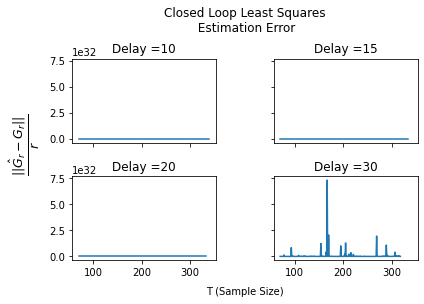

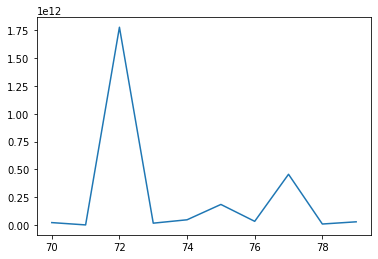

In [458]:
#need to do a simulation to determine how the emprical covariance scales....





class LTISystem(object):
    def __init__(self,A,B,C,f,sigma_w=1,sigma_v=1):
        self.A = A
        self.B = B
        self.C = C
        self.sigma_w = sigma_w
        self.sigma_v = sigma_v
        self.f = f
        
        self.x = np.zeros(len(A))
        self.output = 0
        
        self.outputs = []
        self.states = []
        
        sys = StateSpace(A, B.reshape(len(A),1), C.reshape(1,len(A)), np.array([[0]]))
        
        
        transferFunction = tf(sys)
        
        num = transferFunction.num
        den = transferFunction.den
        
        padded_num = np.zeros(len(den))
        
        padded_num[-len(num):] = num
        
        closed_loop_char_poly = f*padded_num+den
        
        print('Closed Loop max eigenvalue is: ')
        print(np.max(np.abs(np.roots(closed_loop_char_poly))))
        
        
        
        
#         assert np.max(np.abs(np.roots(closed_loop_char_poly))) < 1, "closed loop system unstable. Readjust gain f or try again with a new system."
        
        
        G = []
        for i in range(1000):
            G.append(C.dot(np.linalg.matrix_power(A,i).dot(B)))
        G = np.array(G)*f
        
        self.markovParametersScaled = G
        
        
        
        
#         assert np.max(np.abs(np.linalg.eigvals(A))) < 1, "A unstable"
    
    def set_variance(self,v):
        self.sigma_w = v
        self.sigma_v = v
        
    def wipe(self):
        self.outputs = []
        self.states = []
        
    def set_feedback(self,f):
        self.f = f
        
        
    def simulate_in_closed_loop(self,num_iter):
        
        for i in range(num_iter):
            try:
                self.x = self.A.dot(self.x) + self.B*self.f*self.output[-1] + np.random.normal(0,self.sigma_w,(len(self.A),))
            except:
                self.x = self.A.dot(self.x)+ np.random.normal(0,self.sigma_w,(len(self.A),))
            self.output = self.C.dot(self.x) + np.random.normal(0,self.sigma_v)
            
            self.states.append(self.x)
            self.outputs.append(self.output)
            
    
    def estimate_markov_parameters(self,window,T,num_iter, run = True):
        
        if run:
            self.wipe()
            self.simulate_in_closed_loop(num_iter)
        
        
        yvals = []
        for i in range(len(self.outputs)-window):
            yvals.append(self.outputs[i:i+window])
            
        yvals = np.array(yvals)
        
        assert T < len(yvals), 'Pick a smaller T or a larger num_iter'
        yvals = yvals[:T,:]
        
        y = self.outputs[window:window+T]
        
        assert len(y) == len(yvals)
        
        try:
            G_hat = np.linalg.inv(yvals.T.dot(yvals)+.05*np.eye(window)).dot(yvals.T.dot(y))
#             print("least square solution worked")
        except:
            G_hat = np.linalg.pinv(yvals.T.dot(yvals)+.05*np.eye(window)).dot(yvals.T.dot(y))
#             print("least square solution non invertible, used pseudo inverse")
            
        return G_hat, (np.linalg.norm(G_hat - self.markovParametersScaled[:window])**2)/window
        
        
    
    def calculate_empirical_variance(self,window,T,num_iter = 100, run = True):
        if run:
            self.simulate_in_closed_loop(num_iter)
        
        yvals = []
        for i in range(len(self.outputs)-window):
            yvals.append(self.outputs[i:i+window])
            
        yvals = np.array(yvals)
        
        #calculate covariance
        
        cov = np.zeros((window,window))
        
        
        assert T < len(yvals), 'Pick a smaller T'
        
        for i in range(T):
            cov+=np.outer(yvals[i,:],yvals[i,:])
            
        return cov, np.linalg.norm(cov)# np.min(np.abs(np.linalg.eigvals(cov)))
    
    
    def cmin_calculator(self,Tmax=300,window = 10):
        self.simulate_in_closed_loop(Tmax +100)
        
        normvals = []
        Tvals = np.array(np.arange(window+50,Tmax+50))
        
        for T in Tvals:
        
            _,norm = self.calculate_empirical_variance(window,T,num_iter = Tmax+50, run = False)
            
            normvals.append(norm)
            
            
        normvals = np.array(normvals)
        
        alpha = (Tvals.dot(normvals))/np.sum(Tvals**2)
        

        return alpha

    def HinfinityNorm(self,A=None,B=None,C=None,f=None,closedLoop= False):
        try:
            if A == None:
                A = self.A
                B = self.B
                C = self.C
                f = self.f
        except:
            pass
        #calculate markov parameters
        
        #need to verify if A is stable?
        
#         assert np.max(np.abs(np.linalg.eigvals(A))) <1, "A is not stable"
        
        if not closedLoop:
            num_params = 200
            mkvParams = []
            for i in range(num_params):
                mkvParams.append(C.dot(np.linalg.matrix_power(A,i).dot(B)))

            mkvParams = np.array(mkvParams)

            zvals = np.exp(1j*np.linspace(0,2*np.pi,200))

            norms = []

            for i in range(len(zvals)):
                val = 0
                z = zvals[i]
                for j in range(num_params):
                    val+= (1/(z**j))*mkvParams[j]
                val= np.abs(val)
                norms.append(val)

            return max(norms)
        else:
            num_params = 80
            mkvParams = []
            for i in range(num_params):
                mkvParams.append(C.dot(np.linalg.matrix_power(A+np.outer(B,C)*f,i)))
            
            zvals = np.exp(1j*np.linspace(0,2*np.pi,num_params))

            norms = []

            for i in range(len(zvals)):
                val = 0
                z = zvals[i]
                for j in range(num_params):
                    val+= (1/(z**j))*mkvParams[j]
#                 val= np.abs(val)
                norms.append(np.linalg.norm(val))
            
            return max(norms)
                
    
    def optimalControlHinfinity(self,A=None,B=None,C=None,fmax = -20,fmin=-20):
        
        
        
        
        
        try:
            if A == None:
                A = self.A
                B = self.B
                C = self.C
        except:
            pass
        
#         def dummy_func(f):
#             v = self.HinfinityNorm(A,B,C,f,closedLoop= False)
#             return v
            
        
#         res = minimize(dummy_func,bounds = [(-20,20)],x0 = np.array([-.1]))
#         print(res.x)
#         print(res.fun)
#         assert False
        
        fvals = np.linspace(fmin,fmax,200)
        
        
            
        
        norms = []
        for f in fvals:
            sys = StateSpace(A, B.reshape(len(A),1), C.reshape(1,len(A)), np.array([[0]]))


            transferFunction = tf(sys)

            num = transferFunction.num
            den = transferFunction.den

            padded_num = np.zeros(len(den))

            padded_num[-len(num):] = num

            closed_loop_char_poly = f*padded_num+den

            
            if np.max(np.abs(np.roots(closed_loop_char_poly))) > 1:
                norms.append(np.inf)
                continue
            else:
                normval = self.HinfinityNorm(A,B,C,f,closedLoop= True)
                norms.append(min([normval,1000]))
                
                
        if min(norms) == np.inf:
            return 0, 1000
        
        fvalszipped = zip(list(fvals),norms)
            
                
        fvalszipped = sorted(fvalszipped,key=lambda x:x[1])
        
#         plt.plot(fvals,norms)
        
        
        return fvalszipped[0][0], fvalszipped[0][1]
    
    def constructHankel(self,G,hankelSize):
        
        assert hankelSize <2*len(G), "make hankel matrix smaller"
        
        hankel = np.zeros((hankelSize,hankelSize))
        for i in range(hankelSize):
            for j in range(hankelSize):
                hankel[i,j] = G[i+j]
                
        return hankel
    
    def hoKalman(self,hankel,threshold = .0001,n=None):
        
        u, s, vh = np.linalg.svd(hankel,full_matrices = True)
        
        if n == None:
            #calculate n using thresholding of hankel singular values
            n =0
            for i in range(len(s)):
                if s[i]>threshold:
                    n+=1
        
            
        s = np.diag(s)
        smat = np.sqrt(s)
        
        V1 = u.dot(smat)
        V2 = (smat.dot(vh))
        
        V1 = V1[:,:n]
        V2 = V2[:n,:]
        
        
        
        Best = V2[:,0]
        Cest = V1[0,:]
        V2minus = V2[:,:len(hankel)-1]
        V2plus = V2[:,1:]
        
        V1minus = V1[:len(V1)-1,:]
        V1plus = V1[1:,:]
        
#         Aest = np.linalg.inv(V2minus.dot(V2minus.T)).dot(V2minus.dot(V2plus.T))
        Aest = (np.linalg.inv(V1minus.T.dot(V1minus))).dot(V1minus.T.dot(V1plus))
        
#         print(hankel[:3,:3])
#         newhankel = np.zeros((3,3))
#         for i in range(3):
#             for j in range(3):
#                 newhankel[i,j] = Cest.dot(np.linalg.matrix_power(Aest,i+j).dot(Best))
                
#         print(newhankel)
        
        return Aest,Best,Cest
    
    
    def adaptiveControl(self,num_epochs,n=None,threshold = .0001,T=100,num_iter= 200,window = 20):
        weighted_outputs = []
        self.wipe()
        yvals = []
        
#         feedbackgain,magnitude = self.optimalControlHinfinity()
#         print("optimal feedback gain for true system is "+str(feedbackgain))
#         print("with gain of "+str(magnitude))
        
        regret =[]
        
        fvals = []
        
        error_over_time = []
        
        for epoch in range(num_epochs):
            
            #how bad is the current feedback?
            hinfnow = self.HinfinityNorm(closedLoop=True)
            
            if epoch ==0:
                regret.append(np.abs(hinfnow))
            else:
                regret.append(np.abs(hinfnow)+regret[-1])
                
            
            
            
            print("starting epoch "+str(epoch))
            
            #first we run the system and collect relevant parameters
            
            self.simulate_in_closed_loop(num_iter)
            
            weighted_outputs += list((1/self.f)*np.array(self.outputs[(epoch)*num_iter+window:(epoch)*num_iter+window+T]))
            #now need to collect relevant yvals
            
            for i in range(T):
                yvals.append(self.outputs[epoch*num_iter+i :epoch*num_iter+window+i])
                
            
            yvalsmat = np.array(yvals)
            yplus = np.array(weighted_outputs)
            #now we need to do least squares to get an estimate of G
            
            Ghat= np.linalg.inv(yvalsmat.T.dot(yvalsmat)).dot(yvalsmat.T.dot(yplus))
            
            error_over_time.append(np.linalg.norm(Ghat-(self.markovParametersScaled/self.f)[:window]))
            
            print("estimation error is "+str(np.linalg.norm(Ghat-(self.markovParametersScaled/self.f)[:window])))
            
            hankel = self.constructHankel(Ghat,int((len(Ghat)/2)-2))
            Aest,Best,Cest = self.hoKalman(hankel,threshold = threshold,n=n)
            
            print('calculating optimal controller for estimated system')
            
            
            
            newf, _=self.optimalControlHinfinity(A=Aest,B=Best,C=Cest,fmax = 50,fmin=-50)
            newgain = self.HinfinityNorm(self.A,self.B,self.C,newf*.1+self.f*.9,closedLoop=True)
            print("new feedback gain is "+str(newf*.1+self.f*.9))
            print("with cost of "+str(newgain))
            
            self.set_feedback(newf*.1+self.f*.9)
            
            fvals.append(newf*.1+self.f*.9)
            
        return regret,fvals,error_over_time
            
            
    
        
        

        
            
            
        
        


# np.random.seed(41)


A = np.random.normal(0,1, (5,5))

B = np.random.normal(0,1,(5,))*.2

C = np.random.normal(0,1,(5,))*.2

v = .3

f= -.1


print("open loop system has max eigenvalue "+str(np.max(np.abs(np.linalg.eigvals(A)))))


system = LTISystem(A,B,C,f,v,v)

# hinf = system.HinfinityNorm(closedLoop=True)



G = system.markovParametersScaled/system.f

# hankel = system.constructHankel(G,20) + .1*np.random.normal(0,1,(20,20))


# Aest,Best,Cest = system.hoKalman(hankel,n=5)

# # feedbackvalue,gain = system.optimalControlHinfinity(Aest,Best,Cest)


# regret,fvals = system.adaptiveControl(num_epochs = 10,n=5,threshold = .00001)






# assert False



# np.random.seed(30)

def plot_error(plotName = 'ErrorPlot'):
    windows = [10,15,20,30]
    datalist = []

    for w in windows:
        
# #         A *= v
#         B *= v*2
#         C *= v*2
        
        
        system = LTISystem(A,B,C,f,v,v)
#         B *=1.7
#         C*=1.7
        
        
        Tvals = np.arange(70,500)
#         system.set_variance(v)
        
        system.wipe()

        system.simulate_in_closed_loop(1000)

        dataDict = []
        plt.figure()

        for T in Tvals:
            _, err = system.estimate_markov_parameters(window = w,T=T,num_iter=1000, run = False)

            dataDict.append(err)

           
        datalist.append(dataDict)
        del dataDict
        
    
    #make plot 
    
#     print(datalist)
    
    fig, axis = plt.subplots(2, 2,sharex=True, sharey=True)
    
    for i in range(4):
        if i < 2:

            if i ==0:
                axis[0, int(np.mod(i,2))].plot(Tvals, datalist[i])
            else:
                axis[0, int(np.mod(i,2))].plot(Tvals, datalist[i])
            axis[0, int(np.mod(i,2))].set_title("Delay ="+str(windows[i]))
        else:
            
            axis[1, int(np.mod(i,2))].plot(Tvals, datalist[i])
            axis[1, int(np.mod(i,2))].set_title("Delay ="+str(windows[i]))

    
#     fig.legend(loc = 'lower right')

#     plt.plot(Tvals,dataDict[r], label= 'Delay = '+str(r))
    
    fig.suptitle("Closed Loop Least Squares\n Estimation Error")
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=.8, 
                    wspace=0.4, 
                    hspace=0.4)

    fig.text(0.5, -0.02, "T (Sample Size)", ha='center')
    fig.text(-.05, 0.5, r"$\frac{||\hat{G}_r-G_r||}{r}$", fontsize = 18, va='center', rotation='vertical')


#     plt.savefig(plotName+'.png',bbox_inches='tight')

    
    plt.show()
    
    return Tvals,datalist
    
    
    

# plotnames = ['ErrorPlot1','ErrorPlot2','ErrorPlot3','ErrorPlot4']
# variances = [.1,.25,.5,1]


Tvals, datalist = plot_error('DelayError5')
        
plt.plot(Tvals[:10],datalist[0][:10])     
        

        

In [429]:
np.random.seed(42)

A = np.random.normal(0,1, (5,5))*.1

B = np.random.normal(0,1,(5,))*.2

C = np.random.normal(0,1,(5,))*.3

v = .1

f= .1

system = LTISystem(A,B,C,f,v,v)

# hinf = system.HinfinityNorm(closedLoop=True)



G = system.markovParametersScaled/system.f

# hankel = system.constructHankel(G,20) + 1.5*np.random.normal(0,1,(20,20))


# Aest,Best,Cest = system.hoKalman(hankel,n=5)
# print(system.optimalControlHinfinity(A = Aest,B=Best,C=Cest,fmax = 5,fmin=-5))

# assert False


tvals = np.arange(76,500,2)
errors = []
regret = [0]
system.simulate_in_closed_loop(2000)
for T in tqdm(tvals):
    Gest,err = system.estimate_markov_parameters(window = 42,T= T,num_iter= 2*T, run = False)
    hankel = system.constructHankel(Gest,20)
    Aest,Best,Cest = system.hoKalman(hankel,n=5)
    errors.append(err)
    f,_ = system.optimalControlHinfinity(A=Aest,B=Best,C=Cest,fmax = 5,fmin=-5)
    hinf = system.HinfinityNorm(A=Aest,B=Best,C=Cest,f = f,closedLoop=True)
    if f == 0:
        f = np.random.normal(0,.1)
    print(f,hinf)
    regret.append(hinf+regret[-1])
    
regret = regret[1:]
    

# print(Gest)
# print(np.linalg.norm(system.markovParametersScaled[:100]-Gest))
# print(err)

/Users/daltonjones/opt/anaconda3/lib/python3.8/site-packages/scipy/signal/filter_design.py:1625: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
  0%|          | 0/212 [00:00<?, ?it/s]

Closed Loop max eigenvalue is: 
0.19208610607102575


  0%|          | 1/212 [00:02<09:06,  2.59s/it]

0.6281407035175883 4.739698694961687


  1%|          | 2/212 [00:04<08:23,  2.40s/it]

0.3768844221105532 6.200546642518538


  1%|▏         | 3/212 [00:06<07:54,  2.27s/it]

0.3768844221105532 6.282128574987342


  2%|▏         | 4/212 [00:08<07:33,  2.18s/it]

0.4271356783919602 5.511767039499961


  2%|▏         | 5/212 [00:10<07:21,  2.13s/it]

0.47738693467336724 5.096930901163123


  3%|▎         | 6/212 [00:12<07:27,  2.17s/it]

0.47738693467336724 5.083852474236884


  3%|▎         | 7/212 [00:14<07:23,  2.16s/it]

0.47738693467336724 5.017279002334634


  4%|▍         | 8/212 [00:16<07:00,  2.06s/it]

0.4271356783919602 4.869019513546797


  4%|▍         | 9/212 [00:18<06:52,  2.03s/it]

0.3768844221105532 4.955358237684292


  5%|▍         | 10/212 [00:20<06:49,  2.02s/it]

0.5276381909547743 4.771684463920367


  5%|▌         | 11/212 [00:23<07:40,  2.29s/it]

0.8291457286432165 6.204953574757858


  6%|▌         | 12/212 [00:26<08:32,  2.56s/it]

0.17587939698492505 6.408417834473628


  6%|▌         | 13/212 [00:29<08:40,  2.62s/it]

0.2763819095477391 8.493584696758763


  7%|▋         | 14/212 [00:32<08:43,  2.65s/it]

0.17587939698492505 7.390983479545733


  7%|▋         | 15/212 [00:34<08:40,  2.64s/it]

0.2763819095477391 7.9436825802154445


  8%|▊         | 16/212 [00:35<06:53,  2.11s/it]

0.2763819095477391 8.257844555294621


  8%|▊         | 17/212 [00:37<06:09,  1.90s/it]

0.17587939698492505 9.718301057352043


  8%|▊         | 18/212 [00:38<05:54,  1.83s/it]

0.32663316582914614 7.593190841874306


  9%|▉         | 19/212 [00:40<05:28,  1.70s/it]

0.32663316582914614 7.727102013371498


  9%|▉         | 20/212 [00:41<05:24,  1.69s/it]

0.32663316582914614 7.786624122182057


 10%|▉         | 21/212 [00:43<05:06,  1.61s/it]

0.32663316582914614 6.542450198542251


 10%|█         | 22/212 [00:44<04:55,  1.55s/it]

0.5276381909547743 5.823680535956233


 11%|█         | 23/212 [00:45<04:17,  1.36s/it]

0.47738693467336724 6.42586311023527


 11%|█▏        | 24/212 [00:46<03:49,  1.22s/it]

0.3768844221105532 5.984117033793515


 12%|█▏        | 25/212 [00:48<04:29,  1.44s/it]

0.5778894472361813 5.910623944091126


 12%|█▏        | 26/212 [00:50<05:07,  1.65s/it]

0.7788944723618094 4.963770856450921


 13%|█▎        | 27/212 [00:52<05:25,  1.76s/it]

0.8291457286432165 4.445209830198527


 13%|█▎        | 28/212 [00:54<05:27,  1.78s/it]

0.9798994974874375 4.048589077796972


 14%|█▎        | 29/212 [00:55<05:07,  1.68s/it]

0.5778894472361813 6.8249648330302035


 14%|█▍        | 30/212 [00:57<04:52,  1.61s/it]

0.8291457286432165 5.214555937301048


 15%|█▍        | 31/212 [00:58<04:43,  1.56s/it]

0.8793969849246235 5.486450819284346


 15%|█▌        | 32/212 [01:00<04:26,  1.48s/it]

0.47738693467336724 7.347526968078614


 16%|█▌        | 33/212 [01:01<04:11,  1.40s/it]

0.47738693467336724 7.982604022390834


 16%|█▌        | 34/212 [01:02<04:06,  1.39s/it]

0.6783919597989954 6.933513198698871


 17%|█▋        | 35/212 [01:04<04:05,  1.39s/it]

0.9296482412060305 6.442391364648757


 17%|█▋        | 36/212 [01:05<04:17,  1.46s/it]

1.0301507537688446 6.066760547530791


 17%|█▋        | 37/212 [01:07<04:21,  1.49s/it]

0.8291457286432165 5.354490203593974


 18%|█▊        | 38/212 [01:08<04:20,  1.50s/it]

0.9296482412060305 5.861548773265852


 18%|█▊        | 39/212 [01:10<04:25,  1.53s/it]

0.9296482412060305 5.368901059551147


 19%|█▉        | 40/212 [01:12<04:32,  1.58s/it]

1.2311557788944727 5.328340035713632


 19%|█▉        | 41/212 [01:13<04:36,  1.62s/it]

1.3316582914572868 5.841894283915325


 20%|█▉        | 42/212 [01:15<04:28,  1.58s/it]

0.6281407035175883 7.591412752584496


 20%|██        | 43/212 [01:17<04:36,  1.63s/it]

1.1809045226130657 6.430549271682079


 21%|██        | 44/212 [01:18<04:35,  1.64s/it]

0.5276381909547743 7.994792271996451


 21%|██        | 45/212 [01:20<04:32,  1.63s/it]

0.9798994974874375 7.052290398670186


 22%|██▏       | 46/212 [01:22<04:50,  1.75s/it]

1.3316582914572868 6.067219466920535


 22%|██▏       | 47/212 [01:24<04:57,  1.80s/it]

1.2311557788944727 5.781881829917138


 23%|██▎       | 48/212 [01:25<04:47,  1.75s/it]

0.7788944723618094 5.59363777526103


 23%|██▎       | 49/212 [01:27<04:38,  1.71s/it]

-0.17587939698492416 4.062613287106645


 24%|██▎       | 50/212 [01:29<04:43,  1.75s/it]

-0.2261306532663312 4.163492175562548


 24%|██▍       | 51/212 [01:31<04:37,  1.72s/it]

-0.7286432160804015 5.990476281530908


 25%|██▍       | 52/212 [01:32<04:27,  1.67s/it]

0.47738693467336724 7.0062762804194385


 25%|██▌       | 53/212 [01:34<04:22,  1.65s/it]

-0.7788944723618085 5.858973686055907


 25%|██▌       | 54/212 [01:36<04:37,  1.76s/it]

-0.47738693467336635 3.886043024929868


 26%|██▌       | 55/212 [01:39<05:29,  2.10s/it]

-0.7788944723618085 4.540683367898558


 26%|██▋       | 56/212 [01:40<05:12,  2.01s/it]

-0.2763819095477382 3.886742982751093


 27%|██▋       | 57/212 [01:42<04:58,  1.93s/it]

-1.0804020100502512 4.241731067306038


 27%|██▋       | 58/212 [01:44<04:52,  1.90s/it]

-0.2261306532663312 3.6887991004831324


 28%|██▊       | 59/212 [01:46<04:54,  1.92s/it]

-0.2261306532663312 3.936368141381302


 28%|██▊       | 60/212 [01:48<04:45,  1.88s/it]

-0.12562814070351713 3.9780240373429145


 29%|██▉       | 61/212 [01:49<04:38,  1.85s/it]

-0.12562814070351713 3.997399013702745


 29%|██▉       | 62/212 [01:52<04:55,  1.97s/it]

0.5276381909547743 4.835687626624999


 30%|██▉       | 63/212 [01:53<04:41,  1.89s/it]

-0.9798994974874367 4.3144395960253545


 30%|███       | 64/212 [01:55<04:37,  1.87s/it]

-1.0301507537688441 4.2140306609010345


 31%|███       | 65/212 [01:57<04:34,  1.87s/it]

-0.9798994974874367 4.421825364483141


 31%|███       | 66/212 [01:59<04:31,  1.86s/it]

-0.9798994974874367 4.548149455360487


 32%|███▏      | 67/212 [02:01<04:26,  1.84s/it]

-1.0804020100502512 4.481445426998494


 32%|███▏      | 68/212 [02:02<04:16,  1.78s/it]

-0.2261306532663312 4.362172996653702


 33%|███▎      | 69/212 [02:04<03:59,  1.67s/it]

0.22613065326633208 5.617971940561114


 33%|███▎      | 70/212 [02:06<04:13,  1.79s/it]

0.7286432160804024 5.790962789915472


 33%|███▎      | 71/212 [02:08<04:19,  1.84s/it]

0.32663316582914614 5.0859165461335225


 34%|███▍      | 72/212 [02:10<04:46,  2.05s/it]

1.1306532663316586 4.337666470361423


 34%|███▍      | 73/212 [02:13<05:00,  2.16s/it]

0.9798994974874375 4.419401294340985


 35%|███▍      | 74/212 [02:16<05:36,  2.44s/it]

1.3819095477386938 4.007930032966368


 35%|███▌      | 75/212 [02:19<05:48,  2.54s/it]

1.1809045226130657 4.267431119515487


 36%|███▌      | 76/212 [02:21<05:50,  2.58s/it]

1.3316582914572868 4.176197950083642


 36%|███▋      | 77/212 [02:24<06:11,  2.75s/it]

1.884422110552764 3.32850280637077


 37%|███▋      | 78/212 [02:28<06:21,  2.85s/it]

1.3316582914572868 3.5091738162617525


 37%|███▋      | 79/212 [02:31<06:51,  3.09s/it]

1.4321608040201008 2.9555431161027528


 38%|███▊      | 80/212 [02:35<07:15,  3.30s/it]

1.5326633165829149 2.8529740040816214


 38%|███▊      | 81/212 [02:38<07:05,  3.25s/it]

1.4824120603015079 2.8287811582620797


 39%|███▊      | 82/212 [02:41<06:57,  3.21s/it]

1.633165829145729 2.9175360189047916


 39%|███▉      | 83/212 [02:44<06:51,  3.19s/it]

1.5326633165829149 3.068016374946287


 40%|███▉      | 84/212 [02:47<06:42,  3.14s/it]

1.4321608040201008 2.7468094334184494


 40%|████      | 85/212 [02:51<06:46,  3.20s/it]

1.683417085427136 3.022411681191411


 41%|████      | 86/212 [02:53<06:15,  2.98s/it]

1.2311557788944727 2.900753396365629


 41%|████      | 87/212 [02:57<06:30,  3.13s/it]

2.4371859296482414 3.4196271971186416


 42%|████▏     | 88/212 [02:59<06:10,  2.99s/it]

0.9798994974874375 3.0870838337822932


 42%|████▏     | 89/212 [03:02<06:06,  2.98s/it]

0.8291457286432165 3.9669105020026665


 42%|████▏     | 90/212 [03:05<05:57,  2.93s/it]

0.6783919597989954 4.914537371410574


 43%|████▎     | 91/212 [03:08<05:52,  2.91s/it]

0.7788944723618094 4.060712942726792


 43%|████▎     | 92/212 [03:12<06:13,  3.11s/it]

1.884422110552764 2.698994221823667


 44%|████▍     | 93/212 [03:16<06:44,  3.40s/it]

2.3366834170854274 2.459996290265955


 44%|████▍     | 94/212 [03:19<06:54,  3.51s/it]

2.3366834170854274 2.502317828309759


 45%|████▍     | 95/212 [03:23<06:57,  3.57s/it]

2.3869346733668344 2.5603214774942957


 45%|████▌     | 96/212 [03:27<07:12,  3.73s/it]

2.2864321608040203 1.6417556709346768


 46%|████▌     | 97/212 [03:31<06:56,  3.62s/it]

1.5326633165829149 1.4980411735663646


 46%|████▌     | 98/212 [03:34<06:47,  3.58s/it]

1.582914572864322 1.450053970837331


 47%|████▋     | 99/212 [03:38<06:51,  3.64s/it]

2.4371859296482414 1.6293117585609622


 47%|████▋     | 100/212 [03:42<06:50,  3.66s/it]

2.3366834170854274 2.684681517755276


 48%|████▊     | 101/212 [03:45<06:43,  3.64s/it]

1.733668341708543 2.495155197391185


 48%|████▊     | 102/212 [03:49<06:36,  3.61s/it]

0.9798994974874375 4.650654585509042


 49%|████▊     | 103/212 [03:52<06:15,  3.45s/it]

0.8793969849246235 5.146588980568944


 49%|████▉     | 104/212 [03:55<06:16,  3.49s/it]

1.3316582914572868 4.046565993684695


 50%|████▉     | 105/212 [03:59<06:20,  3.56s/it]

1.2814070351758797 4.044963288984696


 50%|█████     | 106/212 [04:02<06:10,  3.50s/it]

1.2814070351758797 3.9372410112075715


 50%|█████     | 107/212 [04:05<05:53,  3.37s/it]

1.0301507537688446 4.460436389481898


 51%|█████     | 108/212 [04:08<05:33,  3.21s/it]

0.7286432160804024 4.95485825729965


 51%|█████▏    | 109/212 [04:11<05:13,  3.05s/it]

0.6783919597989954 5.4066807151176395


 52%|█████▏    | 110/212 [04:14<05:05,  2.99s/it]

0.9296482412060305 4.0207303628848825


 52%|█████▏    | 111/212 [04:17<04:56,  2.93s/it]

0.8291457286432165 4.056517452801362


 53%|█████▎    | 112/212 [04:19<04:42,  2.83s/it]

0.5778894472361813 4.6026542649693845


 53%|█████▎    | 113/212 [04:22<04:43,  2.86s/it]

1.1306532663316586 3.226099249518397


 54%|█████▍    | 114/212 [04:25<04:35,  2.81s/it]

0.9296482412060305 3.3568969950270637


 54%|█████▍    | 115/212 [04:28<04:38,  2.87s/it]

1.2311557788944727 3.198046837649203


 55%|█████▍    | 116/212 [04:31<04:31,  2.83s/it]

1.2311557788944727 3.1316475498982195


 55%|█████▌    | 117/212 [04:33<04:25,  2.80s/it]

1.0804020100502516 3.290307242536998


 56%|█████▌    | 118/212 [04:36<04:22,  2.79s/it]

1.4321608040201008 2.903799630258917


 56%|█████▌    | 119/212 [04:39<04:17,  2.77s/it]

1.683417085427136 2.7855048903620387


 57%|█████▋    | 120/212 [04:42<04:30,  2.94s/it]

1.2814070351758797 2.552984698947269


 57%|█████▋    | 121/212 [04:46<04:48,  3.17s/it]

1.78391959798995 2.4265740305339514


 58%|█████▊    | 122/212 [04:50<05:11,  3.46s/it]

0.6783919597989954 2.153979028874262


 58%|█████▊    | 123/212 [04:55<05:57,  4.01s/it]

-2.8391959798994972 0.8905272372733225


 58%|█████▊    | 124/212 [05:00<06:09,  4.20s/it]

-1.6834170854271355 0.9733675661563196


 59%|█████▉    | 125/212 [05:04<06:08,  4.24s/it]

0.7286432160804024 2.6230030745616557


 59%|█████▉    | 126/212 [05:09<06:27,  4.50s/it]

-0.5276381909547734 1.012809723451066


 60%|█████▉    | 127/212 [05:15<06:43,  4.75s/it]

-0.6783919597989945 1.0275069025132402


 60%|██████    | 128/212 [05:20<06:46,  4.84s/it]

-0.5778894472361804 1.034742399732402


 61%|██████    | 129/212 [05:25<06:43,  4.86s/it]

-0.9798994974874367 1.0137037414731191


 61%|██████▏   | 130/212 [05:29<06:32,  4.79s/it]

-1.3819095477386933 1.0907522818296427


 62%|██████▏   | 131/212 [05:34<06:23,  4.73s/it]

-0.6783919597989945 1.1166545744983254


 62%|██████▏   | 132/212 [05:39<06:29,  4.87s/it]

1.884422110552764 2.29133704775076


 63%|██████▎   | 133/212 [05:43<06:02,  4.59s/it]

0.5778894472361813 3.455310827416857


 63%|██████▎   | 134/212 [05:48<06:10,  4.74s/it]

0.22613065326633208 1.096430699801788


 64%|██████▎   | 135/212 [05:53<06:06,  4.76s/it]

0.4271356783919602 1.1447476474190383


 64%|██████▍   | 136/212 [05:57<05:45,  4.54s/it]

0.8793969849246235 2.0307735917962444


 65%|██████▍   | 137/212 [06:02<05:51,  4.68s/it]

0.12562814070351802 2.071710135285371


 65%|██████▌   | 138/212 [06:07<05:47,  4.69s/it]

0.17587939698492505 1.7729435442796568


 66%|██████▌   | 139/212 [06:11<05:43,  4.71s/it]

0.22613065326633208 1.7690760174238334


 66%|██████▌   | 140/212 [06:16<05:29,  4.57s/it]

0.12562814070351802 1.7181544202507248


 67%|██████▋   | 141/212 [06:20<05:23,  4.56s/it]

0.8291457286432165 2.163215103977908


 67%|██████▋   | 142/212 [06:25<05:23,  4.62s/it]

1.0301507537688446 2.0742328082065504


 67%|██████▋   | 143/212 [06:30<05:22,  4.68s/it]

1.884422110552764 1.4044873135531384


 68%|██████▊   | 144/212 [06:35<05:24,  4.77s/it]

1.3819095477386938 1.1787411326918087


 68%|██████▊   | 145/212 [06:39<05:15,  4.72s/it]

1.5326633165829149 1.3714356291015048


 69%|██████▉   | 146/212 [06:44<05:13,  4.75s/it]

-2.135678391959799 0.9851542745784875


 69%|██████▉   | 147/212 [06:49<05:09,  4.77s/it]

-2.0351758793969847 0.9661002863345547


 70%|██████▉   | 148/212 [06:53<04:55,  4.61s/it]

-3.391959798994975 1.365233740466394


 70%|███████   | 149/212 [06:58<04:56,  4.70s/it]

-2.78894472361809 1.313608372106099


 71%|███████   | 150/212 [07:03<04:52,  4.72s/it]

-2.8391959798994972 1.2970652190121688


 71%|███████   | 151/212 [07:07<04:44,  4.66s/it]

-3.64321608040201 1.2174174221460543


 72%|███████▏  | 152/212 [07:12<04:43,  4.72s/it]

1.4321608040201008 1.2689717728687866


 72%|███████▏  | 153/212 [07:18<04:49,  4.90s/it]

0.47738693467336724 1.4111366529646605


 73%|███████▎  | 154/212 [07:23<04:51,  5.02s/it]

1.1809045226130657 1.3315391973806943


 73%|███████▎  | 155/212 [07:28<04:43,  4.98s/it]

3.391959798994975 1.4378178074282244


 74%|███████▎  | 156/212 [07:33<04:34,  4.89s/it]

3.190954773869347 1.4223664622552288


 74%|███████▍  | 157/212 [07:38<04:30,  4.92s/it]

2.9396984924623117 1.3309081663559732


 75%|███████▍  | 158/212 [07:42<04:25,  4.92s/it]

2.8391959798994977 1.3224289942594738


 75%|███████▌  | 159/212 [07:47<04:19,  4.90s/it]

2.9899497487437188 1.3527636153294573


 75%|███████▌  | 160/212 [07:52<04:15,  4.92s/it]

3.190954773869347 1.43548238877483


 76%|███████▌  | 161/212 [07:57<04:08,  4.87s/it]

3.643216080402011 1.5970868437463877


 76%|███████▋  | 162/212 [08:02<04:08,  4.97s/it]

2.9899497487437188 1.0925069610603373


 77%|███████▋  | 163/212 [08:07<04:03,  4.97s/it]

3.341708542713569 1.1646568077710604


 77%|███████▋  | 164/212 [08:12<04:02,  5.05s/it]

3.391959798994975 1.218230114431892


 78%|███████▊  | 165/212 [08:17<03:56,  5.04s/it]

3.190954773869347 1.1284417444232222


 78%|███████▊  | 166/212 [08:22<03:51,  5.02s/it]

3.693467336683417 1.092047084568215


 79%|███████▉  | 167/212 [08:25<03:18,  4.40s/it]

2.1859296482412063 3.0058487174733863


 79%|███████▉  | 168/212 [08:30<03:10,  4.33s/it]

0.2763819095477391 3.046891583986354


 80%|███████▉  | 169/212 [08:34<03:03,  4.26s/it]

-0.2763819095477382 3.3267823006152004


 80%|████████  | 170/212 [08:38<03:00,  4.30s/it]

-0.6783919597989945 3.0543957583941403


 81%|████████  | 171/212 [08:42<02:50,  4.16s/it]

-1.8844221105527637 2.751318733733354


 81%|████████  | 172/212 [08:47<02:53,  4.33s/it]

-3.8442211055276383 2.504650884796581


 82%|████████▏ | 173/212 [08:50<02:43,  4.18s/it]

-2.0351758793969847 3.6394836864698292


 82%|████████▏ | 174/212 [08:56<02:57,  4.66s/it]

-3.291457286432161 1.5065648042311914


 83%|████████▎ | 175/212 [09:02<03:05,  5.02s/it]

-1.1306532663316582 1.1083657692568516


 83%|████████▎ | 176/212 [09:06<02:48,  4.67s/it]

-2.0351758793969847 2.368005831500357


 83%|████████▎ | 177/212 [09:11<02:42,  4.65s/it]

-2.487437185929648 2.1350362295547742


 84%|████████▍ | 178/212 [09:15<02:41,  4.74s/it]

-1.2814070351758793 2.4402514319844433


 84%|████████▍ | 179/212 [09:19<02:29,  4.52s/it]

-2.0351758793969847 2.4800525479560567


 85%|████████▍ | 180/212 [09:24<02:25,  4.53s/it]

-2.638190954773869 2.578151431329656


 85%|████████▌ | 181/212 [09:29<02:25,  4.71s/it]

-2.386934673366834 1.9577966515216143


 86%|████████▌ | 182/212 [09:34<02:23,  4.78s/it]

-2.587939698492462 1.892449556536573


 86%|████████▋ | 183/212 [09:38<02:11,  4.55s/it]

-2.135678391959799 2.1122581307713957


 87%|████████▋ | 184/212 [09:43<02:07,  4.56s/it]

-1.3316582914572863 1.8008536714838337


 87%|████████▋ | 185/212 [09:48<02:05,  4.64s/it]

5.0 1.1674280892944782


 88%|████████▊ | 186/212 [09:53<02:07,  4.89s/it]

5.0 1.562346421517111


 88%|████████▊ | 187/212 [09:58<02:05,  5.03s/it]

-0.12562814070351713 1.5590027529718684


 89%|████████▊ | 188/212 [10:03<02:00,  5.00s/it]

-4.547738693467337 1.1746526429689184


 89%|████████▉ | 189/212 [10:08<01:56,  5.05s/it]

-4.899497487437186 1.2038271030194803


 90%|████████▉ | 190/212 [10:14<01:51,  5.09s/it]

-4.899497487437186 1.1655020967449996


 90%|█████████ | 191/212 [10:18<01:43,  4.91s/it]

-3.391959798994975 2.3200059089364853


 91%|█████████ | 192/212 [10:23<01:35,  4.78s/it]

-2.9396984924623113 2.495452564091209


 91%|█████████ | 193/212 [10:27<01:27,  4.62s/it]

-2.9899497487437183 2.476319221719459


 92%|█████████▏| 194/212 [10:31<01:19,  4.44s/it]

-2.8894472361809043 2.5323080490406045


 92%|█████████▏| 195/212 [10:35<01:11,  4.22s/it]

-1.6834170854271355 3.2045171202837377


 92%|█████████▏| 196/212 [10:38<01:01,  3.83s/it]

-0.7788944723618085 3.533553523696228


 93%|█████████▎| 197/212 [10:42<01:02,  4.18s/it]

1.0301507537688446 2.8040448953689263


 93%|█████████▎| 198/212 [10:44<00:49,  3.52s/it]

5.0 3.014863663272844


 94%|█████████▍| 199/212 [10:50<00:53,  4.15s/it]

-5.0 2.3848231882203996


 94%|█████████▍| 200/212 [10:53<00:43,  3.64s/it]

5.0 3.9839961593268804


 95%|█████████▍| 201/212 [10:55<00:36,  3.35s/it]

0.07537688442211099 3.9766939217616413


 95%|█████████▌| 202/212 [10:58<00:31,  3.11s/it]

5.0 3.8543208671801463


 96%|█████████▌| 203/212 [11:03<00:32,  3.63s/it]

0.8793969849246235 2.364901394006129


 96%|█████████▌| 204/212 [11:08<00:32,  4.01s/it]

-5.0 2.158618486856836


 97%|█████████▋| 205/212 [11:12<00:29,  4.25s/it]

-5.0 2.3172685305461758


 97%|█████████▋| 206/212 [11:15<00:22,  3.67s/it]

5.0 3.5584785619821715


 98%|█████████▊| 207/212 [11:17<00:17,  3.42s/it]

5.0 3.7166092324883166


 98%|█████████▊| 208/212 [11:22<00:15,  3.84s/it]

-5.0 2.3471821264490607


 99%|█████████▊| 209/212 [11:27<00:12,  4.14s/it]

1.683417085427136 2.6190198794418653


 99%|█████████▉| 210/212 [11:32<00:08,  4.35s/it]

-5.0 1.8937807575599608


100%|█████████▉| 211/212 [11:37<00:04,  4.49s/it]

-5.0 2.1985791854748196


100%|██████████| 212/212 [11:42<00:00,  3.31s/it]

-5.0 2.07878401699165


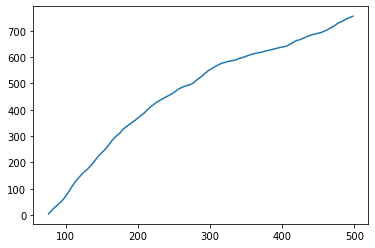

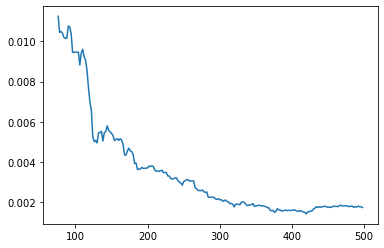

In [432]:
# print(regret)

plt.figure()
plt.plot(tvals,regret)
plt.show()

plt.figure()
plt.plot(tvals,errors)
plt.show()

# goodregret = regret
# gooderrors = errors
# goodtvals = tvals

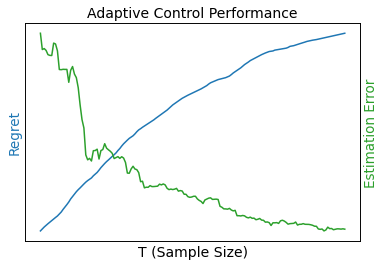

In [448]:
# t = np.arange(0.01, 10.0, 0.01)
# data1 = np.exp(t)
# data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

color = colors[0]
ax1.set_xlabel('T (Sample Size)',fontsize = 14)
ax1.set_ylabel('Regret', fontsize = 13.5,color=color)
ax1.plot(tvals[:-50], regret[:-50], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = colors[2]
ax2.set_ylabel('Estimation Error',fontsize = 13.5, color=color)  # we already handled the x-label with ax1
ax2.plot(tvals[:-50],errors[:-50], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.axes.xaxis.set_ticks([])
ax1.axes.yaxis.set_ticks([])
ax2.axes.yaxis.set_ticks([])

plt.title("Adaptive Control Performance",fontsize = 14)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.savefig("AdaptiveControl.png",bbox_inches = "tight")
plt.show()

In [384]:
np.random.seed(42)

A = np.random.normal(0,1, (5,5))*.2

B = np.random.normal(0,1,(5,))*.2

C = np.random.normal(0,1,(5,))*.2

v = .1

f= .5


system = LTISystem(A,B,C,f,v,v)

# hinf = system.HinfinityNorm(closedLoop=True)



G = system.markovParametersScaled/system.f

hankel = system.constructHankel(G,20) + .1*np.random.normal(0,1,(20,20))


Aest,Best,Cest = system.hoKalman(hankel,n=5)

# feedbackvalue,gain = system.optimalControlHinfinity(fmin = -20,fmax = 20)

text = input("write continue to continue")
assert text == 'continue'




regret,fvals,error_over_time = system.adaptiveControl(num_epochs =  1000,n=5,threshold = .00001)

/Users/daltonjones/opt/anaconda3/lib/python3.8/site-packages/scipy/signal/filter_design.py:1625: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


Closed Loop max eigenvalue is: 
0.39586856825713157
write continue to continuecontinue


  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 0
estimation error is 0.9552120389498588
calculating optimal controller for estimated system
new feedback gain is 0.5132911392405063
with cost of 0.709391641163178
starting epoch 1
estimation error is 0.8950308771784131
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 641.82it/s]


new feedback gain is 0.525253164556962
with cost of 0.7084864708446397
starting epoch 2
estimation error is 0.6001970710443227
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 560.99it/s]

new feedback gain is 0.5360189873417721
with cost of 0.7076737903086385
starting epoch 3
estimation error is 0.45890357771761714
calculating optimal controller for estimated system



 52%|█████▎    | 42/80 [00:00<00:00, 349.37it/s]

new feedback gain is 0.5457082278481012
with cost of 0.7069439702408312
starting epoch 4
estimation error is 0.3773615268698158
calculating optimal controller for estimated system


 51%|█████▏    | 41/80 [00:00<00:00, 346.22it/s]

new feedback gain is 0.4278462658227848
with cost of 0.7159251678086412
starting epoch 5
estimation error is 0.32752098753885384
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 834.93it/s]


new feedback gain is 0.4483527784810126
with cost of 0.7143461896159476
starting epoch 6
estimation error is 0.3132639184149508
calculating optimal controller for estimated system
new feedback gain is 0.34022636139240503
with cost of 0.7227511818087237


100%|██████████| 80/80 [00:00<00:00, 1943.49it/s]

starting epoch 7
estimation error is 0.3508664795986265
calculating optimal controller for estimated system
new feedback gain is 0.31620372525316454
with cost of 0.7246454567164905
starting epoch 8
estimation error is 0.3400267549315304
calculating optimal controller for estimated system
new feedback gain is 0.2945833527278481
with cost of 0.7263588139255787



100%|██████████| 80/80 [00:00<00:00, 1912.13it/s]

starting epoch 9
estimation error is 0.2889736503769157
calculating optimal controller for estimated system
new feedback gain is 0.2751250174550633
with cost of 0.7279077775241929
starting epoch 10
estimation error is 0.3085833941107268
calculating optimal controller for estimated system
new feedback gain is 0.25761251570955696
with cost of 0.7293075040489894



100%|██████████| 80/80 [00:00<00:00, 1882.00it/s]

starting epoch 11
estimation error is 0.37605933567773503
calculating optimal controller for estimated system
new feedback gain is 0.24185126413860128
with cost of 0.7305718685314224
starting epoch 12
estimation error is 0.36813991571274096
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 668.90it/s]

new feedback gain is 0.22766613772474117
with cost of 0.7317135506856566
starting epoch 13
estimation error is 0.3849804661774071
calculating optimal controller for estimated system
new feedback gain is 2.4200893973699893
with cost of 0.5893637461422648



100%|██████████| 80/80 [00:00<00:00, 2019.23it/s]

starting epoch 14
estimation error is 0.34966898087244375
calculating optimal controller for estimated system
new feedback gain is 2.1880804576329904
with cost of 0.6017521031576091
starting epoch 15
estimation error is 0.3234332552521289
calculating optimal controller for estimated system
new feedback gain is 1.9792724118696914
with cost of 0.6133554979059415



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 16
estimation error is 0.3031271270451085
calculating optimal controller for estimated system
new feedback gain is 1.7913451706827224
with cost of 0.6241879135265996
starting epoch 17
estimation error is 0.2833596568120687
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.9413245776650836
with cost of 0.5633098635034737
starting epoch 18
estimation error is 0.2681661093893772
calculating optimal controller for estimated system
new feedback gain is 2.6571921198985753
with cost of 0.5772195451756987
starting epoch 19
estimation error is 0.2601268563723059
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.4014729079087176
with cost of 0.5903389391884065
starting epoch 20
estimation error is 0.24489057601793618
calculating optimal controller for estimated system
new feedback gain is 2.1713256171178457
with cost of 0.6026669391483558
starting epoch 21
estimation error is 0.23977989598682145
calculating optimal controller for estimated system


 84%|████████▍ | 67/80 [00:00<00:00, 644.24it/s]

new feedback gain is 5.5617879921149225
with cost of 0.5035986925238443
starting epoch 22
estimation error is 0.22992614716995288
calculating optimal controller for estimated system


 86%|████████▋ | 69/80 [00:00<00:00, 633.88it/s]

new feedback gain is 8.106875015688242
with cost of 0.5810139134860112
starting epoch 23
estimation error is 0.2194326774586951
calculating optimal controller for estimated system


 95%|█████████▌| 76/80 [00:00<00:00, 676.65it/s]

new feedback gain is 10.650617893866254
with cost of 0.7427630098999568
starting epoch 24
estimation error is 0.2101682834611251
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1985.47it/s]

new feedback gain is 13.826062433593552
with cost of 1.1376284556794378
starting epoch 25
estimation error is 0.20111476154624142
calculating optimal controller for estimated system
new feedback gain is 12.453456190234197
with cost of 0.9251630001574294
starting epoch 26
estimation error is 0.19244290364977484
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 1973.12it/s]

new feedback gain is 11.218110571210778
with cost of 0.7919242035041804
starting epoch 27
estimation error is 0.18726943187952558
calculating optimal controller for estimated system
new feedback gain is 10.1062995140897
with cost of 0.7010140150967847
starting epoch 28
estimation error is 0.18081621312488955
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 1945.76it/s]

new feedback gain is 9.105669562680731
with cost of 0.6353500413540448
starting epoch 29
estimation error is 0.17427064232694645
calculating optimal controller for estimated system
new feedback gain is 8.205102606412659
with cost of 0.5859425325536766
starting epoch 30
estimation error is 0.17058254687167546
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.394592345771393
with cost of 0.5477967720134705
starting epoch 31
estimation error is 0.1663596667415417
calculating optimal controller for estimated system
new feedback gain is 6.665133111194254
with cost of 0.5205990843821638
starting epoch 32
estimation error is 0.16073230071967673
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.008619800074828
with cost of 0.5069809389876053
starting epoch 33
estimation error is 0.15590524146787338
calculating optimal controller for estimated system
new feedback gain is 5.4177578200673455
with cost of 0.5030795993377293
starting epoch 34
estimation error is 0.15165218637766326
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 4.885982038060611
with cost of 0.5036410695312353
starting epoch 35
estimation error is 0.14724188049102316
calculating optimal controller for estimated system
new feedback gain is 4.40738383425455
with cost of 0.5070647456161571
starting epoch 36
estimation error is 0.1424104784222291
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 2052.92it/s]

new feedback gain is 3.976645450829095
with cost of 0.5178397855340257
starting epoch 37
estimation error is 0.13941500313916008
calculating optimal controller for estimated system
new feedback gain is 3.5889809057461854
with cost of 0.533979047570537
starting epoch 38
estimation error is 0.13576404495474784
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 3.240082815171567
with cost of 0.5493893442514253
starting epoch 39
estimation error is 0.13154119467375366
calculating optimal controller for estimated system
new feedback gain is 2.92607453365441
with cost of 0.5640393812133125
starting epoch 40
estimation error is 0.1279132636015674
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.6434670802889686
with cost of 0.5779088668778156
starting epoch 41
estimation error is 0.1259186350810287
calculating optimal controller for estimated system
new feedback gain is 2.389120372260072
with cost of 0.5909877887460909
starting epoch 42
estimation error is 0.12201461105265247
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.1602083350340644
with cost of 0.6032754938695531
starting epoch 43
estimation error is 0.1208048496274704
calculating optimal controller for estimated system
new feedback gain is 1.954187501530658
with cost of 0.6147796364753617
starting epoch 44
estimation error is 0.11892594448419926
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 1.7687687513775923
with cost of 0.6255150516993502
starting epoch 45
estimation error is 0.11818770924301501
calculating optimal controller for estimated system
new feedback gain is 1.601891876239833
with cost of 0.6355026075104026
starting epoch 46
estimation error is 0.11615729334827832
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 1.4517026886158497
with cost of 0.6447680783170502
starting epoch 47
estimation error is 0.11705890669694508
calculating optimal controller for estimated system
new feedback gain is 1.3165324197542647
with cost of 0.6533410744344124
starting epoch 48
estimation error is 0.11636461006379188
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 1.1948791777788383
with cost of 0.6612540523761345
starting epoch 49
estimation error is 0.11216763323822818
calculating optimal controller for estimated system
new feedback gain is 1.0853912600009545
with cost of 0.6685414224224809
starting epoch 50
estimation error is 0.11237443087959863
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 0.9868521340008591
with cost of 0.6752387624883558
starting epoch 51
estimation error is 0.11266557473640249
calculating optimal controller for estimated system
new feedback gain is 0.8981669206007733
with cost of 0.6813821411707546
starting epoch 52
estimation error is 0.11305047042930415
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 0.818350228540696
with cost of 0.6870075480397998
starting epoch 53
estimation error is 0.11630317708825014
calculating optimal controller for estimated system
new feedback gain is 0.7465152056866263
with cost of 0.6921504256872015
starting epoch 54
estimation error is 0.11783113999756262
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 2082.79it/s]

new feedback gain is 0.6818636851179637
with cost of 0.6968452956261391
starting epoch 55
estimation error is 0.11615561133743504
calculating optimal controller for estimated system
new feedback gain is 0.6236773166061673
with cost of 0.7011254686748425
starting epoch 56
estimation error is 0.11683831024502551
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 0.5713095849455506
with cost of 0.7050228297681456
starting epoch 57
estimation error is 0.12286954957775995
calculating optimal controller for estimated system
new feedback gain is 0.5241786264509956
with cost of 0.7085676870482897
starting epoch 58
estimation error is 0.12867481791254812
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 0.481760763805896
with cost of 0.7117886754267172
starting epoch 59
estimation error is 0.13318755475582877
calculating optimal controller for estimated system
new feedback gain is 0.44358468742530643
with cost of 0.7147127054441823
starting epoch 60
estimation error is 0.1424376680551961
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 0.4092262186827758
with cost of 0.7173649490739102
starting epoch 61
estimation error is 0.14522917653429251
calculating optimal controller for estimated system
new feedback gain is 0.37830359681449827
with cost of 0.7197688550230598
starting epoch 62
estimation error is 0.1484053612811306
calculating optimal controller for estimated system


 46%|████▋     | 37/80 [00:00<00:00, 305.91it/s]

new feedback gain is 0.35047323713304845
with cost of 0.721946187024819
starting epoch 63
estimation error is 0.165874803376573
calculating optimal controller for estimated system


 44%|████▍     | 35/80 [00:00<00:00, 302.44it/s]

new feedback gain is 0.37871705266024996
with cost of 0.7197366069522786
starting epoch 64
estimation error is 0.16866208942986363
calculating optimal controller for estimated system


 48%|████▊     | 38/80 [00:00<00:00, 329.18it/s]

new feedback gain is 0.5307187651157446
with cost of 0.7080736554866915
starting epoch 65
estimation error is 0.1535425113687593
calculating optimal controller for estimated system


 44%|████▍     | 35/80 [00:00<00:00, 316.56it/s]

new feedback gain is 0.41435574936366376
with cost of 0.7169677343345796
starting epoch 66
estimation error is 0.17187484171547343
calculating optimal controller for estimated system


 45%|████▌     | 36/80 [00:00<00:00, 305.32it/s]

new feedback gain is 0.3096290351867911
with cost of 0.7251656275870744
starting epoch 67
estimation error is 0.19324332167671537
calculating optimal controller for estimated system


 46%|████▋     | 37/80 [00:00<00:00, 307.87it/s]

new feedback gain is 0.3419572709086183
with cost of 0.7226150755322528
starting epoch 68
estimation error is 0.18526161764527455
calculating optimal controller for estimated system


 49%|████▉     | 39/80 [00:00<00:00, 327.53it/s]

new feedback gain is 0.24447040457725017
with cost of 0.7303614579690304
starting epoch 69
estimation error is 0.21732095036139748
calculating optimal controller for estimated system


 52%|█████▎    | 42/80 [00:00<00:00, 344.59it/s]

new feedback gain is 0.15673222487901883
with cost of 0.7374765850588492
starting epoch 70
estimation error is 0.2875220351603022
calculating optimal controller for estimated system


 51%|█████▏    | 41/80 [00:00<00:00, 341.03it/s]

new feedback gain is -0.04881441533040198
with cost of 0.7547008791986178
starting epoch 71
estimation error is 0.876692890662688
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 0.01935816544314453
with cost of 0.7488997009843928
starting epoch 72
estimation error is 1.9679729826636037
calculating optimal controller for estimated system
new feedback gain is 0.027422348898830082
with cost of 0.7482193688856955
starting epoch 73
estimation error is 1.3658902252727176
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 0.03468011400894708
with cost of 0.747608125985988
starting epoch 74
estimation error is 1.083021001566419
calculating optimal controller for estimated system
new feedback gain is 0.04121210260805237
with cost of 0.7470588606249341
starting epoch 75
estimation error is 0.9592700928523041
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 0.047090892347247136
with cost of 0.7465652114034709
starting epoch 76
estimation error is 0.8763926937102239
calculating optimal controller for estimated system
new feedback gain is 0.052381803112522426
with cost of 0.7461214845722259
starting epoch 77
estimation error is 0.8535262673140213
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 0.05714362280127019
with cost of 0.7457225811655487
starting epoch 78
estimation error is 0.8400014262744836
calculating optimal controller for estimated system
new feedback gain is 0.06142926052114317
with cost of 0.7453639326126342
starting epoch 79
estimation error is 0.8431870982463774
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 0.06528633446902886
with cost of 0.7450414437432247
starting epoch 80
estimation error is 0.8406811641872841
calculating optimal controller for estimated system
new feedback gain is 0.06875770102212597
with cost of 0.7447514422606091
starting epoch 81
estimation error is 0.8410932700310922
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 827.99it/s]


new feedback gain is 0.25175534864143306
with cost of 0.7297768535254576
starting epoch 82
estimation error is 0.7375183096068156
calculating optimal controller for estimated system
new feedback gain is 0.2898709530177961
with cost of 0.7267333350961489


100%|██████████| 80/80 [00:00<00:00, 912.65it/s]


starting epoch 83
estimation error is 0.7331728131594336
calculating optimal controller for estimated system
new feedback gain is 0.3241749969565228
with cost of 0.7240157922519689
starting epoch 84


  0%|          | 0/80 [00:00<?, ?it/s]

estimation error is 0.7339838571291442
calculating optimal controller for estimated system
new feedback gain is 0.35504863650137686
with cost of 0.7215873223680552
starting epoch 85
estimation error is 0.7280345260858248
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1074.55it/s]


new feedback gain is 0.5094171905727589
with cost of 0.7096852801284892
starting epoch 86
estimation error is 0.7204572641015453
calculating optimal controller for estimated system
new feedback gain is 0.6483488892370026
with cost of 0.6993042307240142
starting epoch 87


  0%|          | 0/80 [00:00<?, ?it/s]

estimation error is 0.7123744268600006
calculating optimal controller for estimated system
new feedback gain is 0.773387418034822
with cost of 0.6902175768658614
starting epoch 88
estimation error is 0.7073029536337873
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1043.11it/s]


new feedback gain is 0.8859220939528595
with cost of 0.6822391553114299
starting epoch 89
estimation error is 0.700126450277247
calculating optimal controller for estimated system
new feedback gain is 0.9872033022790933
with cost of 0.6752146566376009
starting epoch 90


100%|██████████| 80/80 [00:00<00:00, 1895.25it/s]

estimation error is 0.6922310644010682
calculating optimal controller for estimated system
new feedback gain is 0.898482972051184
with cost of 0.6813600492661576
starting epoch 91
estimation error is 0.685597403613079
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 1909.90it/s]


new feedback gain is 0.8186346748460657
with cost of 0.6869873356113341
starting epoch 92
estimation error is 0.678608959813522
calculating optimal controller for estimated system
new feedback gain is 0.7467712073614591
with cost of 0.6921319610762962
starting epoch 93
estimation error is 0.6756460260906617


100%|██████████| 80/80 [00:00<00:00, 1906.75it/s]

calculating optimal controller for estimated system
new feedback gain is 0.6820940866253132
with cost of 0.6968284512270677
starting epoch 94
estimation error is 0.670596531151814
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 1141.82it/s]


new feedback gain is 0.6238846779627819
with cost of 0.7011101218772632
starting epoch 95
estimation error is 0.663549428048781
calculating optimal controller for estimated system
new feedback gain is 0.7513696278880234
with cost of 0.6918004588920122


  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 96
estimation error is 0.6604793610879873
calculating optimal controller for estimated system
new feedback gain is 0.8661060828207408
with cost of 0.683630652601723
starting epoch 97
estimation error is 0.6560697331212055
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1183.52it/s]


new feedback gain is 0.9693688922601864
with cost of 0.6764410746989523
starting epoch 98
estimation error is 0.6528212493571054
calculating optimal controller for estimated system
new feedback gain is 1.0623054207556875
with cost of 0.670098537167252


  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 99
estimation error is 0.6481346222931459
calculating optimal controller for estimated system
new feedback gain is 1.1459482964016385
with cost of 0.6644910956851309
starting epoch 100
estimation error is 0.6424316187575889
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1237.15it/s]


new feedback gain is 1.0413534667614748
with cost of 0.6715180157011952
starting epoch 101
estimation error is 0.6375638145886429
calculating optimal controller for estimated system
new feedback gain is 1.1270915378068471
with cost of 0.6657470487668871
starting epoch 102


  0%|          | 0/80 [00:00<?, ?it/s]

estimation error is 0.6327061047430994
calculating optimal controller for estimated system
new feedback gain is 1.2042558017476823
with cost of 0.6606373353772238
starting epoch 103
estimation error is 0.6256816867675319
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1272.06it/s]


new feedback gain is 1.2737036392944336
with cost of 0.6561051957918407
starting epoch 104
estimation error is 0.6203236467238418
calculating optimal controller for estimated system
new feedback gain is 1.3362066930865102
with cost of 0.6520791105972658
starting epoch 105


100%|██████████| 80/80 [00:00<00:00, 786.55it/s]


estimation error is 0.614889600591814
calculating optimal controller for estimated system
new feedback gain is 1.392459441499379
with cost of 0.6484976481776549
starting epoch 106
estimation error is 0.6110517642085238


  0%|          | 0/80 [00:00<?, ?it/s]

calculating optimal controller for estimated system
new feedback gain is 1.4430869150709609
with cost of 0.6453078034965869
starting epoch 107
estimation error is 0.6077986228727339
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 848.38it/s]


new feedback gain is 1.4886516412853843
with cost of 0.642463655407897
starting epoch 108
estimation error is 0.6041841433886389
calculating optimal controller for estimated system
new feedback gain is 1.5296598948783657
with cost of 0.6399252729354464


100%|██████████| 80/80 [00:00<00:00, 782.51it/s]


starting epoch 109
estimation error is 0.5986254374379045
calculating optimal controller for estimated system
new feedback gain is 1.5665673231120487
with cost of 0.637657817845724


100%|██████████| 80/80 [00:00<00:00, 803.91it/s]

starting epoch 110
estimation error is 0.5926526205985364
calculating optimal controller for estimated system
new feedback gain is 1.5997840085223634
with cost of 0.6356308032475082
starting epoch 111



  0%|          | 0/80 [00:00<?, ?it/s]

estimation error is 0.5866242772775075
calculating optimal controller for estimated system
new feedback gain is 1.6296790253916469
with cost of 0.633817477167938
starting epoch 112
estimation error is 0.5820499771626347
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 831.14it/s]


new feedback gain is 1.656584540574002
with cost of 0.6321943069620863
starting epoch 113
estimation error is 0.5769523263577881
calculating optimal controller for estimated system
new feedback gain is 1.6807995042381214
with cost of 0.6307405456374721


100%|██████████| 80/80 [00:00<00:00, 848.02it/s]


starting epoch 114
estimation error is 0.5717212646023212
calculating optimal controller for estimated system
new feedback gain is 1.7025929715358288
with cost of 0.6294378651591993
starting epoch 115


  0%|          | 0/80 [00:00<?, ?it/s]

estimation error is 0.5676746148881409
calculating optimal controller for estimated system
new feedback gain is 1.7222070921037655
with cost of 0.6282700448638827
starting epoch 116
estimation error is 0.5634027634782283
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 837.27it/s]


new feedback gain is 1.7398598006149086
with cost of 0.6272227054819973
starting epoch 117
estimation error is 0.5586964336150257
calculating optimal controller for estimated system
new feedback gain is 1.7557472382749375
with cost of 0.6262830811176292


100%|██████████| 80/80 [00:00<00:00, 858.24it/s]


starting epoch 118
estimation error is 0.5550130185544776
calculating optimal controller for estimated system
new feedback gain is 1.7700459321689634
with cost of 0.6254398229863645


100%|██████████| 80/80 [00:00<00:00, 830.43it/s]


starting epoch 119
estimation error is 0.5511352572085946
calculating optimal controller for estimated system
new feedback gain is 1.7829147566735868
with cost of 0.6246828298590392
starting epoch 120


  0%|          | 0/80 [00:00<?, ?it/s]

estimation error is 0.5463865167242596
calculating optimal controller for estimated system
new feedback gain is 1.7944966987277478
with cost of 0.6240031010707184
starting epoch 121
estimation error is 0.5399907778175665
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 646.60it/s]

new feedback gain is 1.6783381680954792
with cost of 0.6308880082453222
starting epoch 122
estimation error is 0.5356863625297709
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 613.73it/s]

new feedback gain is 1.5737954905264375
with cost of 0.6372156264700278
starting epoch 123
estimation error is 0.5327666914807992
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 610.36it/s]

new feedback gain is 1.4797070807143
with cost of 0.6430199950548551
starting epoch 124
estimation error is 0.5286080842569709
calculating optimal controller for estimated system



 52%|█████▎    | 42/80 [00:00<00:00, 401.28it/s]

new feedback gain is 1.3950275118833764
with cost of 0.6483350847637523
starting epoch 125
estimation error is 0.5241000740271943
calculating optimal controller for estimated system


 54%|█████▍    | 43/80 [00:00<00:00, 356.47it/s]

new feedback gain is 1.1922336214545326
with cost of 0.6614282635738804
starting epoch 126
estimation error is 0.5180358739913441
calculating optimal controller for estimated system


 52%|█████▎    | 42/80 [00:00<00:00, 371.01it/s]

new feedback gain is 1.0097191200685731
with cost of 0.673672649226912
starting epoch 127
estimation error is 0.5144968016393664
calculating optimal controller for estimated system


 52%|█████▎    | 42/80 [00:00<00:00, 393.29it/s]

new feedback gain is 0.8454560688212095
with cost of 0.6850867667293422
starting epoch 128
estimation error is 0.5100751068049015
calculating optimal controller for estimated system


 54%|█████▍    | 43/80 [00:00<00:00, 381.03it/s]

new feedback gain is 0.6976193226985822
with cost of 0.6956952915544514
starting epoch 129
estimation error is 0.5053607458604011
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 0.6911485296692303
with cost of 0.6961671351332855
starting epoch 130
estimation error is 0.5006640390287078
calculating optimal controller for estimated system


 52%|█████▎    | 42/80 [00:00<00:00, 403.16it/s]

new feedback gain is 0.558742537461801
with cost of 0.7059645616992105
starting epoch 131
estimation error is 0.4954979984596204
calculating optimal controller for estimated system


 52%|█████▎    | 42/80 [00:00<00:00, 403.88it/s]

new feedback gain is 0.43957714447511465
with cost of 0.7150210501348525
starting epoch 132
estimation error is 0.49080623733406903
calculating optimal controller for estimated system


 54%|█████▍    | 43/80 [00:00<00:00, 343.71it/s]

new feedback gain is 0.33232829078709686
with cost of 0.7233728805732239
starting epoch 133
estimation error is 0.4884170459327447
calculating optimal controller for estimated system


 52%|█████▎    | 42/80 [00:00<00:00, 395.72it/s]

new feedback gain is 0.23580432246788086
with cost of 0.7310581173816135
starting epoch 134
estimation error is 0.49515493852246645
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 656.79it/s]

new feedback gain is 0.14893275098058645
with cost of 0.7381157986568322
starting epoch 135
estimation error is 0.5249784590258422
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 642.37it/s]

new feedback gain is 0.19733061512303413
with cost of 0.7341671037715661
starting epoch 136
estimation error is 0.5070106185586303
calculating optimal controller for estimated system



 52%|█████▎    | 42/80 [00:00<00:00, 375.79it/s]

new feedback gain is 0.24088869285123704
with cost of 0.7306492278680422
starting epoch 137
estimation error is 0.4981426105378915
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 854.08it/s]


new feedback gain is 0.15350868432560705
with cost of 0.7377406392352802
starting epoch 138
estimation error is 0.5180988209510861
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 783.28it/s]

new feedback gain is 0.328031233614566
with cost of 0.7237115740499891
starting epoch 139
estimation error is 0.49368919060600913
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 882.19it/s]


new feedback gain is 0.4851015279746291
with cost of 0.7115339334767716
starting epoch 140
estimation error is 0.4923271578324142
calculating optimal controller for estimated system
new feedback gain is 0.6264647928986858
with cost of 0.7009192239467248


100%|██████████| 80/80 [00:00<00:00, 922.67it/s]


starting epoch 141
estimation error is 0.4919477788618527
calculating optimal controller for estimated system
new feedback gain is 0.753691731330337
with cost of 0.6916331780578115
starting epoch 142


100%|██████████| 80/80 [00:00<00:00, 633.93it/s]

estimation error is 0.489542232227544
calculating optimal controller for estimated system
new feedback gain is 0.7416136974378096
with cost of 0.6925041464601795



100%|██████████| 80/80 [00:00<00:00, 785.24it/s]


starting epoch 143
estimation error is 0.48654732464730394
calculating optimal controller for estimated system
new feedback gain is 0.8573257454155483
with cost of 0.6842490318158706


100%|██████████| 80/80 [00:00<00:00, 833.49it/s]

starting epoch 144
estimation error is 0.48481635434995707
calculating optimal controller for estimated system
new feedback gain is 0.9614665885955131
with cost of 0.6769859175779563



100%|██████████| 80/80 [00:00<00:00, 760.72it/s]

starting epoch 145
estimation error is 0.4832865277595113
calculating optimal controller for estimated system
new feedback gain is 1.0551933474574815
with cost of 0.6705797013104854



100%|██████████| 80/80 [00:00<00:00, 915.75it/s]


starting epoch 146
estimation error is 0.48062401707049307
calculating optimal controller for estimated system
new feedback gain is 1.2661297089142656
with cost of 0.6565964443304202
starting epoch 147


  0%|          | 0/80 [00:00<?, ?it/s]

estimation error is 0.4788072911480987
calculating optimal controller for estimated system
new feedback gain is 1.4559724342253713
with cost of 0.6445009394729974
starting epoch 148
estimation error is 0.47664094508192406
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1129.35it/s]


new feedback gain is 1.6268308870053665
with cost of 0.6339897891666364
starting epoch 149
estimation error is 0.4735111851165855
calculating optimal controller for estimated system
new feedback gain is 1.780603494507362
with cost of 0.6248186520475293


  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 150
estimation error is 0.4718483297200061
calculating optimal controller for estimated system
new feedback gain is 1.6125431450566259
with cost of 0.6348556114978214
starting epoch 151
estimation error is 0.468720887265927
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1191.50it/s]


new feedback gain is 1.7677445267534955
with cost of 0.6255753938235489
starting epoch 152
estimation error is 0.46490590931165976
calculating optimal controller for estimated system
new feedback gain is 1.9074257702806783
with cost of 0.6174521587142009
starting epoch 153


  0%|          | 0/80 [00:00<?, ?it/s]

estimation error is 0.4618249095401313
calculating optimal controller for estimated system
new feedback gain is 2.033138889455143
with cost of 0.6103195377206102
starting epoch 154
estimation error is 0.458668793572083
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1234.22it/s]


new feedback gain is 2.0196984182311484
with cost of 0.6110742365932946
starting epoch 155
estimation error is 0.4547221693272331
calculating optimal controller for estimated system
new feedback gain is 2.134184272610566
with cost of 0.6047048557340626


100%|██████████| 80/80 [00:00<00:00, 1176.06it/s]


starting epoch 156
estimation error is 0.45261331429096696
calculating optimal controller for estimated system
new feedback gain is 2.237221541552042
with cost of 0.5990848841997125
starting epoch 157


  0%|          | 0/80 [00:00<?, ?it/s]

estimation error is 0.4496128133257186
calculating optimal controller for estimated system
new feedback gain is 2.32995508359937
with cost of 0.5941154832349073
starting epoch 158
estimation error is 0.44725023200502206
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1204.44it/s]


new feedback gain is 2.4134152714419654
with cost of 0.5897129881418611
starting epoch 159
estimation error is 0.44479397660138487
calculating optimal controller for estimated system
new feedback gain is 2.4885294405003013
with cost of 0.5858061586941982


100%|██████████| 80/80 [00:00<00:00, 1151.81it/s]


starting epoch 160
estimation error is 0.4419741874264293
calculating optimal controller for estimated system
new feedback gain is 2.556132192652804
with cost of 0.5823340091385272
starting epoch 161


  0%|          | 0/80 [00:00<?, ?it/s]

estimation error is 0.43964016490786656
calculating optimal controller for estimated system
new feedback gain is 2.6169746695900558
with cost of 0.5792440794087261
starting epoch 162
estimation error is 0.4369650501285569
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 829.64it/s]


new feedback gain is 2.6717328988335827
with cost of 0.5764910457306449
starting epoch 163
estimation error is 0.43438035522412555
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 835.88it/s]

new feedback gain is 2.721015305152757
with cost of 0.5740355948368613
starting epoch 164
estimation error is 0.43163794765921176
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 1089.99it/s]


new feedback gain is 2.638787192359001
with cost of 0.5781442845205093
starting epoch 165
estimation error is 0.4291246557557626
calculating optimal controller for estimated system
new feedback gain is 2.691364169325633
with cost of 0.5755104226172123


100%|██████████| 80/80 [00:00<00:00, 664.67it/s]

starting epoch 166
estimation error is 0.4257618626267986
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 791.48it/s]

new feedback gain is 2.6121011701145895
with cost of 0.5794903750426594
starting epoch 167
estimation error is 0.4231979624843045
calculating optimal controller for estimated system
new feedback gain is 2.54076447082465
with cost of 0.5831196920582595



100%|██████████| 80/80 [00:00<00:00, 819.80it/s]


starting epoch 168
estimation error is 0.4206657171314015
calculating optimal controller for estimated system
new feedback gain is 2.476561441463705
with cost of 0.5864251663745298


100%|██████████| 80/80 [00:00<00:00, 830.61it/s]


starting epoch 169
estimation error is 0.418811043242604
calculating optimal controller for estimated system
new feedback gain is 2.418778715038854
with cost of 0.5894322985560241
starting epoch 170


100%|██████████| 80/80 [00:00<00:00, 812.92it/s]


estimation error is 0.4157276588866509
calculating optimal controller for estimated system
new feedback gain is 2.3667742612564884
with cost of 0.592165208467681
starting epoch 171


100%|██████████| 80/80 [00:00<00:00, 808.21it/s]


estimation error is 0.4139257669580833
calculating optimal controller for estimated system
new feedback gain is 2.319970252852359
with cost of 0.5946465858832499
starting epoch 172


100%|██████████| 80/80 [00:00<00:00, 870.33it/s]


estimation error is 0.4115090163085296
calculating optimal controller for estimated system
new feedback gain is 2.277846645288643
with cost of 0.5968976731574756
starting epoch 173
estimation error is 0.4098612978465636


100%|██████████| 80/80 [00:00<00:00, 772.53it/s]


calculating optimal controller for estimated system
new feedback gain is 2.239935398481298
with cost of 0.5989382736115993
starting epoch 174


100%|██████████| 80/80 [00:00<00:00, 1067.38it/s]


estimation error is 0.407421417531551
calculating optimal controller for estimated system
new feedback gain is 2.3323975548357008
with cost of 0.5939857102527292
starting epoch 175


100%|██████████| 80/80 [00:00<00:00, 825.11it/s]

estimation error is 0.4054496928226363
calculating optimal controller for estimated system
new feedback gain is 2.28903121707365
with cost of 0.5962983089781799
starting epoch 176



  0%|          | 0/80 [00:00<?, ?it/s]

estimation error is 0.40345787663280497
calculating optimal controller for estimated system
new feedback gain is 2.250001513087805
with cost of 0.5983950984231762
starting epoch 177
estimation error is 0.4011008027518563
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 763.03it/s]

new feedback gain is 2.214874779500544
with cost of 0.6002948568338052
starting epoch 178
estimation error is 0.39938774250128506
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 1149.47it/s]


new feedback gain is 2.1832607192720093
with cost of 0.602014982426885
starting epoch 179
estimation error is 0.39692913965066373
calculating optimal controller for estimated system
new feedback gain is 2.281390343547341
with cost of 0.5967076414023078


100%|██████████| 80/80 [00:00<00:00, 1201.36it/s]


starting epoch 180
estimation error is 0.3951020340352177
calculating optimal controller for estimated system
new feedback gain is 2.3697070053951395
with cost of 0.5920104143799924
starting epoch 181


100%|██████████| 80/80 [00:00<00:00, 1037.42it/s]


estimation error is 0.39285677238751154
calculating optimal controller for estimated system
new feedback gain is 2.449192001058158
with cost of 0.5878456944395113
starting epoch 182
estimation error is 0.3912386563105169


  0%|          | 0/80 [00:00<?, ?it/s]

calculating optimal controller for estimated system
new feedback gain is 2.5207284971548747
with cost of 0.5841472313598504
starting epoch 183
estimation error is 0.3894953538535063
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1133.30it/s]


new feedback gain is 2.5851113436419197
with cost of 0.5808581806778953
starting epoch 184
estimation error is 0.3869349170215237
calculating optimal controller for estimated system
new feedback gain is 2.6430559054802605
with cost of 0.5779295429819884


100%|██████████| 80/80 [00:00<00:00, 1147.17it/s]


starting epoch 185
estimation error is 0.3852695555688566
calculating optimal controller for estimated system
new feedback gain is 2.695206011134767
with cost of 0.5753189047592273
starting epoch 186


100%|██████████| 80/80 [00:00<00:00, 1035.46it/s]


estimation error is 0.38320391838545603
calculating optimal controller for estimated system
new feedback gain is 2.742141106223823
with cost of 0.5729894144669783
starting epoch 187


  0%|          | 0/80 [00:00<?, ?it/s]

estimation error is 0.3810688325983934
calculating optimal controller for estimated system
new feedback gain is 2.784382691803973
with cost of 0.5709089437089101
starting epoch 188
estimation error is 0.3788365865611869
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 875.93it/s]


new feedback gain is 2.6958178403450956
with cost of 0.5752884165131449
starting epoch 189
estimation error is 0.376440161088161
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 809.48it/s]

new feedback gain is 2.616109474032106
with cost of 0.579287789148169
starting epoch 190
estimation error is 0.37462540671496813
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 858.65it/s]

new feedback gain is 2.5443719443504147
with cost of 0.5829350676988009
starting epoch 191
estimation error is 0.37275450543381705
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 832.29it/s]

new feedback gain is 2.479808167636893
with cost of 0.5862571102501614
starting epoch 192
estimation error is 0.3701276612495239
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 809.10it/s]

new feedback gain is 2.4217007685947234
with cost of 0.5892794886934936
starting epoch 193
estimation error is 0.36843090946028895
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 804.28it/s]

new feedback gain is 2.3694041094567706
with cost of 0.5920263978778609
starting epoch 194
estimation error is 0.3668325351362391
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 820.64it/s]

new feedback gain is 2.322337116232613
with cost of 0.5945206043209411
starting epoch 195
estimation error is 0.3646708573536357
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 809.81it/s]

new feedback gain is 2.2799768223308714
with cost of 0.5967834273427585
starting epoch 196
estimation error is 0.36361345766112546
calculating optimal controller for estimated system



 55%|█████▌    | 44/80 [00:00<00:00, 393.73it/s]

new feedback gain is 2.241852557819304
with cost of 0.5988347462308983
starting epoch 197
estimation error is 0.36157325281078434
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 400.67it/s]

new feedback gain is 2.207540719758893
with cost of 0.600693027824765
starting epoch 198
estimation error is 0.3600667503220626
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 413.53it/s]

new feedback gain is 2.1766600655045236
with cost of 0.6023753696765073
starting epoch 199
estimation error is 0.3581992523870722
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 818.05it/s]

new feedback gain is 2.148867476675591
with cost of 0.6038975546778392
starting epoch 200
estimation error is 0.3563037910894637
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 832.61it/s]


new feedback gain is 2.1238541467295518
with cost of 0.6052741137165655
starting epoch 201
estimation error is 0.3540020698941278
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 686.07it/s]

new feedback gain is 2.1013421497781164
with cost of 0.6065183935340197
starting epoch 202
estimation error is 0.35203268331163534
calculating optimal controller for estimated system



 55%|█████▌    | 44/80 [00:00<00:00, 386.14it/s]

new feedback gain is 2.0810813525218244
with cost of 0.6076426274908835
starting epoch 203
estimation error is 0.35074969919330207
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 418.08it/s]

new feedback gain is 2.062846634991162
with cost of 0.608658007414415
starting epoch 204
estimation error is 0.34872220773170726
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 406.00it/s]

new feedback gain is 2.046435389213565
with cost of 0.6095747550983239
starting epoch 205
estimation error is 0.3465855187658225
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 404.39it/s]

new feedback gain is 2.0316652680137284
with cost of 0.6104021923625284
starting epoch 206
estimation error is 0.34537433093480296
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.0183721589338752
with cost of 0.6111488088599736
starting epoch 207
estimation error is 0.34394316297947436
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 423.86it/s]

new feedback gain is 2.0064083607620073
with cost of 0.6118223270480395
starting epoch 208
estimation error is 0.34215945570798184
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 415.80it/s]

new feedback gain is 1.9956409424073263
with cost of 0.6124297639292793
starting epoch 209
estimation error is 0.34075747536806134
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 418.22it/s]

new feedback gain is 1.9859502658881132
with cost of 0.6129774893164182
starting epoch 210
estimation error is 0.3391010070297737
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 411.19it/s]

new feedback gain is 1.9772286570208215
with cost of 0.6134712804953549
starting epoch 211
estimation error is 0.3373142895797313
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 622.81it/s]

new feedback gain is 1.9693792090402589
with cost of 0.6139163732524318
starting epoch 212
estimation error is 0.336281763211952
calculating optimal controller for estimated system



 55%|█████▌    | 44/80 [00:00<00:00, 417.35it/s]

new feedback gain is 1.9623147058577528
with cost of 0.6143175093029138
starting epoch 213
estimation error is 0.33520697952816786
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 400.19it/s]

new feedback gain is 1.955956652993497
with cost of 0.614678980210453
starting epoch 214
estimation error is 0.33399347702072163
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 394.87it/s]

new feedback gain is 1.9502344054156673
with cost of 0.6150046679254868
starting epoch 215
estimation error is 0.3319245806086905
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 398.08it/s]

new feedback gain is 1.94508438259562
with cost of 0.6152980820970905
starting epoch 216
estimation error is 0.3304379770405083
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 432.69it/s]

new feedback gain is 1.9404493620575778
with cost of 0.6155623943299564
starting epoch 217
estimation error is 0.3285488195604677
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 425.23it/s]

new feedback gain is 1.9362778435733397
with cost of 0.6158004695680607
starting epoch 218
estimation error is 0.32725540394254343
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 404.39it/s]

new feedback gain is 1.9325234769375252
with cost of 0.6160148947907409
starting epoch 219
estimation error is 0.3254626091639747
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 430.90it/s]

new feedback gain is 1.9291445469652926
with cost of 0.6162080052067556
starting epoch 220
estimation error is 0.32458915413624084
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 426.70it/s]

new feedback gain is 1.9261035099902832
with cost of 0.616381908128484
starting epoch 221
estimation error is 0.32236215660087736
calculating optimal controller for estimated system


 54%|█████▍    | 43/80 [00:00<00:00, 423.25it/s]

new feedback gain is 1.9233665767127746
with cost of 0.6165385047026569
starting epoch 222
estimation error is 0.3209715715446146
calculating optimal controller for estimated system


 54%|█████▍    | 43/80 [00:00<00:00, 412.64it/s]

new feedback gain is 1.7943210582820033
with cost of 0.6240133981285553
starting epoch 223
estimation error is 0.31997896272341236
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 1.6781800916943093
with cost of 0.6308974812132114
starting epoch 224
estimation error is 0.3178009046364415
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 1.5736532217653847
with cost of 0.6372243240067543
starting epoch 225
estimation error is 0.3163404950201369
calculating optimal controller for estimated system


 54%|█████▍    | 43/80 [00:00<00:00, 407.76it/s]

new feedback gain is 1.4795790388293524
with cost of 0.6430279660832656
starting epoch 226
estimation error is 0.3152076127176178
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 345.81it/s]

new feedback gain is 1.3949122741869233
with cost of 0.6483423777679079
starting epoch 227
estimation error is 0.31435480799041565
calculating optimal controller for estimated system


 54%|█████▍    | 43/80 [00:00<00:00, 425.26it/s]

new feedback gain is 1.3187121860087372
with cost of 0.6532010174733353
starting epoch 228
estimation error is 0.31386815367607535
calculating optimal controller for estimated system


 54%|█████▍    | 43/80 [00:00<00:00, 410.22it/s]

new feedback gain is 1.2501321066483697
with cost of 0.6576364777034329
starting epoch 229
estimation error is 0.31214920480997316
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 1.188410035224039
with cost of 0.661680210893919
starting epoch 230
estimation error is 0.3109926686360221
calculating optimal controller for estimated system


 54%|█████▍    | 43/80 [00:00<00:00, 425.48it/s]

new feedback gain is 1.1328601709421413
with cost of 0.6653623256029785
starting epoch 231
estimation error is 0.3099348459382413
calculating optimal controller for estimated system


 54%|█████▍    | 43/80 [00:00<00:00, 422.27it/s]

new feedback gain is 1.0828652930884335
with cost of 0.6687114434720445
starting epoch 232
estimation error is 0.3090463884117957
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 1.0378699030200964
with cost of 0.6717546076944803
starting epoch 233
estimation error is 0.3084070827664092
calculating optimal controller for estimated system


 54%|█████▍    | 43/80 [00:00<00:00, 389.27it/s]

new feedback gain is 0.9973740519585931
with cost of 0.6745172343273325
starting epoch 234
estimation error is 0.3074604468061937
calculating optimal controller for estimated system


 54%|█████▍    | 43/80 [00:00<00:00, 410.03it/s]

new feedback gain is 0.9609277860032401
with cost of 0.677023098551443
starting epoch 235
estimation error is 0.3064107126651711
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 360.95it/s]

new feedback gain is 0.9281261466434225
with cost of 0.6792943488439508
starting epoch 236
estimation error is 0.3050497263097105
calculating optimal controller for estimated system


 54%|█████▍    | 43/80 [00:00<00:00, 405.19it/s]

new feedback gain is 0.8986046712195866
with cost of 0.6813515429116345
starting epoch 237
estimation error is 0.3042387720452512
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 435.40it/s]

new feedback gain is 0.8720353433381344
with cost of 0.6832137000985381
starting epoch 238
estimation error is 0.303888639576314
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 409.10it/s]

new feedback gain is 0.9747052267258406
with cost of 0.6760736443899663
starting epoch 239
estimation error is 0.3031296535104308
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 421.03it/s]

new feedback gain is 1.0671081217747762
with cost of 0.6697740029697195
starting epoch 240
estimation error is 0.302272449714289
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 436.59it/s]

new feedback gain is 1.1502707273188184
with cost of 0.6642038678096279
starting epoch 241
estimation error is 0.30139000503179886
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 431.66it/s]

new feedback gain is 1.2251170723084561
with cost of 0.6592693711893708
starting epoch 242
estimation error is 0.2997500512280771
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 412.76it/s]

new feedback gain is 1.4190610612801429
with cost of 0.646817659654245
starting epoch 243
estimation error is 0.2990310050407043
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 424.54it/s]

new feedback gain is 1.4670283728736484
with cost of 0.6438102465307274
starting epoch 244
estimation error is 0.2981238208862531
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 1.5101989533078033
with cost of 0.6411273862257212
starting epoch 245
estimation error is 0.29700276186245045
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 1.4224701972175293
with cost of 0.646602989407888
starting epoch 246
estimation error is 0.2964592701351673
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 439.92it/s]

new feedback gain is 1.4700965952172962
with cost of 0.6436188291308563
starting epoch 247
estimation error is 0.2955218230806052
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 427.74it/s]

new feedback gain is 1.5129603534170863
with cost of 0.6409565381045498
starting epoch 248
estimation error is 0.2945098168714263
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 1.5515377357968974
with cost of 0.6385792375547488
starting epoch 249
estimation error is 0.29323612934898646
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 1.5862573799387274
with cost of 0.6364546946178418
starting epoch 250
estimation error is 0.292879154896644
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 381.07it/s]

new feedback gain is 1.6175050596663745
with cost of 0.6345546567192419
starting epoch 251
estimation error is 0.2918501594131035
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 409.74it/s]

new feedback gain is 1.645627971421257
with cost of 0.6328542962041525
starting epoch 252
estimation error is 0.29068184101921973
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 412.24it/s]

new feedback gain is 1.6709385920006508
with cost of 0.631331744281039
starting epoch 253
estimation error is 0.28917414649990797
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 1.6937181505221055
with cost of 0.6299676977983311
starting epoch 254
estimation error is 0.28776298564604413
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 437.43it/s]

new feedback gain is 1.7142197531914145
with cost of 0.628745085792033
starting epoch 255
estimation error is 0.2869647464260149
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 423.01it/s]

new feedback gain is 1.7326711955937926
with cost of 0.627648785379991
starting epoch 256
estimation error is 0.28579962957471344
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 409.94it/s]

new feedback gain is 1.7492774937559332
with cost of 0.6266653786297897
starting epoch 257
estimation error is 0.2850696732822795
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 407.98it/s]

new feedback gain is 1.7642231621018598
with cost of 0.6257829436331194
starting epoch 258
estimation error is 0.2842951476003687
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 424.89it/s]

new feedback gain is 1.7776742636131937
with cost of 0.6249908742848066
starting epoch 259
estimation error is 0.2828580949694339
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 361.89it/s]

new feedback gain is 1.7897802549733939
with cost of 0.6242797242679241
starting epoch 260
estimation error is 0.28197719066496707
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 416.69it/s]

new feedback gain is 1.8006756471975742
with cost of 0.6236410715465389
starting epoch 261
estimation error is 0.28107990922976656
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 555.07it/s]

new feedback gain is 1.8104815001993364
with cost of 0.6230674003094143
starting epoch 262
estimation error is 0.28018450864199906
calculating optimal controller for estimated system
new feedback gain is 1.8193067679009225
with cost of 0.6225519978255898



 55%|█████▌    | 44/80 [00:00<00:00, 402.40it/s]

starting epoch 263
estimation error is 0.2792251098648763
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 435.81it/s]

new feedback gain is 1.8272495088323502
with cost of 0.6220888640923878
starting epoch 264
estimation error is 0.27841312886989067
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 405.16it/s]

new feedback gain is 1.834397975670635
with cost of 0.6216726324983815
starting epoch 265
estimation error is 0.27751650173242404
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 413.66it/s]

new feedback gain is 1.8408315958250911
with cost of 0.6212985000039049
starting epoch 266
estimation error is 0.2766177348508065
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 376.54it/s]

new feedback gain is 1.846621853964102
with cost of 0.6209621655721592
starting epoch 267
estimation error is 0.275229791929574
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 1.8518330862892114
with cost of 0.6206597757745141
starting epoch 268
estimation error is 0.2740912691775137
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 411.20it/s]

new feedback gain is 1.85652319538181
with cost of 0.6203878766518388
starting epoch 269
estimation error is 0.27326406169953
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 405.50it/s]

new feedback gain is 1.8607442935651486
with cost of 0.6201433710457216
starting epoch 270
estimation error is 0.27213435925381485
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 367.76it/s]

new feedback gain is 1.8645432819301533
with cost of 0.6199234807240452
starting epoch 271
estimation error is 0.2714937762016973
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 432.98it/s]

new feedback gain is 1.8679623714586575
with cost of 0.6197257127184284
starting epoch 272
estimation error is 0.2706581589284424
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 1.8710395520343113
with cost of 0.6195478293696478
starting epoch 273
estimation error is 0.2695355954375224
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 1.8738090145523998
with cost of 0.6193878216438392
starting epoch 274
estimation error is 0.2688784992683261
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 428.17it/s]

new feedback gain is 1.8763015308186795
with cost of 0.6192438853389968
starting epoch 275
estimation error is 0.26794076990891136
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 375.60it/s]

new feedback gain is 1.8785447954583314
with cost of 0.619114399849797
starting epoch 276
estimation error is 0.2668111047658037
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 428.57it/s]

new feedback gain is 1.880563733634018
with cost of 0.6189979092003355
starting epoch 277
estimation error is 0.26598189031708824
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 1.882380777992136
with cost of 0.6188931050901436
starting epoch 278
estimation error is 0.2650136572689729
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 407.36it/s]

new feedback gain is 1.7574338394334286
with cost of 0.6261834964105848
starting epoch 279
estimation error is 0.2641667262421299
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 1.7715638732116052
with cost of 0.6253504365032736
starting epoch 280
estimation error is 0.26340943413421686
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 433.15it/s]

new feedback gain is 1.7842809036119642
with cost of 0.6246025754849616
starting epoch 281
estimation error is 0.2625290813098505
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 441.39it/s]

new feedback gain is 1.7957262309722877
with cost of 0.6239310283007753
starting epoch 282
estimation error is 0.2611619632134215
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 430.15it/s]

new feedback gain is 1.9326093040775911
with cost of 0.6160099912298834
starting epoch 283
estimation error is 0.2601536060468687
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 446.13it/s]

new feedback gain is 2.0558040698723645
with cost of 0.6090510737803738
starting epoch 284
estimation error is 0.25933574490034705
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 416.84it/s]

new feedback gain is 2.1666793590876603
with cost of 0.6029211236995118
starting epoch 285
estimation error is 0.25881272944417044
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.2664671193814265
with cost of 0.5975087224750534
starting epoch 286
estimation error is 0.258135624510979
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.356276103645816
with cost of 0.5927199791497183
starting epoch 287
estimation error is 0.25763191547274245
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.437104189483767
with cost of 0.5884752690397814
starting epoch 288
estimation error is 0.25681207936238326
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 438.53it/s]

new feedback gain is 2.509849466737923
with cost of 0.5847066778152921
starting epoch 289
estimation error is 0.256185867734746
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 444.71it/s]

new feedback gain is 2.5753202162666633
with cost of 0.5813559784088417
starting epoch 290
estimation error is 0.255719279004228
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 449.41it/s]

new feedback gain is 2.6342438908425296
with cost of 0.5783730148614443
starting epoch 291
estimation error is 0.2549994273595017
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.687275197960809
with cost of 0.5757144001403439
starting epoch 292
estimation error is 0.2540262658246404
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 407.69it/s]

new feedback gain is 2.7350033743672606
with cost of 0.5733424585124682
starting epoch 293
estimation error is 0.25252059476070526
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 428.12it/s]

new feedback gain is 2.651376454652054
with cost of 0.5775114282893884
starting epoch 294
estimation error is 0.2517608335218353
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.5761122269083683
with cost of 0.581315679512159
starting epoch 295
estimation error is 0.2506942663412563
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.508374421939051
with cost of 0.5847826134583913
starting epoch 296
estimation error is 0.25005262969677144
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 417.07it/s]

new feedback gain is 2.4474103974666654
with cost of 0.5879384017981767
starting epoch 297
estimation error is 0.24920508764736965
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.3925427754415187
with cost of 0.5908078751795185
starting epoch 298
estimation error is 0.2482184024409974
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 429.51it/s]

new feedback gain is 2.3431619156188863
with cost of 0.5934144548473412
starting epoch 299
estimation error is 0.24753388014401595
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.298719141778517
with cost of 0.595780119847616
starting epoch 300
estimation error is 0.24632933749947677
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 405.31it/s]

new feedback gain is 2.258720645322185
with cost of 0.5979254030785103
starting epoch 301
estimation error is 0.2456913411464262
calculating optimal controller for estimated system


 55%|█████▌    | 44/80 [00:00<00:00, 398.11it/s]

new feedback gain is 2.222721998511486
with cost of 0.5998694102201394
starting epoch 302
estimation error is 0.24503989716148158
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 428.97it/s]

new feedback gain is 2.190323216381857
with cost of 0.6016298563530706
starting epoch 303
estimation error is 0.24432529061015124
calculating optimal controller for estimated system


 57%|█████▊    | 46/80 [00:00<00:00, 372.82it/s]

new feedback gain is 2.287746590946204
with cost of 0.596367088944056
starting epoch 304
estimation error is 0.24383865564793594
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.375427628054116
with cost of 0.591708705170897
starting epoch 305
estimation error is 0.24340157574307555
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 444.48it/s]

new feedback gain is 2.327758282970224
with cost of 0.594232251732745
starting epoch 306
estimation error is 0.2425140368357932
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.411438150875734
with cost of 0.5898165258965191
starting epoch 307
estimation error is 0.24180926208135417
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.486750031990693
with cost of 0.585898110370881
starting epoch 308
estimation error is 0.24093232624126804
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 418.01it/s]

new feedback gain is 2.554530724994156
with cost of 0.582415786185496
starting epoch 309
estimation error is 0.23994399881034714
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.615533348697273
with cost of 0.5793168986989699
starting epoch 310
estimation error is 0.23931861828118178
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 415.54it/s]

new feedback gain is 2.670435710030078
with cost of 0.5765559607488269
starting epoch 311
estimation error is 0.238768217721586
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 434.48it/s]

new feedback gain is 2.719847835229603
with cost of 0.5740935210487611
starting epoch 312
estimation error is 0.23805282430132876
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 447.62it/s]

new feedback gain is 2.7643187479091753
with cost of 0.5718952404373661
starting epoch 313
estimation error is 0.2373718868287642
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.80434256932079
with cost of 0.5699311323939672
starting epoch 314
estimation error is 0.23684024937257975
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 2.840364008591244
with cost of 0.5681749344194789
starting epoch 315
estimation error is 0.23605894801776278
calculating optimal controller for estimated system


 57%|█████▊    | 46/80 [00:00<00:00, 412.33it/s]

new feedback gain is 2.8727833039346518
with cost of 0.5666035844620351
starting epoch 316
estimation error is 0.23539753928741788
calculating optimal controller for estimated system


 60%|██████    | 48/80 [00:00<00:00, 479.59it/s]

new feedback gain is 3.0285429482247315
with cost of 0.5591735835052126
starting epoch 317
estimation error is 0.2350096484334317
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 420.15it/s]

new feedback gain is 3.1687266280858033
with cost of 0.5526512467877549
starting epoch 318
estimation error is 0.23445569733160765
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 3.1683096614797557
with cost of 0.5526704214008656
starting epoch 319
estimation error is 0.23357702770019062
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 416.43it/s]

new feedback gain is 3.1679343915343128
with cost of 0.5526876796903234
starting epoch 320
estimation error is 0.23256596295568513
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 3.167596648583414
with cost of 0.5527032130724251
starting epoch 321
estimation error is 0.23200746097238642
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 3.167292679927605
with cost of 0.5527171938628674
starting epoch 322
estimation error is 0.23131181289535013
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 449.39it/s]

new feedback gain is 3.167019108137377
with cost of 0.5527297771790176
starting epoch 323
estimation error is 0.2308467815222148
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 3.166772893526172
with cost of 0.5527411026534359
starting epoch 324
estimation error is 0.2303258503707805
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 3.1665513003760872
with cost of 0.5527512959772415
starting epoch 325
estimation error is 0.2296891299963428
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 441.67it/s]

new feedback gain is 3.166351866541011
with cost of 0.5527604702901168
starting epoch 326
estimation error is 0.22899321241596537
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 430.31it/s]

new feedback gain is 3.1661723760894427
with cost of 0.5527687274320918
starting epoch 327
estimation error is 0.2280994969090842
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 3.166010834683031
with cost of 0.5527761590707926
starting epoch 328
estimation error is 0.22769141154852085
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 445.38it/s]

new feedback gain is 3.1658654474172607
with cost of 0.552782847716478
starting epoch 329
estimation error is 0.2270700091842049
calculating optimal controller for estimated system


 56%|█████▋    | 45/80 [00:00<00:00, 428.99it/s]

new feedback gain is 3.165734598878067
with cost of 0.5527888676359924
starting epoch 330
estimation error is 0.22651912494505658
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 3.165616835192793
with cost of 0.5527942856756608
starting epoch 331
estimation error is 0.226025384536067
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 3.292093126357059
with cost of 0.5470359563510987
starting epoch 332
estimation error is 0.2255107220640256
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 3.405921788404898
with cost of 0.5419550785059029
starting epoch 333
estimation error is 0.22468806536735264
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 3.5083675842479534
with cost of 0.537462316539299
starting epoch 334
estimation error is 0.22389638722340896
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 768.59it/s]

new feedback gain is 3.727151078987716
with cost of 0.5281126292151312
starting epoch 335
estimation error is 0.22333397177341452
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 3.924056224253502
with cost of 0.5199717497247013
starting epoch 336
estimation error is 0.22283957531067036
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 3.974688576511697
with cost of 0.5179188038892877
starting epoch 337
estimation error is 0.22236940419725684
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 4.020257693544073
with cost of 0.5160849638201309
starting epoch 338
estimation error is 0.22188855545520716
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 840.08it/s]

new feedback gain is 4.187852177354223
with cost of 0.5098850785106452
starting epoch 339
estimation error is 0.22146467468801415
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 4.338687212783358
with cost of 0.5078728567225448
starting epoch 340
estimation error is 0.2208346969145165
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 4.47443874466958
with cost of 0.5064292912147574
starting epoch 341
estimation error is 0.22028889711624192
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 4.470032844886167
with cost of 0.5064713766045948
starting epoch 342
estimation error is 0.21970055206721997
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 4.466067535081096
with cost of 0.506509213636191
starting epoch 343
estimation error is 0.21914780922503296
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 4.462498756256531
with cost of 0.5065432346870792
starting epoch 344
estimation error is 0.2184542275922773
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 4.459286855314423
with cost of 0.5065738274706155
starting epoch 345
estimation error is 0.21790069094335224
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 868.88it/s]

new feedback gain is 4.456396144466526
with cost of 0.5066013397716506
starting epoch 346
estimation error is 0.21724821706059
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 4.58037678318443
with cost of 0.5054202213687454
starting epoch 347
estimation error is 0.21679129667460037
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 4.565377079549532
with cost of 0.5055503070039583
starting epoch 348
estimation error is 0.21628667898115392
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 837.36it/s]

new feedback gain is 4.551877346278124
with cost of 0.5056820314425102
starting epoch 349
estimation error is 0.2156389469997652
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 4.666309864814869
with cost of 0.5048486221595474
starting epoch 350
estimation error is 0.21523852274723315
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 804.39it/s]

new feedback gain is 4.769299131497939
with cost of 0.5041380468647206
starting epoch 351
estimation error is 0.21457350587391308
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 4.861989471512702
with cost of 0.5037382403827498
starting epoch 352
estimation error is 0.21406088417396407
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 4.945410777525989
with cost of 0.5033935347211467
starting epoch 353
estimation error is 0.21370009454108171
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.020489952937948
with cost of 0.5031360821147535
starting epoch 354
estimation error is 0.212896214685657
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 864.42it/s]

new feedback gain is 5.088061210808711
with cost of 0.5030487081097261
starting epoch 355
estimation error is 0.21229257470563234
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.1488753428923975
with cost of 0.5029590246882738
starting epoch 356
estimation error is 0.21188087227178845
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 849.67it/s]

new feedback gain is 5.203608061767715
with cost of 0.5028693760274363
starting epoch 357
estimation error is 0.21125009550477822
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.252867508755501
with cost of 0.5028902008614321
starting epoch 358
estimation error is 0.2108217332483195
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.297201011044509
with cost of 0.5029486612290911
starting epoch 359
estimation error is 0.21035807962520722
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.210518884623603
with cost of 0.5028574554701958
starting epoch 360
estimation error is 0.20978751598313844
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.2590872493258
with cost of 0.5028987364458397
starting epoch 361
estimation error is 0.2093472496417143
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.302798777557777
with cost of 0.5029556488741642
starting epoch 362
estimation error is 0.20895016393343493
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.342139152966557
with cost of 0.5030022643437285
starting epoch 363
estimation error is 0.2084027581050391
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 838.05it/s]

new feedback gain is 5.377545490834459
with cost of 0.503040484492274
starting epoch 364
estimation error is 0.20792767428460207
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 812.14it/s]

new feedback gain is 5.40941119491557
with cost of 0.5030718561800295
starting epoch 365
estimation error is 0.20744206113130795
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.43809032858857
with cost of 0.5031167391736868
starting epoch 366
estimation error is 0.20694889841616854
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.463901548894271
with cost of 0.5032207584161441
starting epoch 367
estimation error is 0.20645016902499316
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.487131647169401
with cost of 0.5033128215146431
starting epoch 368
estimation error is 0.20599464867470507
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.508038735617019
with cost of 0.5033944172697262
starting epoch 369
estimation error is 0.20537699721369523
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.653437393700887
with cost of 0.5040027095978032
starting epoch 370
estimation error is 0.20485847717289205
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.657713907495356
with cost of 0.5040311281481497
starting epoch 371
estimation error is 0.2042789372707227
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.661562769910378
with cost of 0.5040566646903332
starting epoch 372
estimation error is 0.20364478945299844
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.665026746083898
with cost of 0.5040796150386996
starting epoch 373
estimation error is 0.2031124724261562
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.668144324640066
with cost of 0.5041002439838211
starting epoch 374
estimation error is 0.20263186244931225
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.670950145340616
with cost of 0.5041187886677659
starting epoch 375
estimation error is 0.20196107764845397
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.6734753839711125
with cost of 0.5041354615703072
starting epoch 376
estimation error is 0.20128916293060564
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.675748098738559
with cost of 0.5041504531546788
starting epoch 377
estimation error is 0.20086880623451792
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.677793542029261
with cost of 0.5041639342148119
starting epoch 378
estimation error is 0.2004050580102113
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.679634440990892
with cost of 0.5041760579603096
starting epoch 379
estimation error is 0.19982242502320177
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.68129125005636
with cost of 0.5041869618705807
starting epoch 380
estimation error is 0.19919753917648247
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.682782378215282
with cost of 0.5041967693454432
starting epoch 381
estimation error is 0.19868117139398006
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 868.91it/s]

new feedback gain is 5.8107066720393235
with cost of 0.5050263693006981
starting epoch 382
estimation error is 0.19817330610979184
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.925838536480962
with cost of 0.5060903046017786
starting epoch 383
estimation error is 0.1977623091701241
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.902874935997423
with cost of 0.5058805836369571
starting epoch 384
estimation error is 0.1972165261094568
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.882207695562238
with cost of 0.5056907710825702
starting epoch 385
estimation error is 0.19656596651686595
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.863607179170572
with cost of 0.5055190813876946
starting epoch 386
estimation error is 0.19590349281548558
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.846866714418072
with cost of 0.5053638676941092
starting epoch 387
estimation error is 0.19532243823479808
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.831800296140822
with cost of 0.5052236157706709
starting epoch 388
estimation error is 0.19490492417313326
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.818240519691297
with cost of 0.5050969370101813
starting epoch 389
estimation error is 0.19463226743425818
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.806036720886725
with cost of 0.5049875399726261
starting epoch 390
estimation error is 0.19414987714038542
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.79505330196261
with cost of 0.5049186762000046
starting epoch 391
estimation error is 0.19362260836731152
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.91175050341192
with cost of 0.5059617897863152
starting epoch 392
estimation error is 0.19321048128099602
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 814.65it/s]

new feedback gain is 6.016777984716299
with cost of 0.5070788384389509
starting epoch 393
estimation error is 0.1926522875320005
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.11130271789024
with cost of 0.5082612455504899
starting epoch 394
estimation error is 0.19210049380649039
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 875.01it/s]

new feedback gain is 6.196374977746787
with cost of 0.5095169404109087
starting epoch 395
estimation error is 0.19170365783963067
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.2729400116176794
with cost of 0.5108496054110538
starting epoch 396
estimation error is 0.191305708270445
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 839.29it/s]

new feedback gain is 6.3418485421014825
with cost of 0.5121953896440222
starting epoch 397
estimation error is 0.19083219186388728
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.403866219536905
with cost of 0.5135380669856984
starting epoch 398
estimation error is 0.19048775226078984
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 827.82it/s]

new feedback gain is 6.459682129228785
with cost of 0.5148499352889979
starting epoch 399
estimation error is 0.19002695640845832
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.509916447951477
with cost of 0.5161421111942684
starting epoch 400
estimation error is 0.1895739861952126
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.555127334801901
with cost of 0.5173700444596212
starting epoch 401
estimation error is 0.18910782199775708
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.59581713296728
with cost of 0.5185211541293425
starting epoch 402
estimation error is 0.18847964347185311
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 824.32it/s]

new feedback gain is 6.632437951316122
with cost of 0.5195947528559315
starting epoch 403
estimation error is 0.18805386932656082
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.66539668783008
with cost of 0.5206071911132567
starting epoch 404
estimation error is 0.18763202405983523
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 867.32it/s]

new feedback gain is 6.695059550692642
with cost of 0.5215205599758415
starting epoch 405
estimation error is 0.18725019876337792
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.721756127268948
with cost of 0.5223514316293254
starting epoch 406
estimation error is 0.18686434218929773
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.745783046187624
with cost of 0.5231450850994569
starting epoch 407
estimation error is 0.18640053931356707
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.640824994733419
with cost of 0.5198521477349143
starting epoch 408
estimation error is 0.1860036563366263
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.5463627484246345
with cost of 0.5171224364559547
starting epoch 409
estimation error is 0.18561063041656442
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.461346726746728
with cost of 0.5148927199976099
starting epoch 410
estimation error is 0.18507254442453577
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.384832307236613
with cost of 0.5130987794770133
starting epoch 411
estimation error is 0.18473805857815478
calculating optimal controller for estimated system


 59%|█████▉    | 47/80 [00:00<00:00, 459.29it/s]

new feedback gain is 6.315969329677509
with cost of 0.5116684764068035
starting epoch 412
estimation error is 0.18430660100823673
calculating optimal controller for estimated system


 59%|█████▉    | 47/80 [00:00<00:00, 458.52it/s]

new feedback gain is 6.2539926498743155
with cost of 0.5105168884530605
starting epoch 413
estimation error is 0.1838134188045029
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.198213638051441
with cost of 0.5095439496308184
starting epoch 414
estimation error is 0.18340590412720315
calculating optimal controller for estimated system


 59%|█████▉    | 47/80 [00:00<00:00, 466.01it/s]

new feedback gain is 6.148012527410854
with cost of 0.5088045305586896
starting epoch 415
estimation error is 0.18306764007059761
calculating optimal controller for estimated system


 59%|█████▉    | 47/80 [00:00<00:00, 468.14it/s]

new feedback gain is 6.102831527834327
with cost of 0.5081355704255801
starting epoch 416
estimation error is 0.18266595151129889
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.062168628215451
with cost of 0.5076210669002962
starting epoch 417
estimation error is 0.18228722371979264
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.025572018558464
with cost of 0.5071842173845531
starting epoch 418
estimation error is 0.18192207943874816
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.992635069867175
with cost of 0.5067887305317074
starting epoch 419
estimation error is 0.18150830027406883
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.962991816045015
with cost of 0.5064309269835713
starting epoch 420
estimation error is 0.18103883595044692
calculating optimal controller for estimated system


 59%|█████▉    | 47/80 [00:00<00:00, 462.34it/s]

new feedback gain is 5.936312887605071
with cost of 0.506185549824405
starting epoch 421
estimation error is 0.18055860531269047
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.912301852009121
with cost of 0.5059668281603505
starting epoch 422
estimation error is 0.180272176864499
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.890691919972767
with cost of 0.5057688137689946
starting epoch 423
estimation error is 0.17996230784700998
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.871242981140048
with cost of 0.5055896608941616
starting epoch 424
estimation error is 0.17952119577762443
calculating optimal controller for estimated system


 59%|█████▉    | 47/80 [00:00<00:00, 459.75it/s]

new feedback gain is 5.8537389361906005
with cost of 0.5054276646326097
starting epoch 425
estimation error is 0.179131179181814
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.837985295736098
with cost of 0.5052812554180892
starting epoch 426
estimation error is 0.17865779936142923
calculating optimal controller for estimated system


 59%|█████▉    | 47/80 [00:00<00:00, 450.51it/s]

new feedback gain is 5.823807019327045
with cost of 0.5051489923588852
starting epoch 427
estimation error is 0.17827082481394516
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.811046570558898
with cost of 0.5050295558847024
starting epoch 428
estimation error is 0.1777911924343678
calculating optimal controller for estimated system


 59%|█████▉    | 47/80 [00:00<00:00, 450.62it/s]

new feedback gain is 5.799562166667566
with cost of 0.504946983981626
starting epoch 429
estimation error is 0.1773081332324857
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.7892262031653665
with cost of 0.5048820136002133
starting epoch 430
estimation error is 0.1769816454830321
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.7799238360133876
with cost of 0.5048233019473443
starting epoch 431
estimation error is 0.1766750968866798
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.771551705576607
with cost of 0.5047702686397949
starting epoch 432
estimation error is 0.176209154167424
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.764016788183503
with cost of 0.504722382632977
starting epoch 433
estimation error is 0.1757336488716446
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.6306530840486975
with cost of 0.503850511299884
starting epoch 434
estimation error is 0.17539427742571279
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.510625750327373
with cost of 0.5034044306666714
starting epoch 435
estimation error is 0.17493788465057653
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.402601149978181
with cost of 0.5030653926964743
starting epoch 436
estimation error is 0.17451591938961347
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.305379009663907
with cost of 0.5029588400107273
starting epoch 437
estimation error is 0.17412798279725913
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.344461361862074
with cost of 0.5030048795252502
starting epoch 438
estimation error is 0.17376002967923523
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.379635478840425
with cost of 0.5030426299572069
starting epoch 439
estimation error is 0.1733745291615271
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 303.29it/s]


new feedback gain is 5.284709905639927
with cost of 0.502932750221889
starting epoch 440


 57%|█████▊    | 46/80 [00:00<00:00, 379.14it/s]

estimation error is 0.17292046677691308
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.325859168240492
with cost of 0.5029835032227901
starting epoch 441
estimation error is 0.1724841442201042
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.362893504581001
with cost of 0.5030250972792034
starting epoch 442
estimation error is 0.17208128136300357
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.396224407287458
with cost of 0.5030592216911984
starting epoch 443
estimation error is 0.1717641626676007
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.2996399412422575
with cost of 0.5029517165851045
starting epoch 444
estimation error is 0.17136811756935927
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.212713921801576
with cost of 0.5028536410420323
starting epoch 445
estimation error is 0.17098018422412983
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 357.91it/s]


new feedback gain is 5.261062782785976
with cost of 0.5029014247458515
starting epoch 446


 57%|█████▊    | 46/80 [00:00<00:00, 344.55it/s]

estimation error is 0.17061246660451862
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.304576757671936
with cost of 0.5029578498256896
starting epoch 447
estimation error is 0.17017118768673145
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.3437393350693
with cost of 0.5030040680368352
starting epoch 448
estimation error is 0.16960475789272209
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.378985654726927
with cost of 0.5030419642053796
starting epoch 449
estimation error is 0.16931161387216043
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.4107073424187915
with cost of 0.5030730715250765
starting epoch 450
estimation error is 0.1691150672178109
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.43925686134147
with cost of 0.5031214794772562
starting epoch 451
estimation error is 0.16861668946761854
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.46495142837188
with cost of 0.5032249509785169
starting epoch 452
estimation error is 0.16821048737568045
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.48807653869925
with cost of 0.5033165350089003
starting epoch 453
estimation error is 0.1678909959175659
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.508889137993883
with cost of 0.5033977108907465
starting epoch 454
estimation error is 0.1675645642634258
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.654202755840066
with cost of 0.5040077990782559
starting epoch 455
estimation error is 0.16723895502842698
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.784985011901629
with cost of 0.5048552734154932
starting epoch 456
estimation error is 0.16692421740110888
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.902689042357036
with cost of 0.5058788808332286
starting epoch 457
estimation error is 0.16657313039158858
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.008622669766902
with cost of 0.5069809734479834
starting epoch 458
estimation error is 0.16625274250314181
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.103962934435783
with cost of 0.5081523621212058
starting epoch 459
estimation error is 0.1658158538829667
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.189769172637774
with cost of 0.5094198578448247
starting epoch 460
estimation error is 0.1654487028515408
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.266994787019568
with cost of 0.5107452502761768
starting epoch 461
estimation error is 0.1651105415748303
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.336497839963181
with cost of 0.5120864757938537
starting epoch 462
estimation error is 0.16490475402036509
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.399050587612434
with cost of 0.513426921570954
starting epoch 463
estimation error is 0.16462711032862043
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.581930338977774
with cost of 0.5181280059340427
starting epoch 464
estimation error is 0.16431789279412404
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.74652211520658
with cost of 0.5231695264363067
starting epoch 465
estimation error is 0.16403736021003956
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.894654713812505
with cost of 0.5282141441383499
starting epoch 466
estimation error is 0.16384172501613656
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.027974052557838
with cost of 0.533074171110511
starting epoch 467
estimation error is 0.16363951327445486
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.147961457428637
with cost of 0.5376741651767284
starting epoch 468
estimation error is 0.1633024238390552
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.255950121812356
with cost of 0.5420005022147998
starting epoch 469
estimation error is 0.1630300652669798
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.353139919757703
with cost of 0.5460443417697592
starting epoch 470
estimation error is 0.16273393952677595
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.440610737908516
with cost of 0.5497727462915643
starting epoch 471
estimation error is 0.16247885991963915
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.519334474244248
with cost of 0.5532287373605552
starting epoch 472
estimation error is 0.1620521070392888
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.590185836946406
with cost of 0.5564058483314147
starting epoch 473
estimation error is 0.1617038591142202
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.653952063378349
with cost of 0.5593198272074678
starting epoch 474
estimation error is 0.1614320174934809
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.711341667167098
with cost of 0.5619786990427448
starting epoch 475
estimation error is 0.16111050803890473
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 684.31it/s]


new feedback gain is 7.762992310576971
with cost of 0.5643933696750036
starting epoch 476


100%|██████████| 80/80 [00:00<00:00, 573.10it/s]

estimation error is 0.1606823368651082
calculating optimal controller for estimated system
new feedback gain is 7.682895611164843
with cost of 0.5606576382896855



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 477
estimation error is 0.16032104740778322
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.737390860174942
with cost of 0.5631939147193593
starting epoch 478
estimation error is 0.16009076308406653
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.786436584284031
with cost of 0.5654962445439561
starting epoch 479
estimation error is 0.15963713618037043
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.830577735982211
with cost of 0.5675844796058609
starting epoch 480
estimation error is 0.15933513220727927
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.870304772510573
with cost of 0.5694771086734991
starting epoch 481
estimation error is 0.15903489090090095
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.906059105386099
with cost of 0.5711912886301909
starting epoch 482
estimation error is 0.15867272245740657
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.938238004974072
with cost of 0.5727428892167056
starting epoch 483
estimation error is 0.15832337543969163
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.967199014603248
with cost of 0.574146547618567
starting epoch 484
estimation error is 0.15788957280245602
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.993263923269507
with cost of 0.57541572981243
starting epoch 485
estimation error is 0.15763741793166763
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.016722341069139
with cost of 0.5765627961433918
starting epoch 486
estimation error is 0.15726793914655
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.037834917088809
with cost of 0.5775990690946665
starting epoch 487
estimation error is 0.1569432072531444
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.05683623550651
with cost of 0.5785349016340148
starting epoch 488
estimation error is 0.15672970439851253
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.073937422082443
with cost of 0.5793797448815275
starting epoch 489
estimation error is 0.15650385825610572
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.089328490000781
with cost of 0.5801422141460915
starting epoch 490
estimation error is 0.15626527725339684
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.103180451127287
with cost of 0.5808301526290895
starting epoch 491
estimation error is 0.15594372225780603
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1045.20it/s]

new feedback gain is 8.115647216141141
with cost of 0.5814506922998341
starting epoch 492
estimation error is 0.15574150776843843
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.253449583134623
with cost of 0.5883991695197895
starting epoch 493
estimation error is 0.15549212728814166
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.250889434947744
with cost of 0.5882685657819356
starting epoch 494
estimation error is 0.15510221921952233
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.248585301579553
with cost of 0.5881510719285771
starting epoch 495
estimation error is 0.15478265640971894
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.24651158154818
with cost of 0.5880453675401649
starting epoch 496
estimation error is 0.15449479999935659
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1071.45it/s]

new feedback gain is 8.244645233519945
with cost of 0.5879502660375492
starting epoch 497
estimation error is 0.15414853877171422
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.369547798775546
with cost of 0.5943833177879999
starting epoch 498
estimation error is 0.15385003111527026
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1084.04it/s]

new feedback gain is 8.481960107505587
with cost of 0.6002944924952784
starting epoch 499
estimation error is 0.15365780922772385
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.583131185362625
with cost of 0.6057158720475619
starting epoch 500
estimation error is 0.15340168347902722
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.674185155433957
with cost of 0.6106794298897502
starting epoch 501
estimation error is 0.1531551820872666
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1705.76it/s]

new feedback gain is 8.756133728498156
with cost of 0.6152166220103342
starting epoch 502
estimation error is 0.15293469108793661
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.8905203556483405
with cost of 0.5704450450143872
starting epoch 503
estimation error is 0.15252677087580244
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.050835408691102
with cost of 0.5782390282255354
starting epoch 504
estimation error is 0.15220261920729164
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.195118956429587
with cost of 0.5854377876292706
starting epoch 505
estimation error is 0.15201242340696547
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.324974149394224
with cost of 0.5920714964836552
starting epoch 506
estimation error is 0.1517772415224731
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.441843823062397
with cost of 0.5981715568768843
starting epoch 507
estimation error is 0.15150295274701284
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.547026529363754
with cost of 0.603769969602618
starting epoch 508
estimation error is 0.15125791655912668
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.641690965034973
with cost of 0.6088988003978217
starting epoch 509
estimation error is 0.15103153725146162
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.72688895713907
with cost of 0.6135897384333527
starting epoch 510
estimation error is 0.15078784601210032
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.803567150032759
with cost of 0.6178737405233137
starting epoch 511
estimation error is 0.150566845691429
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.872577523637078
with cost of 0.6217807529945587
starting epoch 512
estimation error is 0.150309727951497
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.061269138361979
with cost of 0.6327198827862187
starting epoch 513
estimation error is 0.14997780033538763
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.231091591614389
with cost of 0.6428990783657268
starting epoch 514
estimation error is 0.14967519908925256
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.383931799541559
with cost of 0.6523441414989267
starting epoch 515
estimation error is 0.14934130960001513
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1583.62it/s]

new feedback gain is 9.52148798667601
with cost of 0.6610848444658346
starting epoch 516
estimation error is 0.14917925080984226
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 1615.03it/s]

new feedback gain is 8.57933918800841
with cost of 0.6055109092819481
starting epoch 517
estimation error is 0.14890068915874974
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 1608.39it/s]

new feedback gain is 7.731405269207569
with cost of 0.5629142177216494
starting epoch 518
estimation error is 0.14863418442320203
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 1471.65it/s]

new feedback gain is 6.968264742286812
with cost of 0.5308365287940914
starting epoch 519
estimation error is 0.14828935043876654
calculating optimal controller for estimated system



100%|██████████| 80/80 [00:00<00:00, 1696.61it/s]

new feedback gain is 6.281438268058131
with cost of 0.5109987040466752
starting epoch 520
estimation error is 0.14784926622434966
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 5.663294441252318
with cost of 0.5040681416202045
starting epoch 521
estimation error is 0.14746899008728007
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.1729143642156945
with cost of 0.5091718265229135
starting epoch 522
estimation error is 0.14729420053848324
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 6.631572294882734
with cost of 0.5195681956005214
starting epoch 523
estimation error is 0.14717515695033867
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1200.57it/s]

new feedback gain is 7.044364432483069
with cost of 0.5336932279219286
starting epoch 524
estimation error is 0.14688001706708678
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.41587735632337
with cost of 0.5487007808298608
starting epoch 525
estimation error is 0.14665370415742396
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 7.750238987779641
with cost of 0.5637952257105807
starting epoch 526
estimation error is 0.146373115582479
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.051164456090284
with cost of 0.578255244217861
starting epoch 527
estimation error is 0.14603562229224104
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.321997377569865
with cost of 0.5919177453739176
starting epoch 528
estimation error is 0.14578848087018506
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1125.08it/s]

new feedback gain is 8.565747006901486
with cost of 0.6047773699331712
starting epoch 529
estimation error is 0.14555198986878642
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.785121673299944
with cost of 0.6168377448639801
starting epoch 530
estimation error is 0.14531928226569357
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1160.88it/s]

new feedback gain is 8.982558873058558
with cost of 0.6281103698491278
starting epoch 531
estimation error is 0.14504887513920647
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.16025235284131
with cost of 0.6386134560388167
starting epoch 532
estimation error is 0.14477469475674892
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.320176484645787
with cost of 0.6483707658514157
starting epoch 533
estimation error is 0.14448113250705766
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.464108203269816
with cost of 0.6574104933731248
starting epoch 534
estimation error is 0.14426824005614525
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.46706447155043
with cost of 0.6575988029384953
starting epoch 535
estimation error is 0.14403285371790994
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.469725113002982
with cost of 0.657768373688516
starting epoch 536
estimation error is 0.1437570744152919
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.472119690310278
with cost of 0.6579210620557103
starting epoch 537
estimation error is 0.14350130200644304
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.474274809886845
with cost of 0.6580585421290344
starting epoch 538
estimation error is 0.14322563454182932
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.476214417505755
with cost of 0.6581823232655161
starting epoch 539
estimation error is 0.14307907169546916
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.477960064362774
with cost of 0.6582937660579038
starting epoch 540
estimation error is 0.14286531978950195
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.479531146534091
with cost of 0.6583940968007759
starting epoch 541
estimation error is 0.14258692779396875
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.480945120488277
with cost of 0.6584844205873872
starting epoch 542
estimation error is 0.1422641831701924
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.482217697047044
with cost of 0.6585657331596564
starting epoch 543
estimation error is 0.1420654421017924
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.483363015949935
with cost of 0.6586389316241558
starting epoch 544
estimation error is 0.14186433686638708
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.484393802962536
with cost of 0.6587048241379025
starting epoch 545
estimation error is 0.14159852898238567
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.485321511273877
with cost of 0.6587641386591714
starting epoch 546
estimation error is 0.1412483580537948
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.486156448754084
with cost of 0.6588175308504869
starting epoch 547
estimation error is 0.14102092880544506
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.48690789248627
with cost of 0.6588655912134298
starting epoch 548
estimation error is 0.14074699516688463
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.487584191845238
with cost of 0.6589088515279047
starting epoch 549
estimation error is 0.1404574959078168
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.48819286126831
with cost of 0.6589477906620279
starting epoch 550
estimation error is 0.14014673216304574
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.488740663749073
with cost of 0.6589828398128238
starting epoch 551
estimation error is 0.13991182010015218
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.48923368598176
with cost of 0.6590143872324179
starting epoch 552
estimation error is 0.1396886834609844
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.489677405991179
with cost of 0.6590427824893639
starting epoch 553
estimation error is 0.1394564058035066
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.490076753999656
with cost of 0.659068340310128
starting epoch 554
estimation error is 0.13924737746280366
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.490436167207285
with cost of 0.6590913440415181
starting epoch 555
estimation error is 0.13899625557416498
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.490759639094152
with cost of 0.6591120487710022
starting epoch 556
estimation error is 0.13875713391005232
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.491050763792332
with cost of 0.6591306841383407
starting epoch 557
estimation error is 0.13849688497399787
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.364730497539682
with cost of 0.6511423639476026
starting epoch 558
estimation error is 0.13827552589295697
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.37762453639331
with cost of 0.651948892047326
starting epoch 559
estimation error is 0.13802317080782342
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.389229171361574
with cost of 0.652676475344953
starting epoch 560
estimation error is 0.13782671024989646
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.399673342833012
with cost of 0.653332688441114
starting epoch 561
estimation error is 0.13764043027207054
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.409073097157306
with cost of 0.6539244080099393
starting epoch 562
estimation error is 0.13743228861972998
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.41753287604917
with cost of 0.6544578716124315
starting epoch 563
estimation error is 0.1371929615483743
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.425146677051849
with cost of 0.6549387326262301
starting epoch 564
estimation error is 0.1369537607998872
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.43199909795426
with cost of 0.6553721113239382
starting epoch 565
estimation error is 0.13670106526763193
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.438166276766427
with cost of 0.6557626421904849
starting epoch 566
estimation error is 0.1364977073958504
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.443716737697379
with cost of 0.6561145176124095
starting epoch 567
estimation error is 0.1362363283268063
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.448712152535236
with cost of 0.6564315281015072
starting epoch 568
estimation error is 0.13601828309114186
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.453208025889309
with cost of 0.6567170992346393
starting epoch 569
estimation error is 0.13577146026452536
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.457254311907972
with cost of 0.6569743255028039
starting epoch 570
estimation error is 0.13557681795441506
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.46089596932477
with cost of 0.6572060012676241
starting epoch 571
estimation error is 0.13531881324511838
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.464173460999888
with cost of 0.65741464902368
starting epoch 572
estimation error is 0.1351432799059276
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.467123203507494
with cost of 0.657602545161804
starting epoch 573
estimation error is 0.1348535085841917
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.343195693283329
with cost of 0.6497997866859268
starting epoch 574
estimation error is 0.13461428329791753
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.23166093408158
with cost of 0.6429337550962818
starting epoch 575
estimation error is 0.13442413816526202
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.131279650800005
with cost of 0.6368770678871479
starting epoch 576
estimation error is 0.1341968838370382
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.040936495846587
with cost of 0.6315226801304774
starting epoch 577
estimation error is 0.13393820735226225
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 8.959627656388513
with cost of 0.6267800401667624
starting epoch 578
estimation error is 0.13371178237016662
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.013031979357256
with cost of 0.6298869870140097
starting epoch 579
estimation error is 0.13351189615517065
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.061095870029126
with cost of 0.6327096614521719
starting epoch 580
estimation error is 0.13334266060792366
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.104353371633808
with cost of 0.6352717597518619
starting epoch 581
estimation error is 0.13311624338207517
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.143285123078021
with cost of 0.6375954326764564
starting epoch 582
estimation error is 0.13291643560343536
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.178323699377813
with cost of 0.6397013025132335
starting epoch 583
estimation error is 0.13267406068635182
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.209858418047627
with cost of 0.6416084997566832
starting epoch 584
estimation error is 0.13244204369437368
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.23823966485046
with cost of 0.6433347145874242
starting epoch 585
estimation error is 0.13226058907501964
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.263782786973008
with cost of 0.6448962590500006
starting epoch 586
estimation error is 0.13202722916065834
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.286771596883302
with cost of 0.6463081365262713
starting epoch 587
estimation error is 0.131819463289384
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.307461525802566
with cost of 0.6475841157202307
starting epoch 588
estimation error is 0.13164659926620137
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.326082461829904
with cost of 0.6487368069128294
starting epoch 589
estimation error is 0.13141717794844932
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.342841304254508
with cost of 0.6497777387135597
starting epoch 590
estimation error is 0.1311872207407411
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.357924262436653
with cost of 0.6507174339337919
starting epoch 591
estimation error is 0.13092413962329644
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.371498924800582
with cost of 0.6515654835410778
starting epoch 592
estimation error is 0.13067469493819417
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.383716120928119
with cost of 0.6523306179307066
starting epoch 593
estimation error is 0.13044419900218568
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.394711597442901
with cost of 0.6530207749776263
starting epoch 594
estimation error is 0.13027249392697265
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.404607526306206
with cost of 0.6536431645152477
starting epoch 595
estimation error is 0.13015054144322405
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.41351386228318
with cost of 0.654204329033981
starting epoch 596
estimation error is 0.12994099874151316
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.54811184314347
with cost of 0.6628036880731923
starting epoch 597
estimation error is 0.12980604106419338
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.669250025917732
with cost of 0.6707384544961356
starting epoch 598
estimation error is 0.12953007749847392
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.778274390414566
with cost of 0.6780437226002292
starting epoch 599
estimation error is 0.12935221506321445
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.876396318461717
with cost of 0.6847556732300688
starting epoch 600
estimation error is 0.1291524374155035
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 9.964706053704154
with cost of 0.6909109014511734
starting epoch 601
estimation error is 0.12895222938670892
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 618.85it/s]


new feedback gain is 10.044184815422346
with cost of 0.6965458526128046
starting epoch 602


 61%|██████▏   | 49/80 [00:00<00:00, 483.46it/s]

estimation error is 0.12868153790784845
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 325.77it/s]


new feedback gain is 10.11571570096872
with cost of 0.701696360807385
starting epoch 603


 61%|██████▏   | 49/80 [00:00<00:00, 424.78it/s]

estimation error is 0.1285010097615214
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 257.14it/s]


new feedback gain is 10.180093497960456
with cost of 0.7063972814221957
starting epoch 604


 61%|██████▏   | 49/80 [00:00<00:00, 332.02it/s]

estimation error is 0.12829468082617457
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 205.64it/s]


new feedback gain is 10.238033515253019
with cost of 0.7106822081162458
starting epoch 605


 57%|█████▊    | 46/80 [00:00<00:00, 455.23it/s]

estimation error is 0.12808674572394113
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 157.03it/s]


new feedback gain is 10.290179530816324
with cost of 0.7145832639532902
starting epoch 606


 55%|█████▌    | 44/80 [00:00<00:00, 432.01it/s]

estimation error is 0.1278682448508831
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 194.54it/s]


new feedback gain is 10.463693223304313
with cost of 0.7278774465163563
starting epoch 607


 57%|█████▊    | 46/80 [00:00<00:00, 453.16it/s]

estimation error is 0.12772416186543795
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 187.39it/s]


new feedback gain is 10.619855546543503
with cost of 0.7402716354683103
starting epoch 608


 49%|████▉     | 39/80 [00:00<00:00, 389.81it/s]

estimation error is 0.1275079121103097
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 186.25it/s]


new feedback gain is 10.760401637458774
with cost of 0.7517922916055085
starting epoch 609


 48%|████▊     | 38/80 [00:00<00:00, 370.23it/s]

estimation error is 0.12731719835128366
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 148.28it/s]


new feedback gain is 10.886893119282519
with cost of 0.7624712872833349
starting epoch 610


 45%|████▌     | 36/80 [00:00<00:00, 356.28it/s]

estimation error is 0.12709273480851704
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 166.43it/s]


new feedback gain is 11.00073545292389
with cost of 0.7723446667503422
starting epoch 611


 62%|██████▎   | 50/80 [00:00<00:00, 413.61it/s]

estimation error is 0.12697517219013343
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 11.103193553201121
with cost of 0.7814515090611657
starting epoch 612
estimation error is 0.12677647983619017
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 11.195405843450631
with cost of 0.7898329102194309
starting epoch 613
estimation error is 0.1265373363854379
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 11.278396904675189
with cost of 0.7975310928421917
starting epoch 614
estimation error is 0.1263378207643671
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 11.35308885977729
with cost of 0.8045886448369878
starting epoch 615
estimation error is 0.12613122972588986
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 11.29372934088817
with cost of 0.7989697379898212
starting epoch 616
estimation error is 0.12590122692245231
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 11.366888052368974
with cost of 0.8059061794469261
starting epoch 617
estimation error is 0.1256483568890095
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 11.432730892701699
with cost of 0.8122525593931854
starting epoch 618
estimation error is 0.1255229878167114
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 11.491989449001151
with cost of 0.818050199009533
starting epoch 619
estimation error is 0.12534815988090242
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 11.545322149670657
with cost of 0.8233391507678675
starting epoch 620
estimation error is 0.12514293621475947
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 11.593321580273212
with cost of 0.8281579017494423
starting epoch 621
estimation error is 0.12492333286795508
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 11.636521067815513
with cost of 0.8325431589044248
starting epoch 622
estimation error is 0.1247756802145475
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 11.801982885084595
with cost of 0.8497770234830249
starting epoch 623
estimation error is 0.1245921659274912
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1251.43it/s]

new feedback gain is 11.950898520626769
with cost of 0.865907720946919
starting epoch 624
estimation error is 0.12441769207964946
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.084922592614726
with cost of 0.8809568077652603
starting epoch 625
estimation error is 0.12423377049426262
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.205544257403886
with cost of 0.8949542462825146
starting epoch 626
estimation error is 0.12396488631565401
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 1210.45it/s]

new feedback gain is 12.31410375571413
with cost of 0.907936815676275
starting epoch 627
estimation error is 0.12374635900359553
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.411807304193351
with cost of 0.9199466054065875
starting epoch 628
estimation error is 0.12359140880515057
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.499740497824648
with cost of 0.9310296255242141
starting epoch 629
estimation error is 0.12338249946149996
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.578880372092817
with cost of 0.9412345562126481
starting epoch 630
estimation error is 0.12315037462296356
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.650106258934168
with cost of 0.9506116485323357
starting epoch 631
estimation error is 0.12295284559033988
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.714209557091383
with cost of 0.9592117797730642
starting epoch 632
estimation error is 0.12269828299057824
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.771902525432878
with cost of 0.9670856601488007
starting epoch 633
estimation error is 0.12249123103049206
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.823826196940225
with cost of 0.974283182684411
starting epoch 634
estimation error is 0.12231424124699558
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.870557501296835
with cost of 0.9808529048459708
starting epoch 635
estimation error is 0.12211466262895056
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.786033396736773
with cost of 0.9690339203945885
starting epoch 636
estimation error is 0.12190627268721502
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.709961702632718
with cost of 0.9586370874465077
starting epoch 637
estimation error is 0.12169794018923008
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.641497177939067
with cost of 0.9494683502446443
starting epoch 638
estimation error is 0.12155519761642662
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.579879105714783
with cost of 0.9413647667533065
starting epoch 639
estimation error is 0.1213608811359029
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.524422840712926
with cost of 0.9341886015481718
starting epoch 640
estimation error is 0.12117072929115079
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.474512202211255
with cost of 0.9278227210868011
starting epoch 641
estimation error is 0.12095365735124076
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.429592627559751
with cost of 0.9221669670681029
starting epoch 642
estimation error is 0.12075027342140561
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.389165010373398
with cost of 0.9171352727384093
starting epoch 643
estimation error is 0.12059080180575805
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.35278015490568
with cost of 0.9126533495133102
starting epoch 644
estimation error is 0.1204360575999056
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.320033784984734
with cost of 0.9086568157134342
starting epoch 645
estimation error is 0.12029479554014572
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.290562052055883
with cost of 0.9050896711864385
starting epoch 646
estimation error is 0.12013891690183993
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 642.77it/s]


new feedback gain is 12.264037492419916
with cost of 0.9019030448662377
starting epoch 647


100%|██████████| 80/80 [00:00<00:00, 685.30it/s]

estimation error is 0.12001086086176688
calculating optimal controller for estimated system
new feedback gain is 12.240165388747547
with cost of 0.8990541594523545
starting epoch 648



100%|██████████| 80/80 [00:00<00:00, 481.02it/s]

estimation error is 0.11985537427542892
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.218680495442413
with cost of 0.8965054701275158
starting epoch 649
estimation error is 0.11966460702065193
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.199344091467793
with cost of 0.8942239437880075
starting epoch 650
estimation error is 0.11952097404721868
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.308523606371647
with cost of 0.9072603353189053
starting epoch 651
estimation error is 0.11934985841732682
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.406785169785115
with cost of 0.919321559984599
starting epoch 652
estimation error is 0.11918305244445962
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.495220576857237
with cost of 0.9304534492047716
starting epoch 653
estimation error is 0.11897970771471424
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.574812443222147
with cost of 0.9407045683240085
starting epoch 654
estimation error is 0.1188124321178083
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.646445122950565
with cost of 0.9501251090274225
starting epoch 655
estimation error is 0.11863923463833073
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.710914534706141
with cost of 0.9587659363676606
starting epoch 656
estimation error is 0.11841528784116183
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.76893700528616
with cost of 0.9666777874510681
starting epoch 657
estimation error is 0.1182714732959499
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 817.98it/s]


new feedback gain is 12.821157228808177
with cost of 0.9739106138538208
starting epoch 658


 64%|██████▍   | 51/80 [00:00<00:00, 387.56it/s]

estimation error is 0.11805055069273415
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 321.22it/s]


new feedback gain is 12.868155429977993
with cost of 0.9805130564614485
starting epoch 659


 59%|█████▉    | 47/80 [00:00<00:00, 463.13it/s]

estimation error is 0.11787780615703641
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 164.20it/s]


new feedback gain is 12.910453811030827
with cost of 0.986532039399802
starting epoch 660


 39%|███▉      | 31/80 [00:00<00:00, 304.55it/s]

estimation error is 0.11776221504003918
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 150.64it/s]


new feedback gain is 12.948522353978378
with cost of 0.9920124687890236
starting epoch 661


 50%|█████     | 40/80 [00:00<00:00, 391.85it/s]

estimation error is 0.117590183091956
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 175.40it/s]


new feedback gain is 12.982784042631174
with cost of 0.9969970219504819
starting epoch 662


 49%|████▉     | 39/80 [00:00<00:00, 386.99it/s]

estimation error is 0.11737249116808944
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 147.52it/s]


new feedback gain is 13.01361956241869
with cost of 1.0015260132014052
starting epoch 663


 48%|████▊     | 38/80 [00:00<00:00, 371.56it/s]

estimation error is 0.11719673333777186
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 146.90it/s]


new feedback gain is 13.041371530227455
with cost of 1.0056373232876827
starting epoch 664


 52%|█████▎    | 42/80 [00:00<00:00, 411.83it/s]

estimation error is 0.1170212330336294
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 149.09it/s]


new feedback gain is 13.066348301255342
with cost of 1.009366380672624
starting epoch 665


  0%|          | 0/80 [00:00<?, ?it/s]

estimation error is 0.11688238890487025
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 13.088827395180441
with cost of 1.0127461841938663
starting epoch 666
estimation error is 0.11667209060096498
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 13.10905857971303
with cost of 1.0158073579288325
starting epoch 667
estimation error is 0.11652728133074543
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 13.12726664579236
with cost of 1.018578230404979
starting epoch 668
estimation error is 0.11631171840290921
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 13.270236183744771
with cost of 1.0408701855165676
starting epoch 669
estimation error is 0.11615664831037387
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 521.99it/s]


new feedback gain is 13.39890876790194
with cost of 1.061781080324493
starting epoch 670


100%|██████████| 80/80 [00:00<00:00, 901.63it/s]

estimation error is 0.11601706346724877
calculating optimal controller for estimated system
new feedback gain is 13.514714093643393
with cost of 1.0813299087177206
starting epoch 671



100%|██████████| 80/80 [00:00<00:00, 583.89it/s]

estimation error is 0.11585795807488111
calculating optimal controller for estimated system


new feedback gain is 13.6189388868107
with cost of 1.099547415430397
starting epoch 672


 64%|██████▍   | 51/80 [00:00<00:00, 389.41it/s]

estimation error is 0.11564165252415304
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 386.56it/s]


new feedback gain is 13.586158922180262
with cost of 1.093752204091099
starting epoch 673


 64%|██████▍   | 51/80 [00:00<00:00, 335.55it/s]

estimation error is 0.11553368808447233
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 13.556656954012869
with cost of 1.0885883122698463
starting epoch 674
estimation error is 0.11535566215214
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 582.39it/s]


new feedback gain is 13.530105182662215
with cost of 1.0839821766184576
starting epoch 675
estimation error is 0.1151574296732859

100%|██████████| 80/80 [00:00<00:00, 548.37it/s]


calculating optimal controller for estimated system


new feedback gain is 13.506208588446627
with cost of 1.0798697395096706
starting epoch 676


100%|██████████| 80/80 [00:00<00:00, 661.43it/s]

estimation error is 0.11496716439621331
calculating optimal controller for estimated system
new feedback gain is 13.484701653652598
with cost of 1.0761950419886328
starting epoch 677



100%|██████████| 80/80 [00:00<00:00, 657.50it/s]

estimation error is 0.11474398744418024
calculating optimal controller for estimated system
new feedback gain is 13.465345412337971
with cost of 1.0729090581733658



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 678
estimation error is 0.11460688161734481
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 601.67it/s]


new feedback gain is 13.447924795154806
with cost of 1.069968723664242
starting epoch 679


100%|██████████| 80/80 [00:00<00:00, 515.51it/s]

estimation error is 0.11442014915000126
calculating optimal controller for estimated system
new feedback gain is 13.43224623968996
with cost of 1.0673361209486936



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 680
estimation error is 0.11426777047454427
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 13.418135539771598
with cost of 1.064977792702605
starting epoch 681
estimation error is 0.11410377929875526
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 13.405435909845071
with cost of 1.0628641599475757
starting epoch 682
estimation error is 0.1139461114238363
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 13.394006242911198
with cost of 1.060969026695049
starting epoch 683
estimation error is 0.1137923983372041
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 469.63it/s]


new feedback gain is 13.2571372641897
with cost of 1.0387873979607203
starting epoch 684


100%|██████████| 80/80 [00:00<00:00, 405.23it/s]

estimation error is 0.11358074977958517
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 13.133955183340351
with cost of 1.0195998689446737
starting epoch 685
estimation error is 0.11345245916158661
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 413.50it/s]


new feedback gain is 13.023091310575937
with cost of 1.0029254310011695
starting epoch 686


100%|██████████| 80/80 [00:00<00:00, 435.53it/s]

estimation error is 0.11328391649081296
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.923313825087964
with cost of 0.9883766291314178
starting epoch 687
estimation error is 0.11311122610344942
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 376.88it/s]


new feedback gain is 12.833514088148789
with cost of 0.9756379345878614
starting epoch 688


 64%|██████▍   | 51/80 [00:00<00:00, 462.22it/s]

estimation error is 0.11286635789248828
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 383.77it/s]


new feedback gain is 12.752694324903532
with cost of 0.964449867978912
starting epoch 689


 64%|██████▍   | 51/80 [00:00<00:00, 467.58it/s]

estimation error is 0.11271694147818738
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 379.26it/s]


new feedback gain is 12.6799565379828
with cost of 0.9545971635537932
starting epoch 690


 64%|██████▍   | 51/80 [00:00<00:00, 463.96it/s]

estimation error is 0.11252451659147256
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 394.65it/s]


new feedback gain is 12.614492529754141
with cost of 0.9458998221275006
starting epoch 691


100%|██████████| 80/80 [00:00<00:00, 461.98it/s]

estimation error is 0.11236795275092804
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.68215720082936
with cost of 0.9548923086054767
starting epoch 692
estimation error is 0.11219380755609797
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 373.35it/s]


new feedback gain is 12.616473126316047
with cost of 0.9461606386381519
starting epoch 693


 64%|██████▍   | 51/80 [00:00<00:00, 483.98it/s]

estimation error is 0.11204949826567943
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 396.18it/s]


new feedback gain is 12.557357459254064
with cost of 0.9384371960771585
starting epoch 694


 64%|██████▍   | 51/80 [00:00<00:00, 435.74it/s]

estimation error is 0.11193581807947202
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 372.65it/s]


new feedback gain is 12.504153358898279
with cost of 0.931592841454314
starting epoch 695


 64%|██████▍   | 51/80 [00:00<00:00, 500.21it/s]

estimation error is 0.11178053621504347
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.456269668578072
with cost of 0.9255175080766224
starting epoch 696
estimation error is 0.1116501906562851
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 386.32it/s]


new feedback gain is 12.413174347289885
with cost of 0.9201168918436025
starting epoch 697


 64%|██████▍   | 51/80 [00:00<00:00, 465.44it/s]

estimation error is 0.11149302469638676
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 398.26it/s]


new feedback gain is 12.37438855813052
with cost of 0.9153098097771474
starting epoch 698


100%|██████████| 80/80 [00:00<00:00, 452.39it/s]

estimation error is 0.11134273342396356
calculating optimal controller for estimated system


new feedback gain is 12.4660636263681
with cost of 0.9267536967111303
starting epoch 699


100%|██████████| 80/80 [00:00<00:00, 511.15it/s]

estimation error is 0.1111902780270905
calculating optimal controller for estimated system
new feedback gain is 12.548571187781924


  0%|          | 0/80 [00:00<?, ?it/s]


with cost of 0.9372999943442464
starting epoch 700
estimation error is 0.11105696195464494
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.622827993054365
with cost of 0.9469984539234219
starting epoch 701
estimation error is 0.11090193438379968
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 12.689659117799561
with cost of 0.9558998081592509
starting epoch 702
estimation error is 0.1107472582740338
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 596.62it/s]


new feedback gain is 12.749807130070238
with cost of 0.9640549188011366
starting epoch 703


100%|██████████| 80/80 [00:00<00:00, 523.42it/s]

estimation error is 0.11058982445039056
calculating optimal controller for estimated system


new feedback gain is 12.803940341113847
with cost of 0.9715140711053418
starting epoch 704


100%|██████████| 80/80 [00:00<00:00, 479.29it/s]

estimation error is 0.1104212779738995
calculating optimal controller for estimated system


new feedback gain is 12.852660231053095
with cost of 0.978326404877585
starting epoch 705


100%|██████████| 80/80 [00:00<00:00, 470.95it/s]

estimation error is 0.11027252378806564
calculating optimal controller for estimated system


new feedback gain is 12.896508131998418
with cost of 0.9845394693141841
starting epoch 706


100%|██████████| 80/80 [00:00<00:00, 554.69it/s]

estimation error is 0.11014312922232077
calculating optimal controller for estimated system
new feedback gain is 13.062553521330223
with cost of 1.0087980408906068



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 707
estimation error is 0.1099708748656859
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 547.70it/s]


new feedback gain is 13.211994371728847
with cost of 1.0316726960506062
starting epoch 708


100%|██████████| 80/80 [00:00<00:00, 597.23it/s]

estimation error is 0.10981482616291492
calculating optimal controller for estimated system
new feedback gain is 13.34649113708761
with cost of 1.0531623023067114



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 709
estimation error is 0.10969032006783415
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 615.35it/s]


new feedback gain is 13.467538225910495
with cost of 1.0732803132143334
starting epoch 710


100%|██████████| 80/80 [00:00<00:00, 615.28it/s]

estimation error is 0.10953357538214557
calculating optimal controller for estimated system
new feedback gain is 13.576480605851092
with cost of 1.0920527831085867
starting epoch 711



100%|██████████| 80/80 [00:00<00:00, 684.97it/s]

estimation error is 0.10934289716668487
calculating optimal controller for estimated system
new feedback gain is 13.674528747797629
with cost of 1.1095163449716572
starting epoch 712



100%|██████████| 80/80 [00:00<00:00, 539.57it/s]

estimation error is 0.10918944875167465
calculating optimal controller for estimated system



  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 13.762772075549512
with cost of 1.1257162280812132
starting epoch 713
estimation error is 0.10906620826939574
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 646.55it/s]


new feedback gain is 13.842191070526207
with cost of 1.1407043755135877
starting epoch 714


100%|██████████| 80/80 [00:00<00:00, 631.15it/s]

estimation error is 0.10894038000698734
calculating optimal controller for estimated system
new feedback gain is 13.913668166005232
with cost of 1.1545377052266148
starting epoch 715



100%|██████████| 80/80 [00:00<00:00, 612.47it/s]

estimation error is 0.10881249765029632
calculating optimal controller for estimated system
new feedback gain is 13.977997551936355
with cost of 1.1672765433840722



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 716
estimation error is 0.1085912498774136
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 584.41it/s]


new feedback gain is 14.035893999274366
with cost of 1.1789832454799398
starting epoch 717


100%|██████████| 80/80 [00:00<00:00, 597.74it/s]

estimation error is 0.10844963987767371
calculating optimal controller for estimated system
new feedback gain is 13.961418523397562
with cost of 1.1639667751774019



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 718
estimation error is 0.10830373678805355
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 701.27it/s]


new feedback gain is 14.020972873589452
with cost of 1.1759438744051591
starting epoch 719


100%|██████████| 80/80 [00:00<00:00, 586.53it/s]

estimation error is 0.10816819696143158
calculating optimal controller for estimated system
new feedback gain is 13.94798951028114
with cost of 1.1612995346582766
starting epoch 720



100%|██████████| 80/80 [00:00<00:00, 819.97it/s]

estimation error is 0.10803171915486244
calculating optimal controller for estimated system
new feedback gain is 14.008886761784673
with cost of 1.1734933998507888
starting epoch 721



100%|██████████| 80/80 [00:00<00:00, 710.85it/s]

estimation error is 0.10787490992376184
calculating optimal controller for estimated system
new feedback gain is 14.063694288137853
with cost of 1.184687979021802
starting epoch 722



100%|██████████| 80/80 [00:00<00:00, 776.99it/s]

estimation error is 0.10776237914895258
calculating optimal controller for estimated system
new feedback gain is 14.113021061855715
with cost of 1.1949465031560595
starting epoch 723



100%|██████████| 80/80 [00:00<00:00, 798.63it/s]

estimation error is 0.10767235284343478
calculating optimal controller for estimated system
new feedback gain is 14.15741515820179
with cost of 1.2043316013144245
starting epoch 724



100%|██████████| 80/80 [00:00<00:00, 760.77it/s]

estimation error is 0.10754105675556563
calculating optimal controller for estimated system
new feedback gain is 14.197369844913258
with cost of 1.2129045698770204
starting epoch 725



100%|██████████| 80/80 [00:00<00:00, 738.21it/s]

estimation error is 0.10742515782360569
calculating optimal controller for estimated system
new feedback gain is 14.233329062953578
with cost of 1.220724798224663
starting epoch 726



100%|██████████| 80/80 [00:00<00:00, 762.56it/s]

estimation error is 0.10725627685151093
calculating optimal controller for estimated system
new feedback gain is 14.265692359189867
with cost of 1.2278493334882339
starting epoch 727



100%|██████████| 80/80 [00:00<00:00, 1003.19it/s]

estimation error is 0.10710184481073823
calculating optimal controller for estimated system
new feedback gain is 14.42140160428354
with cost of 1.2633179881222592
starting epoch 728



100%|██████████| 80/80 [00:00<00:00, 959.16it/s]

estimation error is 0.10697350881294802
calculating optimal controller for estimated system
new feedback gain is 14.561539924867846
with cost of 1.2970294555863529
starting epoch 729



100%|██████████| 80/80 [00:00<00:00, 742.35it/s]

estimation error is 0.10681482941381124
calculating optimal controller for estimated system
new feedback gain is 14.561082134912708
with cost of 1.2969164163303548
starting epoch 730



100%|██████████| 80/80 [00:00<00:00, 919.11it/s]

estimation error is 0.10669108146916474
calculating optimal controller for estimated system
new feedback gain is 14.687252402434096
with cost of 1.3288307585009977
starting epoch 731



100%|██████████| 80/80 [00:00<00:00, 1045.35it/s]

estimation error is 0.10656018219005445
calculating optimal controller for estimated system
new feedback gain is 14.800805643203345
with cost of 1.35891937502845
starting epoch 732



100%|██████████| 80/80 [00:00<00:00, 1026.27it/s]

estimation error is 0.1064377023214686
calculating optimal controller for estimated system
new feedback gain is 14.903003559895671
with cost of 1.3871814765965944
starting epoch 733



100%|██████████| 80/80 [00:00<00:00, 1076.27it/s]

estimation error is 0.10630901196840088
calculating optimal controller for estimated system
new feedback gain is 14.994981684918764
with cost of 1.4136354686326629
starting epoch 734



100%|██████████| 80/80 [00:00<00:00, 759.90it/s]

estimation error is 0.10614551866171816
calculating optimal controller for estimated system
new feedback gain is 14.951179718958535
with cost of 1.4009135424077155
starting epoch 735



100%|██████████| 80/80 [00:00<00:00, 706.68it/s]

estimation error is 0.10601299394640168
calculating optimal controller for estimated system
new feedback gain is 14.911757949594328
with cost of 1.389656881789024
starting epoch 736



100%|██████████| 80/80 [00:00<00:00, 752.59it/s]

estimation error is 0.10588158658273737
calculating optimal controller for estimated system
new feedback gain is 14.876278357166543
with cost of 1.3796785636528328
starting epoch 737



100%|██████████| 80/80 [00:00<00:00, 988.41it/s]

estimation error is 0.10575118289986413
calculating optimal controller for estimated system
new feedback gain is 14.970929002462547
with cost of 1.4066212700945062
starting epoch 738



100%|██████████| 80/80 [00:00<00:00, 887.95it/s]

estimation error is 0.10561406749430376
calculating optimal controller for estimated system
new feedback gain is 15.056114583228952
with cost of 1.4317798407845082
starting epoch 739



100%|██████████| 80/80 [00:00<00:00, 758.17it/s]

estimation error is 0.10547762065513619
calculating optimal controller for estimated system
new feedback gain is 15.006199327437704
with cost of 1.4169305672077463
starting epoch 740



100%|██████████| 80/80 [00:00<00:00, 984.51it/s]

estimation error is 0.10539269976612668
calculating optimal controller for estimated system
new feedback gain is 15.087857875706593
with cost of 1.4413851071332069
starting epoch 741



100%|██████████| 80/80 [00:00<00:00, 858.30it/s]

estimation error is 0.10525334860297646
calculating optimal controller for estimated system
new feedback gain is 15.161350569148594
with cost of 1.4641225502289543
starting epoch 742



100%|██████████| 80/80 [00:00<00:00, 739.39it/s]

estimation error is 0.10509844870892096
calculating optimal controller for estimated system
new feedback gain is 15.227493993246394
with cost of 1.4852042726231651
starting epoch 743



100%|██████████| 80/80 [00:00<00:00, 860.53it/s]

estimation error is 0.10496368259812477
calculating optimal controller for estimated system
new feedback gain is 15.287023074934416
with cost of 1.504700114636514
starting epoch 744



100%|██████████| 80/80 [00:00<00:00, 883.19it/s]

estimation error is 0.10483052167714182
calculating optimal controller for estimated system
new feedback gain is 15.340599248453634
with cost of 1.522686116255224
starting epoch 745



100%|██████████| 80/80 [00:00<00:00, 923.43it/s]

estimation error is 0.10467578684668757
calculating optimal controller for estimated system
new feedback gain is 15.38881780462093
with cost of 1.5392424861353682
starting epoch 746



100%|██████████| 80/80 [00:00<00:00, 947.31it/s]

estimation error is 0.10455561692543695
calculating optimal controller for estimated system
new feedback gain is 15.432214505171496
with cost of 1.554451821871783
starting epoch 747



100%|██████████| 80/80 [00:00<00:00, 782.90it/s]

estimation error is 0.10442016344031994
calculating optimal controller for estimated system
new feedback gain is 15.471271535667006
with cost of 1.5683975854758856
starting epoch 748



100%|██████████| 80/80 [00:00<00:00, 596.56it/s]

estimation error is 0.10427475342106855
calculating optimal controller for estimated system
new feedback gain is 15.379840584631951
with cost of 1.5361330329171292
starting epoch 749



100%|██████████| 80/80 [00:00<00:00, 687.78it/s]

estimation error is 0.10415591291980446
calculating optimal controller for estimated system
new feedback gain is 15.424135007181416
with cost of 1.5515976197163908
starting epoch 750



100%|██████████| 80/80 [00:00<00:00, 458.34it/s]

estimation error is 0.1040086077089686
calculating optimal controller for estimated system


new feedback gain is 15.463999987475935
with cost of 1.5657824105541507
starting epoch 751


100%|██████████| 80/80 [00:00<00:00, 529.49it/s]

estimation error is 0.10389097631051458
calculating optimal controller for estimated system
new feedback gain is 15.499878469741
with cost of 1.5787706244447224



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 752
estimation error is 0.10375089000492306
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 726.40it/s]


new feedback gain is 15.53216910377956
with cost of 1.5906442119134525
starting epoch 753


100%|██████████| 80/80 [00:00<00:00, 611.63it/s]

estimation error is 0.10356075905583603
calculating optimal controller for estimated system
new feedback gain is 15.561230674414265
with cost of 1.6014829876529593
starting epoch 754



100%|██████████| 80/80 [00:00<00:00, 563.97it/s]

estimation error is 0.10339866848155857
calculating optimal controller for estimated system
new feedback gain is 15.587386087985498
with cost of 1.6113639597798364



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 755
estimation error is 0.10327926425112623
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 611.98it/s]


new feedback gain is 15.610925960199609
with cost of 1.6203608320924663
starting epoch 756


100%|██████████| 80/80 [00:00<00:00, 933.47it/s]

estimation error is 0.1031366521245242
calculating optimal controller for estimated system
new feedback gain is 15.758694123673319
with cost of 1.6791952064423972
starting epoch 757



100%|██████████| 80/80 [00:00<00:00, 708.39it/s]

estimation error is 0.10297243674527888
calculating optimal controller for estimated system
new feedback gain is 15.765103192318646
with cost of 1.6818429925558702
starting epoch 758



100%|██████████| 80/80 [00:00<00:00, 742.14it/s]

estimation error is 0.10287307062505606
calculating optimal controller for estimated system
new feedback gain is 15.770871354099441
with cost of 1.6842330880443415
starting epoch 759



100%|██████████| 80/80 [00:00<00:00, 751.92it/s]

estimation error is 0.10274100557411188
calculating optimal controller for estimated system
new feedback gain is 15.776062699702157
with cost of 1.6863899394247066
starting epoch 760



100%|██████████| 80/80 [00:00<00:00, 767.40it/s]

estimation error is 0.10258351912700635
calculating optimal controller for estimated system
new feedback gain is 15.7807349107446
with cost of 1.6883357933886582
starting epoch 761



100%|██████████| 80/80 [00:00<00:00, 903.15it/s]

estimation error is 0.10246459404552889
calculating optimal controller for estimated system
new feedback gain is 15.911522179163814
with cost of 1.7446708866829066
starting epoch 762



100%|██████████| 80/80 [00:00<00:00, 738.89it/s]

estimation error is 0.10230884764124504
calculating optimal controller for estimated system
new feedback gain is 15.902648442260093
with cost of 1.740731102963368
starting epoch 763



100%|██████████| 80/80 [00:00<00:00, 937.25it/s]

estimation error is 0.10214390228662748
calculating optimal controller for estimated system
new feedback gain is 16.021244357527756
with cost of 1.794886743997706
starting epoch 764



100%|██████████| 80/80 [00:00<00:00, 857.49it/s]

estimation error is 0.1020150826230607
calculating optimal controller for estimated system
new feedback gain is 16.127980681268653
with cost of 1.8465601441301112
starting epoch 765



100%|██████████| 80/80 [00:00<00:00, 969.79it/s]

estimation error is 0.10190573217727614
calculating optimal controller for estimated system
new feedback gain is 16.22404337263546
with cost of 1.895649165865451
starting epoch 766



100%|██████████| 80/80 [00:00<00:00, 930.59it/s]

estimation error is 0.10177296195972516
calculating optimal controller for estimated system
new feedback gain is 16.310499794865585
with cost of 1.9420892326256087
starting epoch 767



100%|██████████| 80/80 [00:00<00:00, 851.33it/s]

estimation error is 0.1016747175661
calculating optimal controller for estimated system
new feedback gain is 16.388310574872698
with cost of 1.9858506895163428
starting epoch 768



100%|██████████| 80/80 [00:00<00:00, 1005.93it/s]

estimation error is 0.10154167369664048
calculating optimal controller for estimated system
new feedback gain is 16.4583402768791
with cost of 2.026935516510199
starting epoch 769



100%|██████████| 80/80 [00:00<00:00, 1534.51it/s]

estimation error is 0.1014237078277576
calculating optimal controller for estimated system
new feedback gain is 14.82250624919119
with cost of 1.3648243432286387
starting epoch 770



100%|██████████| 80/80 [00:00<00:00, 1002.93it/s]

estimation error is 0.1012791393913433
calculating optimal controller for estimated system
new feedback gain is 15.049116383765742
with cost of 1.4296793327225308
starting epoch 771



100%|██████████| 80/80 [00:00<00:00, 977.92it/s]

estimation error is 0.10114065791203604
calculating optimal controller for estimated system
new feedback gain is 15.25306550488284
with cost of 1.4935171483155405
starting epoch 772



100%|██████████| 80/80 [00:00<00:00, 892.24it/s]

estimation error is 0.10101045603860533
calculating optimal controller for estimated system
new feedback gain is 15.43661971388823
with cost of 1.5560124224941076
starting epoch 773



100%|██████████| 80/80 [00:00<00:00, 932.22it/s]

estimation error is 0.10089677504462953
calculating optimal controller for estimated system
new feedback gain is 15.60181850199308
with cost of 1.6168681916757148
starting epoch 774



100%|██████████| 80/80 [00:00<00:00, 1372.38it/s]

estimation error is 0.1007959702182604
calculating optimal controller for estimated system
new feedback gain is 14.051636651793771
with cost of 1.1822069655211025
starting epoch 775



100%|██████████| 80/80 [00:00<00:00, 1481.43it/s]

estimation error is 0.10064025803560424
calculating optimal controller for estimated system
new feedback gain is 12.656472986614395
with cost of 0.951458926906015
starting epoch 776



100%|██████████| 80/80 [00:00<00:00, 1543.53it/s]

estimation error is 0.10045792031915432
calculating optimal controller for estimated system
new feedback gain is 11.400825687952954
with cost of 0.8091649087238691
starting epoch 777



100%|██████████| 80/80 [00:00<00:00, 1526.39it/s]

estimation error is 0.10026188373268453
calculating optimal controller for estimated system
new feedback gain is 10.27074311915766
with cost of 0.7131242326528439
starting epoch 778



100%|██████████| 80/80 [00:00<00:00, 1460.11it/s]

estimation error is 0.10006122845005155
calculating optimal controller for estimated system
new feedback gain is 9.253668807241894
with cost of 0.6442770499372256
starting epoch 779



100%|██████████| 80/80 [00:00<00:00, 1509.75it/s]

estimation error is 0.0998567959494367
calculating optimal controller for estimated system
new feedback gain is 8.338301926517705
with cost of 0.5927608594442317
starting epoch 780



100%|██████████| 80/80 [00:00<00:00, 1492.60it/s]

estimation error is 0.09970148421379725
calculating optimal controller for estimated system
new feedback gain is 7.514471733865935
with cost of 0.5530140331644455
starting epoch 781



100%|██████████| 80/80 [00:00<00:00, 1419.64it/s]

estimation error is 0.09955718072004861
calculating optimal controller for estimated system
new feedback gain is 6.773024560479341
with cost of 0.5240471001567916
starting epoch 782



100%|██████████| 80/80 [00:00<00:00, 1471.64it/s]

estimation error is 0.09940002101117111
calculating optimal controller for estimated system
new feedback gain is 6.105722104431407
with cost of 0.5081784666816543
starting epoch 783



100%|██████████| 80/80 [00:00<00:00, 932.52it/s]

estimation error is 0.09923292056934473
calculating optimal controller for estimated system
new feedback gain is 7.204010653481938
with cost of 0.5399116895760583
starting epoch 784



100%|██████████| 80/80 [00:00<00:00, 1514.95it/s]

estimation error is 0.099151865743082
calculating optimal controller for estimated system
new feedback gain is 6.493609588133745
with cost of 0.5157224209905342
starting epoch 785



100%|██████████| 80/80 [00:00<00:00, 946.50it/s]

estimation error is 0.0989759481393193
calculating optimal controller for estimated system
new feedback gain is 7.553109388814042
with cost of 0.5547308377393227
starting epoch 786



100%|██████████| 80/80 [00:00<00:00, 993.42it/s]

estimation error is 0.09894924122592151
calculating optimal controller for estimated system
new feedback gain is 8.50665920942631
with cost of 0.6016090609748641
starting epoch 787



100%|██████████| 80/80 [00:00<00:00, 866.27it/s]

estimation error is 0.09885720151454613
calculating optimal controller for estimated system
new feedback gain is 9.364854047977351
with cost of 0.6511500826276789
starting epoch 788



100%|██████████| 80/80 [00:00<00:00, 1241.33it/s]

estimation error is 0.09878485578210226
calculating optimal controller for estimated system
new feedback gain is 8.438368643179617
with cost of 0.5979883576771391
starting epoch 789



100%|██████████| 80/80 [00:00<00:00, 927.58it/s]

estimation error is 0.09861431605239547
calculating optimal controller for estimated system
new feedback gain is 9.303392538355327
with cost of 0.6473327777768166
starting epoch 790



100%|██████████| 80/80 [00:00<00:00, 885.11it/s]

estimation error is 0.09854985023587516
calculating optimal controller for estimated system
new feedback gain is 10.081914044013466
with cost of 0.6992530615216235
starting epoch 791



100%|██████████| 80/80 [00:00<00:00, 1010.84it/s]

estimation error is 0.0984839212629841
calculating optimal controller for estimated system
new feedback gain is 10.782583399105793
with cost of 0.7536433331292501
starting epoch 792



100%|██████████| 80/80 [00:00<00:00, 976.86it/s]

estimation error is 0.09839248330602317
calculating optimal controller for estimated system
new feedback gain is 11.413185818688884
with cost of 0.8103582857420689
starting epoch 793



100%|██████████| 80/80 [00:00<00:00, 978.88it/s]

estimation error is 0.09830605592614387
calculating optimal controller for estimated system
new feedback gain is 11.980727996313668
with cost of 0.8692126154461199
starting epoch 794



100%|██████████| 80/80 [00:00<00:00, 668.10it/s]

estimation error is 0.09821128915301554
calculating optimal controller for estimated system
new feedback gain is 12.36493367769496
with cost of 0.9141455646856214
starting epoch 795



100%|██████████| 80/80 [00:00<00:00, 701.59it/s]

estimation error is 0.09809862113747107
calculating optimal controller for estimated system
new feedback gain is 12.710718790938124
with cost of 0.9587394636448315
starting epoch 796



100%|██████████| 80/80 [00:00<00:00, 714.35it/s]

estimation error is 0.09801655513754848
calculating optimal controller for estimated system
new feedback gain is 13.021925392856971
with cost of 1.002752960323913
starting epoch 797



100%|██████████| 80/80 [00:00<00:00, 696.45it/s]

estimation error is 0.09791406300680047
calculating optimal controller for estimated system
new feedback gain is 13.302011334583934
with cost of 1.04595733718229
starting epoch 798



100%|██████████| 80/80 [00:00<00:00, 885.88it/s]

estimation error is 0.09780566439074619
calculating optimal controller for estimated system
new feedback gain is 13.680670960619214
with cost of 1.1106288878402029
starting epoch 799



100%|██████████| 80/80 [00:00<00:00, 900.16it/s]

estimation error is 0.09770441274583833
calculating optimal controller for estimated system
new feedback gain is 14.021464624050964
with cost of 1.176043793223775
starting epoch 800



100%|██████████| 80/80 [00:00<00:00, 686.95it/s]

estimation error is 0.09762765432958066
calculating optimal controller for estimated system
new feedback gain is 14.201596642658528
with cost of 1.2138186150068315
starting epoch 801



100%|██████████| 80/80 [00:00<00:00, 698.01it/s]

estimation error is 0.09752103602205597
calculating optimal controller for estimated system
new feedback gain is 14.490297737886348
with cost of 1.2796708105073913



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 802
estimation error is 0.0974204963513469
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 14.623546445110373
with cost of 1.3125236515464747
starting epoch 803
estimation error is 0.09728887814185018
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 14.743470281611994
with cost of 1.3435595497905641
starting epoch 804
estimation error is 0.0971830579062767
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 14.977984012944468
with cost of 1.4086714578611716
starting epoch 805
estimation error is 0.09707964599308158
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 15.062464092662681
with cost of 1.4336909591325593
starting epoch 806
estimation error is 0.09695661272195152
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 520.67it/s]


new feedback gain is 15.138496164409073
with cost of 1.4569757815766327
starting epoch 807


100%|██████████| 80/80 [00:00<00:00, 484.45it/s]

estimation error is 0.09682059941265118
calculating optimal controller for estimated system


new feedback gain is 15.206925028980825
with cost of 1.4785840554894325
starting epoch 808


100%|██████████| 80/80 [00:00<00:00, 612.47it/s]

estimation error is 0.09669173689394123
calculating optimal controller for estimated system
new feedback gain is 15.268511007095402
with cost of 1.4985831500598648



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 809
estimation error is 0.09652958029533311
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 15.323938387398522
with cost of 1.5170473400373843
starting epoch 810
estimation error is 0.09644555287754304
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 15.500405308152342
with cost of 1.5789629362564095
starting epoch 811
estimation error is 0.09630754342424307
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 15.659225536830778
with cost of 1.6391363958933947
starting epoch 812
estimation error is 0.09621950729479917
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 545.42it/s]


new feedback gain is 15.675581464160361
with cost of 1.6455926554671527
starting epoch 813


100%|██████████| 80/80 [00:00<00:00, 529.68it/s]

estimation error is 0.09609936754952719
calculating optimal controller for estimated system
new feedback gain is 15.690301798756984
with cost of 1.6514465682409656



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 814
estimation error is 0.09601209892282961
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 15.703550099893945
with cost of 1.656750516275494
starting epoch 815
estimation error is 0.09588030044678698
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 15.715473570917212
with cost of 1.6615530386379036
starting epoch 816
estimation error is 0.09578344747483959
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 15.72620469483815
with cost of 1.6658989756391418
starting epoch 817
estimation error is 0.09568996729243469
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 15.735862706366996
with cost of 1.6698296378745994
starting epoch 818
estimation error is 0.09553495372170898
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 565.64it/s]


new feedback gain is 15.744554916742956
with cost of 1.6733829917339544
starting epoch 819
estimation error is 0.09543784249001425


100%|██████████| 80/80 [00:00<00:00, 587.39it/s]

calculating optimal controller for estimated system
new feedback gain is 15.752377906081321
with cost of 1.6765938546009005
starting epoch 820



100%|██████████| 80/80 [00:00<00:00, 626.19it/s]

estimation error is 0.09533306750305409
calculating optimal controller for estimated system
new feedback gain is 15.75941859648585
with cost of 1.6794940943180754
starting epoch 821



100%|██████████| 80/80 [00:00<00:00, 609.31it/s]

estimation error is 0.09520677299783172
calculating optimal controller for estimated system
new feedback gain is 15.765755217849923
with cost of 1.6821128286543352
starting epoch 822



100%|██████████| 80/80 [00:00<00:00, 607.64it/s]

estimation error is 0.09510729940503264
calculating optimal controller for estimated system
new feedback gain is 15.77145817707759
with cost of 1.6844766214949605
starting epoch 823



100%|██████████| 80/80 [00:00<00:00, 647.21it/s]

estimation error is 0.095003803498458
calculating optimal controller for estimated system
new feedback gain is 15.776590840382491
with cost of 1.6866096732965707
starting epoch 824



100%|██████████| 80/80 [00:00<00:00, 631.31it/s]

estimation error is 0.09490544632628238
calculating optimal controller for estimated system
new feedback gain is 15.781210237356902
with cost of 1.6885340040263832
starting epoch 825



100%|██████████| 80/80 [00:00<00:00, 586.71it/s]

estimation error is 0.09480458568400632
calculating optimal controller for estimated system
new feedback gain is 15.785367694633871
with cost of 1.6902696273576154



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 826
estimation error is 0.09473424176019574
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 15.789109406183144
with cost of 1.69183471533737
starting epoch 827
estimation error is 0.09465107296479955
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 15.792476946577489
with cost of 1.6932457530960687
starting epoch 828
estimation error is 0.09453841990906649
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 15.7955077329324
with cost of 1.6945176834432918
starting epoch 829
estimation error is 0.09441588324916103
calculating optimal controller for estimated system


  0%|          | 0/80 [00:00<?, ?it/s]

new feedback gain is 15.798235440651819
with cost of 1.6956640414066328
starting epoch 830
estimation error is 0.09432240950610778
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 507.93it/s]


new feedback gain is 15.800690377599297
with cost of 1.696697078929416
starting epoch 831


100%|██████████| 80/80 [00:00<00:00, 587.15it/s]

estimation error is 0.09420973852103423
calculating optimal controller for estimated system
new feedback gain is 15.802899820852026
with cost of 1.6976278800591627



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 832
estimation error is 0.09411117321513943
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 623.65it/s]


new feedback gain is 15.931470598260496
with cost of 1.7535924648542018
starting epoch 833
estimation error is 0.09398826517298405


100%|██████████| 80/80 [00:00<00:00, 718.51it/s]

calculating optimal controller for estimated system
new feedback gain is 16.04718429792812
with cost of 1.8071796645556282
starting epoch 834



100%|██████████| 80/80 [00:00<00:00, 740.23it/s]

estimation error is 0.09385497426932858
calculating optimal controller for estimated system
new feedback gain is 16.15132662762898
with cost of 1.8582573023207138
starting epoch 835



100%|██████████| 80/80 [00:00<00:00, 734.68it/s]

estimation error is 0.0937429985450376
calculating optimal controller for estimated system
new feedback gain is 16.245054724359754
with cost of 1.906732205375215
starting epoch 836



100%|██████████| 80/80 [00:00<00:00, 722.69it/s]

estimation error is 0.09366646794528954
calculating optimal controller for estimated system
new feedback gain is 16.32941001141745
with cost of 1.9525482155127194
starting epoch 837



100%|██████████| 80/80 [00:00<00:00, 690.88it/s]

estimation error is 0.09358211730210365
calculating optimal controller for estimated system
new feedback gain is 16.405329769769377
with cost of 1.9956833783000911
starting epoch 838



100%|██████████| 80/80 [00:00<00:00, 686.03it/s]

estimation error is 0.09347767143034641
calculating optimal controller for estimated system
new feedback gain is 16.473657552286113
with cost of 2.0361465374987446
starting epoch 839



100%|██████████| 80/80 [00:00<00:00, 876.76it/s]

estimation error is 0.09334515196032724
calculating optimal controller for estimated system
new feedback gain is 16.661734835032185
with cost of 2.1563718159328964
starting epoch 840



100%|██████████| 80/80 [00:00<00:00, 975.28it/s]

estimation error is 0.0932449074313117
calculating optimal controller for estimated system
new feedback gain is 16.83100438950365
with cost of 2.277191033594655
starting epoch 841



100%|██████████| 80/80 [00:00<00:00, 965.48it/s]

estimation error is 0.09313104381897379
calculating optimal controller for estimated system
new feedback gain is 16.98334698852797
with cost of 2.397903221810146
starting epoch 842



100%|██████████| 80/80 [00:00<00:00, 982.73it/s]

estimation error is 0.09301543727369586
calculating optimal controller for estimated system
new feedback gain is 17.120455327649857
with cost of 2.517809785277441
starting epoch 843



100%|██████████| 80/80 [00:00<00:00, 991.52it/s]

estimation error is 0.09291226298718339
calculating optimal controller for estimated system
new feedback gain is 17.243852832859556
with cost of 2.636230938819068
starting epoch 844



100%|██████████| 80/80 [00:00<00:00, 719.56it/s]

estimation error is 0.09277332015178938
calculating optimal controller for estimated system
new feedback gain is 17.228328309067273
with cost of 2.6207365119696457
starting epoch 845



100%|██████████| 80/80 [00:00<00:00, 923.11it/s]

estimation error is 0.09266867687207463
calculating optimal controller for estimated system
new feedback gain is 17.340938516135232
with cost of 2.7373428698716418
starting epoch 846



100%|██████████| 80/80 [00:00<00:00, 978.19it/s]

estimation error is 0.09257074922166889
calculating optimal controller for estimated system
new feedback gain is 17.442287702496394
with cost of 2.851296491325744
starting epoch 847



100%|██████████| 80/80 [00:00<00:00, 929.46it/s]

estimation error is 0.09247196008163197
calculating optimal controller for estimated system
new feedback gain is 17.533501970221437
with cost of 2.9620512064521987
starting epoch 848



100%|██████████| 80/80 [00:00<00:00, 820.58it/s]

estimation error is 0.09234985846256775
calculating optimal controller for estimated system
new feedback gain is 17.615594811173978
with cost of 3.0691282537704074
starting epoch 849



100%|██████████| 80/80 [00:00<00:00, 964.26it/s]

estimation error is 0.09224037056526163
calculating optimal controller for estimated system
new feedback gain is 17.689478368031267
with cost of 3.172122519911886
starting epoch 850



100%|██████████| 80/80 [00:00<00:00, 968.65it/s]

estimation error is 0.09213696353473139
calculating optimal controller for estimated system
new feedback gain is 17.755973569202823
with cost of 3.2707058253925148
starting epoch 851



100%|██████████| 80/80 [00:00<00:00, 935.42it/s]

estimation error is 0.09202844395195563
calculating optimal controller for estimated system
new feedback gain is 17.815819250257228
with cost of 3.364627408911408
starting epoch 852



100%|██████████| 80/80 [00:00<00:00, 997.48it/s]

estimation error is 0.09191889371495628
calculating optimal controller for estimated system
new feedback gain is 17.86968036320619
with cost of 3.4537119134978504
starting epoch 853



100%|██████████| 80/80 [00:00<00:00, 970.92it/s]

estimation error is 0.09177488807487261
calculating optimal controller for estimated system
new feedback gain is 17.918155364860255
with cost of 3.537855283262043
starting epoch 854



100%|██████████| 80/80 [00:00<00:00, 941.71it/s]

estimation error is 0.09164280303403172
calculating optimal controller for estimated system
new feedback gain is 17.961782866348916
with cost of 3.617019037200434
starting epoch 855



100%|██████████| 80/80 [00:00<00:00, 953.75it/s]

estimation error is 0.09148295884881824
calculating optimal controller for estimated system
new feedback gain is 18.00104761768871
with cost of 3.6912234000594966
starting epoch 856



100%|██████████| 80/80 [00:00<00:00, 977.13it/s]

estimation error is 0.09138307667393439
calculating optimal controller for estimated system
new feedback gain is 18.036385893894522
with cost of 3.760539747420297
starting epoch 857



100%|██████████| 80/80 [00:00<00:00, 1544.82it/s]

estimation error is 0.09128032840826718
calculating optimal controller for estimated system
new feedback gain is 16.242747304505073
with cost of 1.9055088303247434
starting epoch 858



100%|██████████| 80/80 [00:00<00:00, 1398.84it/s]

estimation error is 0.09113566716107481
calculating optimal controller for estimated system
new feedback gain is 14.628472574054566
with cost of 1.3137703985406186
starting epoch 859



100%|██████████| 80/80 [00:00<00:00, 1453.52it/s]

estimation error is 0.09102162377234999
calculating optimal controller for estimated system
new feedback gain is 13.175625316649109
with cost of 1.0260110605971213
starting epoch 860



100%|██████████| 80/80 [00:00<00:00, 1510.32it/s]

estimation error is 0.09088790343852249
calculating optimal controller for estimated system
new feedback gain is 11.868062784984199
with cost of 0.8568602414896734
starting epoch 861



100%|██████████| 80/80 [00:00<00:00, 1475.71it/s]

estimation error is 0.0907204064709304
calculating optimal controller for estimated system
new feedback gain is 10.691256506485779
with cost of 0.7460800223248993
starting epoch 862



100%|██████████| 80/80 [00:00<00:00, 1528.46it/s]

estimation error is 0.09057579527041036
calculating optimal controller for estimated system
new feedback gain is 9.6321308558372
with cost of 0.6682869953187308
starting epoch 863



100%|██████████| 80/80 [00:00<00:00, 1445.35it/s]

estimation error is 0.09043796296315021
calculating optimal controller for estimated system
new feedback gain is 8.67891777025348
with cost of 0.6109396378431456
starting epoch 864



100%|██████████| 80/80 [00:00<00:00, 1482.14it/s]

estimation error is 0.09029822968001412
calculating optimal controller for estimated system
new feedback gain is 7.821025993228132
with cost of 0.5671312993012707
starting epoch 865



100%|██████████| 80/80 [00:00<00:00, 1416.55it/s]

estimation error is 0.09009522420224036
calculating optimal controller for estimated system
new feedback gain is 7.048923393905319
with cost of 0.533865641936278
starting epoch 866



100%|██████████| 80/80 [00:00<00:00, 1457.65it/s]

estimation error is 0.08997471733989819
calculating optimal controller for estimated system
new feedback gain is 6.354031054514787
with cost of 0.5124433081647891
starting epoch 867



100%|██████████| 80/80 [00:00<00:00, 1501.84it/s]

estimation error is 0.08980387142277796
calculating optimal controller for estimated system
new feedback gain is 5.728627949063308
with cost of 0.5044955055659648
starting epoch 868



100%|██████████| 80/80 [00:00<00:00, 948.17it/s]

estimation error is 0.08963524800999158
calculating optimal controller for estimated system
new feedback gain is 7.1177904706126744
with cost of 0.5364820314803065
starting epoch 869



100%|██████████| 80/80 [00:00<00:00, 726.43it/s]

estimation error is 0.08962588205421718
calculating optimal controller for estimated system
new feedback gain is 8.241454461526091
with cost of 0.5877877484333838
starting epoch 870



100%|██████████| 80/80 [00:00<00:00, 741.80it/s]

estimation error is 0.08958271769905168
calculating optimal controller for estimated system
new feedback gain is 9.252752053348168
with cost of 0.6442209821267755
starting epoch 871



100%|██████████| 80/80 [00:00<00:00, 730.48it/s]

estimation error is 0.08955012223686137
calculating optimal controller for estimated system
new feedback gain is 10.162919885988035
with cost of 0.7051371099586632
starting epoch 872



100%|██████████| 80/80 [00:00<00:00, 704.34it/s]

estimation error is 0.08948335594289206
calculating optimal controller for estimated system
new feedback gain is 10.982070935363916
with cost of 0.7707084638055233
starting epoch 873



100%|██████████| 80/80 [00:00<00:00, 741.04it/s]

estimation error is 0.08945209947978573
calculating optimal controller for estimated system
new feedback gain is 11.71930687980221
with cost of 0.8410777234883234
starting epoch 874



100%|██████████| 80/80 [00:00<00:00, 729.77it/s]

estimation error is 0.08935330209292662
calculating optimal controller for estimated system
new feedback gain is 12.382819229796674
with cost of 0.9163504345394737
starting epoch 875



100%|██████████| 80/80 [00:00<00:00, 740.51it/s]

estimation error is 0.08929206290199962
calculating optimal controller for estimated system
new feedback gain is 12.979980344791691
with cost of 0.9965872512271118
starting epoch 876



100%|██████████| 80/80 [00:00<00:00, 718.34it/s]

estimation error is 0.08921368827496079
calculating optimal controller for estimated system
new feedback gain is 13.517425348287206
with cost of 1.0817961865160584
starting epoch 877



100%|██████████| 80/80 [00:00<00:00, 728.21it/s]

estimation error is 0.08912198838642452
calculating optimal controller for estimated system
new feedback gain is 14.001125851433171
with cost of 1.1719252205250839
starting epoch 878



100%|██████████| 80/80 [00:00<00:00, 712.22it/s]

estimation error is 0.08903130045576337
calculating optimal controller for estimated system
new feedback gain is 14.436456304264539
with cost of 1.2668556802458375
starting epoch 879



100%|██████████| 80/80 [00:00<00:00, 739.16it/s]

estimation error is 0.08889523549423096
calculating optimal controller for estimated system
new feedback gain is 14.828253711812769
with cost of 1.3663968468201646
starting epoch 880



100%|██████████| 80/80 [00:00<00:00, 747.54it/s]

estimation error is 0.08879941571632363
calculating optimal controller for estimated system
new feedback gain is 15.180871378606177
with cost of 1.470282262795754
starting epoch 881



100%|██████████| 80/80 [00:00<00:00, 739.88it/s]

estimation error is 0.08866212271201156
calculating optimal controller for estimated system
new feedback gain is 15.498227278720245
with cost of 1.578168191316189
starting epoch 882



100%|██████████| 80/80 [00:00<00:00, 719.93it/s]

estimation error is 0.08858387404338756
calculating optimal controller for estimated system
new feedback gain is 15.783847588822905
with cost of 1.6896346152019284
starting epoch 883



100%|██████████| 80/80 [00:00<00:00, 968.39it/s]

estimation error is 0.08846997532114995
calculating optimal controller for estimated system
new feedback gain is 16.167488146396312
with cost of 1.866441064505093
starting epoch 884



100%|██████████| 80/80 [00:00<00:00, 985.68it/s]

estimation error is 0.0883911811828682
calculating optimal controller for estimated system
new feedback gain is 16.51276464821238
with cost of 2.0600427207113112
starting epoch 885



100%|██████████| 80/80 [00:00<00:00, 807.11it/s]

estimation error is 0.08826386655043172
calculating optimal controller for estimated system
new feedback gain is 16.82351349984684
with cost of 2.2715631970461065
starting epoch 886



100%|██████████| 80/80 [00:00<00:00, 955.42it/s]

estimation error is 0.08814671009793984
calculating optimal controller for estimated system
new feedback gain is 17.103187466317852
with cost of 2.502065171341995
starting epoch 887



100%|██████████| 80/80 [00:00<00:00, 709.55it/s]

estimation error is 0.08805040206717124
calculating optimal controller for estimated system
new feedback gain is 17.22831175766075
with cost of 2.6207200877691452
starting epoch 888



100%|██████████| 80/80 [00:00<00:00, 638.58it/s]

estimation error is 0.0879581496634789
calculating optimal controller for estimated system
new feedback gain is 17.34092361986936
with cost of 2.737326774793456
starting epoch 889



100%|██████████| 80/80 [00:00<00:00, 743.69it/s]

estimation error is 0.08786334165286658
calculating optimal controller for estimated system
new feedback gain is 17.44227429585711
with cost of 2.851280805870077
starting epoch 890



100%|██████████| 80/80 [00:00<00:00, 850.59it/s]

estimation error is 0.08777364599546628
calculating optimal controller for estimated system
new feedback gain is 17.533489904246082
with cost of 2.96203600228862
starting epoch 891



100%|██████████| 80/80 [00:00<00:00, 710.10it/s]

estimation error is 0.08764331698555544
calculating optimal controller for estimated system
new feedback gain is 17.61558395179616
with cost of 3.069113592660601
starting epoch 892



100%|██████████| 80/80 [00:00<00:00, 741.07it/s]

estimation error is 0.08752602216983052
calculating optimal controller for estimated system
new feedback gain is 17.68946859459123
with cost of 3.1721084530467207
starting epoch 893



100%|██████████| 80/80 [00:00<00:00, 750.19it/s]

estimation error is 0.0874325911365122
calculating optimal controller for estimated system
new feedback gain is 17.75596477310679
with cost of 3.2706923931345457
starting epoch 894



100%|██████████| 80/80 [00:00<00:00, 745.18it/s]

estimation error is 0.08734915923005229
calculating optimal controller for estimated system
new feedback gain is 17.815811333770796
with cost of 3.3646146409100552
starting epoch 895



100%|██████████| 80/80 [00:00<00:00, 662.17it/s]

estimation error is 0.08725074138858212
calculating optimal controller for estimated system
new feedback gain is 17.869673238368403
with cost of 3.453699829126447
starting epoch 896



100%|██████████| 80/80 [00:00<00:00, 764.41it/s]

estimation error is 0.08715015403702049
calculating optimal controller for estimated system
new feedback gain is 17.918148952506247
with cost of 3.537843892314582
starting epoch 897



100%|██████████| 80/80 [00:00<00:00, 711.37it/s]

estimation error is 0.08704977355917881
calculating optimal controller for estimated system
new feedback gain is 17.961777095230307
with cost of 3.6170083407811413
starting epoch 898



100%|██████████| 80/80 [00:00<00:00, 710.98it/s]

estimation error is 0.0869587694661671
calculating optimal controller for estimated system
new feedback gain is 18.001042423681962
with cost of 3.6912133915990966
starting epoch 899



100%|██████████| 80/80 [00:00<00:00, 716.68it/s]

estimation error is 0.08686881185336699
calculating optimal controller for estimated system
new feedback gain is 18.03638121928845
with cost of 3.7605304137580253
starting epoch 900



100%|██████████| 80/80 [00:00<00:00, 715.26it/s]

estimation error is 0.08677239768548063
calculating optimal controller for estimated system
new feedback gain is 18.06818613533429
with cost of 3.825074095297546
starting epoch 901



100%|██████████| 80/80 [00:00<00:00, 705.34it/s]

estimation error is 0.08668533904126137
calculating optimal controller for estimated system
new feedback gain is 18.096810559775545
with cost of 3.8849946746219928
starting epoch 902



100%|██████████| 80/80 [00:00<00:00, 753.94it/s]

estimation error is 0.0865974448047725
calculating optimal controller for estimated system
new feedback gain is 18.122572541772676
with cost of 3.940470505503374
starting epoch 903



100%|██████████| 80/80 [00:00<00:00, 834.30it/s]

estimation error is 0.08649357204355218
calculating optimal controller for estimated system
new feedback gain is 18.272340604051106
with cost of 4.295196245131992
starting epoch 904



100%|██████████| 80/80 [00:00<00:00, 957.33it/s]

estimation error is 0.08640036528495373
calculating optimal controller for estimated system
new feedback gain is 18.407131860101693
with cost of 4.66979990390053
starting epoch 905



100%|██████████| 80/80 [00:00<00:00, 973.38it/s]

estimation error is 0.08633296710616427
calculating optimal controller for estimated system
new feedback gain is 18.52844399054722
with cost of 5.062797381375515
starting epoch 906



100%|██████████| 80/80 [00:00<00:00, 951.92it/s]

estimation error is 0.0862331397753918
calculating optimal controller for estimated system
new feedback gain is 18.637624907948197
with cost of 5.472275753524376
starting epoch 907



100%|██████████| 80/80 [00:00<00:00, 947.42it/s]

estimation error is 0.0861469539954122
calculating optimal controller for estimated system
new feedback gain is 18.735887733609076
with cost of 5.895982337001857
starting epoch 908



100%|██████████| 80/80 [00:00<00:00, 987.55it/s]

estimation error is 0.08604907360957337
calculating optimal controller for estimated system
new feedback gain is 18.824324276703866
with cost of 6.331445084334571
starting epoch 909



100%|██████████| 80/80 [00:00<00:00, 925.38it/s]

estimation error is 0.08595279911223519
calculating optimal controller for estimated system
new feedback gain is 18.903917165489176
with cost of 6.776103719375007
starting epoch 910



100%|██████████| 80/80 [00:00<00:00, 948.08it/s]

estimation error is 0.08583760139770255
calculating optimal controller for estimated system
new feedback gain is 18.97555076539596
with cost of 7.227428578481692
starting epoch 911



100%|██████████| 80/80 [00:00<00:00, 970.06it/s]

estimation error is 0.08572665817529014
calculating optimal controller for estimated system
new feedback gain is 19.04002100531206
with cost of 7.683008253953027
starting epoch 912



100%|██████████| 80/80 [00:00<00:00, 976.83it/s]

estimation error is 0.08564797632473446
calculating optimal controller for estimated system
new feedback gain is 19.098044221236552
with cost of 8.140596218731993
starting epoch 913



100%|██████████| 80/80 [00:00<00:00, 882.82it/s]

estimation error is 0.08554950818416995
calculating optimal controller for estimated system
new feedback gain is 19.150265115568594
with cost of 8.598117403521575
starting epoch 914



100%|██████████| 80/80 [00:00<00:00, 988.35it/s]

estimation error is 0.08545738076535618
calculating optimal controller for estimated system
new feedback gain is 19.19726392046743
with cost of 9.053644771254527
starting epoch 915



100%|██████████| 80/80 [00:00<00:00, 981.19it/s]

estimation error is 0.08535478436476937
calculating optimal controller for estimated system
new feedback gain is 19.239562844876385
with cost of 9.505360941349894
starting epoch 916



100%|██████████| 80/80 [00:00<00:00, 690.61it/s]

estimation error is 0.08527402863197715
calculating optimal controller for estimated system
new feedback gain is 19.277631876844445
with cost of 9.951520200907307
starting epoch 917



100%|██████████| 80/80 [00:00<00:00, 971.22it/s]

estimation error is 0.0851773066472556
calculating optimal controller for estimated system
new feedback gain is 19.3118940056157
with cost of 10.390422699012396
starting epoch 918



100%|██████████| 80/80 [00:00<00:00, 722.99it/s]

estimation error is 0.08508236372431904
calculating optimal controller for estimated system
new feedback gain is 19.34272992150983
with cost of 10.820407051299743
starting epoch 919



100%|██████████| 80/80 [00:00<00:00, 578.88it/s]

estimation error is 0.08500361536948578
calculating optimal controller for estimated system
new feedback gain is 19.24389996733353
with cost of 9.55418177899431


starting epoch 920


100%|██████████| 80/80 [00:00<00:00, 575.69it/s]

estimation error is 0.08493238589838013
calculating optimal controller for estimated system
new feedback gain is 19.15495300857486
with cost of 8.641573831673536


starting epoch 921


100%|██████████| 80/80 [00:00<00:00, 749.74it/s]

estimation error is 0.08484433956026831
calculating optimal controller for estimated system
new feedback gain is 19.201483024173072
with cost of 9.09681542621218
starting epoch 922



100%|██████████| 80/80 [00:00<00:00, 653.02it/s]

estimation error is 0.08476751520789337
calculating optimal controller for estimated system
new feedback gain is 19.243360038211463
with cost of 9.548077166783207


starting epoch 923
estimation error is 0.0846623560290674


100%|██████████| 80/80 [00:00<00:00, 597.62it/s]

calculating optimal controller for estimated system
new feedback gain is 19.154467072365
with cost of 8.637049839550269
starting epoch 924



100%|██████████| 80/80 [00:00<00:00, 648.61it/s]

estimation error is 0.08455431446869636
calculating optimal controller for estimated system
new feedback gain is 19.074463403103188
with cost of 7.948672317838591
starting epoch 925



100%|██████████| 80/80 [00:00<00:00, 582.54it/s]

estimation error is 0.08446108767580755
calculating optimal controller for estimated system
new feedback gain is 19.002460100767554
with cost of 7.411401911544824



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 926
estimation error is 0.08438204592755863
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 579.45it/s]


new feedback gain is 18.93765712866548
with cost of 6.98209344655964
starting epoch 927


100%|██████████| 80/80 [00:00<00:00, 584.38it/s]

estimation error is 0.08426769554879751
calculating optimal controller for estimated system
new feedback gain is 18.87933445377362
with cost of 6.632857251989178



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 928
estimation error is 0.08417498805237027
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 516.68it/s]


new feedback gain is 18.826844046370944
with cost of 6.344705816644968
starting epoch 929


100%|██████████| 80/80 [00:00<00:00, 569.83it/s]

estimation error is 0.08407207340847317
calculating optimal controller for estimated system
new feedback gain is 18.779602679708535
with cost of 6.104195717712413



100%|██████████| 80/80 [00:00<00:00, 619.38it/s]

starting epoch 930
estimation error is 0.08398291134123125
calculating optimal controller for estimated system
new feedback gain is 18.737085449712367
with cost of 5.9015144586209916



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 931
estimation error is 0.08391476519967846
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 587.32it/s]


new feedback gain is 18.698819942715815
with cost of 5.7293225074187095
starting epoch 932


100%|██████████| 80/80 [00:00<00:00, 597.47it/s]

estimation error is 0.08383971397174589
calculating optimal controller for estimated system
new feedback gain is 18.66438098641892
with cost of 5.582017903131284
starting epoch 933



100%|██████████| 80/80 [00:00<00:00, 663.48it/s]

estimation error is 0.08376261531612647
calculating optimal controller for estimated system
new feedback gain is 18.633385925751714
with cost of 5.4552509660884425
starting epoch 934



100%|██████████| 80/80 [00:00<00:00, 581.76it/s]

estimation error is 0.08368224987076901
calculating optimal controller for estimated system
new feedback gain is 18.605490371151227
with cost of 5.3455939515574045



  0%|          | 0/80 [00:00<?, ?it/s]

starting epoch 935
estimation error is 0.08357449846516406
calculating optimal controller for estimated system


100%|██████████| 80/80 [00:00<00:00, 586.81it/s]


new feedback gain is 18.58038437201079
with cost of 5.250310328872331
starting epoch 936


100%|██████████| 80/80 [00:00<00:00, 719.22it/s]

estimation error is 0.08348851556715463
calculating optimal controller for estimated system
new feedback gain is 18.68437125126541
with cost of 5.666667259458742
starting epoch 937



100%|██████████| 80/80 [00:00<00:00, 436.14it/s]

estimation error is 0.0833945373720616
calculating optimal controller for estimated system


new feedback gain is 18.651377164113555
with cost of 5.528183738002311
starting epoch 938


100%|██████████| 80/80 [00:00<00:00, 605.96it/s]

estimation error is 0.08331685859339705
calculating optimal controller for estimated system
new feedback gain is 18.7482647641579
with cost of 5.953609452999078


starting epoch 939


100%|██████████| 80/80 [00:00<00:00, 702.51it/s]

estimation error is 0.08323334511977085
calculating optimal controller for estimated system
new feedback gain is 18.835463604197805
with cost of 6.390451126967803
starting epoch 940



100%|██████████| 80/80 [00:00<00:00, 631.05it/s]

estimation error is 0.08315162751183174
calculating optimal controller for estimated system
new feedback gain is 18.913942560233725
with cost of 6.836146215233542
starting epoch 941



100%|██████████| 80/80 [00:00<00:00, 601.80it/s]

estimation error is 0.08305492496905167
calculating optimal controller for estimated system
new feedback gain is 18.98457362066605
with cost of 7.288176640257839


starting epoch 942


100%|██████████| 80/80 [00:00<00:00, 679.80it/s]

estimation error is 0.08296361018773894
calculating optimal controller for estimated system
new feedback gain is 19.048141575055144
with cost of 7.744151282153056
starting epoch 943



100%|██████████| 80/80 [00:00<00:00, 719.29it/s]

estimation error is 0.08286086728828752
calculating optimal controller for estimated system
new feedback gain is 19.10535273400533
with cost of 8.201846960244664
starting epoch 944



100%|██████████| 80/80 [00:00<00:00, 713.71it/s]

estimation error is 0.08276638363411244
calculating optimal controller for estimated system
new feedback gain is 19.156842777060493
with cost of 8.659210256941298
starting epoch 945



100%|██████████| 80/80 [00:00<00:00, 488.73it/s]

estimation error is 0.08266239821865781
calculating optimal controller for estimated system
new feedback gain is 19.07660153732913
with cost of 7.965726026449202


starting epoch 946


100%|██████████| 80/80 [00:00<00:00, 479.67it/s]

estimation error is 0.08257946693640329
calculating optimal controller for estimated system


new feedback gain is 19.0043844215709
with cost of 7.424886656725865
starting epoch 947


100%|██████████| 80/80 [00:00<00:00, 571.34it/s]

estimation error is 0.0824847212636132
calculating optimal controller for estimated system
new feedback gain is 19.06597129586951
with cost of 7.881604116843449


starting epoch 948


100%|██████████| 80/80 [00:00<00:00, 645.08it/s]

estimation error is 0.08239401273265233
calculating optimal controller for estimated system
new feedback gain is 19.12139948273826
with cost of 8.339408505126894
starting epoch 949



100%|██████████| 80/80 [00:00<00:00, 732.52it/s]

estimation error is 0.08228258312652104
calculating optimal controller for estimated system
new feedback gain is 19.17128485092013
with cost of 8.796293164965048
starting epoch 950



100%|██████████| 80/80 [00:00<00:00, 574.92it/s]

estimation error is 0.08219807092374304
calculating optimal controller for estimated system
new feedback gain is 19.089599403802804
with cost of 8.070879554076273
starting epoch 951



100%|██████████| 80/80 [00:00<00:00, 804.72it/s]

estimation error is 0.08212856360275815
calculating optimal controller for estimated system
new feedback gain is 19.14266477987822
with cost of 8.528538539069196
starting epoch 952



100%|██████████| 80/80 [00:00<00:00, 706.00it/s]

estimation error is 0.08204420480236715
calculating optimal controller for estimated system
new feedback gain is 19.190423618346095
with cost of 8.98448901933827
starting epoch 953



100%|██████████| 80/80 [00:00<00:00, 718.52it/s]

estimation error is 0.08195872541984142
calculating optimal controller for estimated system
new feedback gain is 19.233406572967183
with cost of 9.436899538930627
starting epoch 954



100%|██████████| 80/80 [00:00<00:00, 972.35it/s]

estimation error is 0.08187557705900199
calculating optimal controller for estimated system
new feedback gain is 19.39867351060718
with cost of 11.701920383622962
starting epoch 955



100%|██████████| 80/80 [00:00<00:00, 997.18it/s]

estimation error is 0.08180150955169445
calculating optimal controller for estimated system
new feedback gain is 19.547413754483173
with cost of 14.993710374794013
starting epoch 956



100%|██████████| 80/80 [00:00<00:00, 929.48it/s]

estimation error is 0.08172663450183179
calculating optimal controller for estimated system
new feedback gain is 19.681279973971566
with cost of 20.1146614932738
starting epoch 957



100%|██████████| 80/80 [00:00<00:00, 1012.81it/s]

estimation error is 0.08164443377448158
calculating optimal controller for estimated system
new feedback gain is 19.80175957151112
with cost of 28.263052326872568
starting epoch 958



100%|██████████| 80/80 [00:00<00:00, 870.44it/s]

estimation error is 0.08153582372440633
calculating optimal controller for estimated system
new feedback gain is 19.91019120929672
with cost of 40.91416289261653
starting epoch 959



100%|██████████| 80/80 [00:00<00:00, 977.37it/s]

estimation error is 0.08145813144049803
calculating optimal controller for estimated system
new feedback gain is 20.00777968330376
with cost of 59.65235961232639
starting epoch 960



100%|██████████| 80/80 [00:00<00:00, 954.67it/s]

estimation error is 0.0813815487390984
calculating optimal controller for estimated system
new feedback gain is 20.095609309910095
with cost of 86.0464757932642
starting epoch 961



100%|██████████| 80/80 [00:00<00:00, 812.69it/s]

estimation error is 0.0812850212269823
calculating optimal controller for estimated system
new feedback gain is 20.1746559738558
with cost of 121.54739204435451
starting epoch 962



100%|██████████| 80/80 [00:00<00:00, 1069.60it/s]

estimation error is 0.08119475702228157
calculating optimal controller for estimated system
new feedback gain is 20.24579797140693
with cost of 167.37940476480722
starting epoch 963



100%|██████████| 80/80 [00:00<00:00, 942.09it/s]

estimation error is 0.08112664648896149
calculating optimal controller for estimated system
new feedback gain is 20.30982576920295
with cost of 224.4346742835839
starting epoch 964



100%|██████████| 80/80 [00:00<00:00, 918.64it/s]

estimation error is 0.08101919756604099
calculating optimal controller for estimated system
new feedback gain is 20.367450787219365
with cost of 293.1917522851244
starting epoch 965



100%|██████████| 80/80 [00:00<00:00, 997.49it/s]

estimation error is 0.08095228761011554
calculating optimal controller for estimated system
new feedback gain is 20.41931330343414
with cost of 373.6724841472326
starting epoch 966



100%|██████████| 80/80 [00:00<00:00, 858.36it/s]

estimation error is 0.08086707505309024
calculating optimal controller for estimated system
new feedback gain is 20.46598956802744
with cost of 465.4415775602861
starting epoch 967



100%|██████████| 80/80 [00:00<00:00, 580.45it/s]

estimation error is 0.08078301495745017
calculating optimal controller for estimated system
new feedback gain is 20.507998206161407
with cost of 567.6450283519728



100%|██████████| 80/80 [00:00<00:00, 648.58it/s]

starting epoch 968
estimation error is 0.08068811257096456
calculating optimal controller for estimated system
new feedback gain is 20.545805980481976
with cost of 679.07843896792


starting epoch 969


100%|██████████| 80/80 [00:00<00:00, 701.44it/s]

estimation error is 0.0805983941891492
calculating optimal controller for estimated system
new feedback gain is 20.57983297737049
with cost of 798.2739608343282


starting epoch 970


100%|██████████| 80/80 [00:00<00:00, 687.72it/s]

estimation error is 0.08053171328336262
calculating optimal controller for estimated system
new feedback gain is 20.61045727457015
with cost of 923.5946100372296


starting epoch 971


100%|██████████| 80/80 [00:00<00:00, 614.78it/s]

estimation error is 0.0804423941664259
calculating optimal controller for estimated system
new feedback gain is 20.63801914204985
with cost of 1053.3263157909269


starting epoch 972


100%|██████████| 80/80 [00:00<00:00, 710.42it/s]

estimation error is 0.08036055010350214
calculating optimal controller for estimated system
new feedback gain is 20.662824822781577
with cost of 1185.7605146620813


starting epoch 973


100%|██████████| 80/80 [00:00<00:00, 540.37it/s]

estimation error is 0.0802808814225708
calculating optimal controller for estimated system


new feedback gain is 20.68514993544013
with cost of 1319.2627710182874
starting epoch 974


100%|██████████| 80/80 [00:00<00:00, 632.81it/s]

estimation error is 0.08018634989212252
calculating optimal controller for estimated system
new feedback gain is 20.705242536832827
with cost of 1452.3253429492079


starting epoch 975


100%|██████████| 80/80 [00:00<00:00, 689.92it/s]

estimation error is 0.08011116514584823
calculating optimal controller for estimated system
new feedback gain is 20.723325878086257
with cost of 1583.6035732867174


starting epoch 976


100%|██████████| 80/80 [00:00<00:00, 706.69it/s]

estimation error is 0.08001157090701883
calculating optimal controller for estimated system
new feedback gain is 20.739600885214344
with cost of 1711.937378187847
starting epoch 977



100%|██████████| 80/80 [00:00<00:00, 622.66it/s]

estimation error is 0.07992298047819976
calculating optimal controller for estimated system
new feedback gain is 20.75424839162962
with cost of 1836.359954039376



100%|██████████| 80/80 [00:00<00:00, 616.49it/s]

starting epoch 978
estimation error is 0.07985244619653922
calculating optimal controller for estimated system
new feedback gain is 20.767431147403368
with cost of 1956.0962144943692


starting epoch 979


100%|██████████| 80/80 [00:00<00:00, 695.97it/s]

estimation error is 0.07977760324254894
calculating optimal controller for estimated system
new feedback gain is 20.779295627599744
with cost of 2070.553516433227
starting epoch 980



100%|██████████| 80/80 [00:00<00:00, 705.54it/s]

estimation error is 0.07968481388023956
calculating optimal controller for estimated system
new feedback gain is 20.789973659776482
with cost of 2179.3070493349023
starting epoch 981



100%|██████████| 80/80 [00:00<00:00, 791.95it/s]

estimation error is 0.07960542698631985
calculating optimal controller for estimated system
new feedback gain is 20.799583888735544
with cost of 2282.0819443647124
starting epoch 982



100%|██████████| 80/80 [00:00<00:00, 693.14it/s]

estimation error is 0.07954982315945035
calculating optimal controller for estimated system
new feedback gain is 20.8082330947987
with cost of 2378.7337831414593
starting epoch 983



100%|██████████| 80/80 [00:00<00:00, 606.19it/s]

estimation error is 0.07946415801461061
calculating optimal controller for estimated system
new feedback gain is 20.816017380255545
with cost of 2469.2288051316846


starting epoch 984


100%|██████████| 80/80 [00:00<00:00, 640.51it/s]

estimation error is 0.07938586571762353
calculating optimal controller for estimated system
new feedback gain is 20.8230232371667
with cost of 2553.6247608361073


starting epoch 985


100%|██████████| 80/80 [00:00<00:00, 721.52it/s]

estimation error is 0.07930430631276353
calculating optimal controller for estimated system
new feedback gain is 20.829328508386745
with cost of 2632.053053786151
starting epoch 986



100%|██████████| 80/80 [00:00<00:00, 651.50it/s]

estimation error is 0.07922595709159583
calculating optimal controller for estimated system
new feedback gain is 20.835003252484782
with cost of 2704.7025650022442


starting epoch 987


100%|██████████| 80/80 [00:00<00:00, 706.59it/s]

estimation error is 0.07914947809990142
calculating optimal controller for estimated system
new feedback gain is 20.840110522173017
with cost of 2771.8053586263313


starting epoch 988


100%|██████████| 80/80 [00:00<00:00, 640.11it/s]

estimation error is 0.07907597790554474
calculating optimal controller for estimated system
new feedback gain is 20.844707064892425
with cost of 2833.624322093822
starting epoch 989



100%|██████████| 80/80 [00:00<00:00, 588.47it/s]

estimation error is 0.07896209836704425
calculating optimal controller for estimated system
new feedback gain is 20.848843953339895
with cost of 2890.4426914043406


starting epoch 990


100%|██████████| 80/80 [00:00<00:00, 542.53it/s]

estimation error is 0.07887918990906326
calculating optimal controller for estimated system
new feedback gain is 20.852567152942616
with cost of 2942.555344014844


starting epoch 991


100%|██████████| 80/80 [00:00<00:00, 554.90it/s]

estimation error is 0.07881962880422035
calculating optimal controller for estimated system
new feedback gain is 20.855918032585066
with cost of 2990.2617010773506


starting epoch 992


100%|██████████| 80/80 [00:00<00:00, 587.24it/s]

estimation error is 0.07873711326963417
calculating optimal controller for estimated system
new feedback gain is 20.85893382426327
with cost of 3033.8600604649573


starting epoch 993


100%|██████████| 80/80 [00:00<00:00, 681.63it/s]

estimation error is 0.07865293906360699
calculating optimal controller for estimated system
new feedback gain is 20.861648036773655
with cost of 3073.6431765436796
starting epoch 994



100%|██████████| 80/80 [00:00<00:00, 602.93it/s]

estimation error is 0.07858315889280792
calculating optimal controller for estimated system
new feedback gain is 20.864090828033
with cost of 3109.8949073319745


starting epoch 995


100%|██████████| 80/80 [00:00<00:00, 579.18it/s]

estimation error is 0.07848453585938979
calculating optimal controller for estimated system
new feedback gain is 20.86628934016641
with cost of 3142.887760913728


starting epoch 996


100%|██████████| 80/80 [00:00<00:00, 911.63it/s]

estimation error is 0.0784015472435816
calculating optimal controller for estimated system
new feedback gain is 20.99485027956749
with cost of 5827.168599775955
starting epoch 997



100%|██████████| 80/80 [00:00<00:00, 676.73it/s]

estimation error is 0.07831846630141308
calculating optimal controller for estimated system
new feedback gain is 20.983972846547452
with cost of 5530.532487745128



100%|██████████| 80/80 [00:00<00:00, 1026.30it/s]

starting epoch 998
estimation error is 0.07825422969488528
calculating optimal controller for estimated system
new feedback gain is 21.10076543531043
with cost of 9690.865336224464
starting epoch 999



100%|██████████| 80/80 [00:00<00:00, 831.26it/s]

estimation error is 0.07817477896536235
calculating optimal controller for estimated system
new feedback gain is 21.205878765197106
with cost of 16047.713957239144


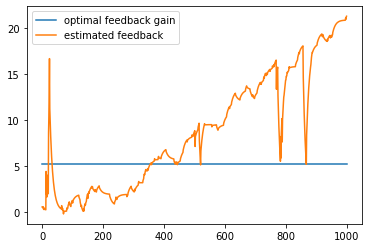

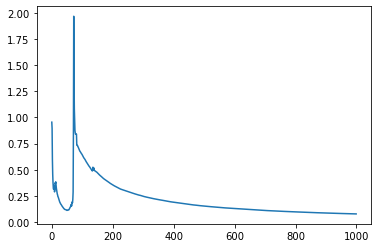

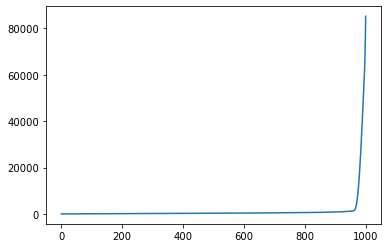

In [385]:
plt.figure()
plt.plot(np.ones(len(fvals))*feedbackvalue,label = 'optimal feedback gain')
plt.plot(fvals,label = 'estimated feedback')
plt.legend()
plt.show()

plt.figure()
plt.plot(error_over_time)
plt.show()

plt.figure()
plt.plot(regret)
plt.show()

In [206]:
#make plot of variance vs cmin
from tqdm import tqdm

variances = np.linspace(.1,10,100)

A1 = np.random.normal(0,1, (5,5))*.01

B1 = np.random.normal(0,1,(5,))*.5

C1 = np.random.normal(0,1,(5,))*.5

f1 = -.1

system1 = LTISystem(A1,B1,C1,f1,1,1)


A2 = np.random.normal(0,1, (5,5))*.15

B2 = np.random.normal(0,1,(5,))*.5

C2 = np.random.normal(0,1,(5,))*.5

f2 = -.1

system2 = LTISystem(A2,B2,C2,f2,1,1)


A3 = np.random.normal(0,1, (20,20))*.1

B3 = np.random.normal(0,1,(20,))*.3

C3 = np.random.normal(0,1,(20,))*.3

f3 = -.1

system3 = LTISystem(A3,B3,C3,f3,1,1)


cmin1 = []
cmin2 = []
cmin3 = []

vartouse = np.sqrt(variances)


for i in tqdm(range(len(variances))):
    system1.set_variance(vartouse[i])
    system2.set_variance(vartouse[i])
    system3.set_variance(vartouse[i])
    cmin1.append(system1.cmin_calculator())
    cmin2.append(system2.cmin_calculator())
    cmin3.append(system3.cmin_calculator())
    system1.wipe()
    system2.wipe()
    system3.wipe()
    


# system.cmin_calculator()

  0%|          | 0/100 [00:00<?, ?it/s]

Closed Loop max eigenvalue is: 
0.05103287545439515
Closed Loop max eigenvalue is: 
0.37967834619399893
Closed Loop max eigenvalue is: 
0.40782057906850705


100%|██████████| 100/100 [02:18<00:00,  1.38s/it]


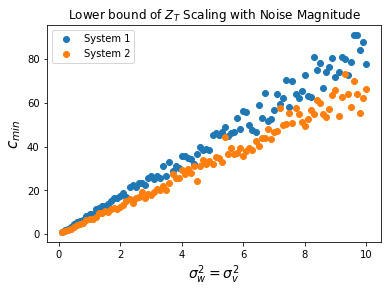

In [210]:
plt.figure()
# plt.scatter(variances,cmin1, label = 'System 1')
plt.scatter(variances,cmin2, label = 'System 1')
plt.scatter(variances,cmin3, label = 'System 2')
plt.legend()
plt.title(r"Lower bound of $Z_T$ Scaling with Noise Magnitude")
plt.xlabel(r'$\sigma_w^2 = \sigma_v^2$',fontsize = 14)
plt.ylabel(r'$c_{min}$',fontsize = 15)
plt.savefig('cminplot.png',bbox_inches='tight')
plt.show()

/Users/daltonjones/opt/anaconda3/lib/python3.8/site-packages/scipy/signal/filter_design.py:1625: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


Closed Loop max eigenvalue is: 
0.32475857359060506
Closed Loop max eigenvalue is: 
0.32475857359060506
Closed Loop max eigenvalue is: 
0.32475857359060506


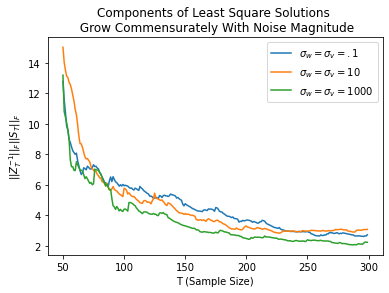

In [123]:

A = np.random.normal(0,1, (10,10))*.1

B = np.random.normal(0,1,(10,))*.5

C = np.random.normal(0,1,(10,))*.5


f = -.1


system = LTISystem(A,B,C,f,.1,.1)

system.simulate_in_closed_loop(1000)
output1 = system.outputs

yvals1 = []
for i in range(30,530):
    yvals1.append(np.array(output1[i-30:i]))
yvals1 = np.array(yvals1)

y1 = np.array(output1[30:30+500])




system = LTISystem(A,B,C,f,10,10)


system.simulate_in_closed_loop(1000)
output2 = system.outputs

# plt.figure()
# plt.plot(output2)
# plt.show()

yvals2 = []
for i in range(30,530):
    yvals2.append(np.array(output2[i-30:i]))
yvals2 = np.array(yvals2)

y2 = np.array(output2[30:30+500])


system = LTISystem(A,B,C,f,1000,1000)


system.simulate_in_closed_loop(1000)
output3 = system.outputs

# plt.figure()
# plt.plot(output3)
# plt.show()

yvals3 = []
for i in range(30,530):
    yvals3.append(np.array(output3[i-30:i]))
yvals3 = np.array(yvals3)

y3 = np.array(output3[30:30+500])

normvals1 = []
normvals2 = []
normvals3 = []

#time window 30

Tvals = np.arange(50,300)

for t in Tvals:
    mat11 = np.linalg.inv(yvals1[:t,:].T.dot(yvals1[:t,:]))
    mat12 = yvals1[:t,:].T.dot(y1[:t])
    
    normvals1.append(np.linalg.norm(mat12)*np.linalg.norm(mat11))
    
    mat21 = np.linalg.inv(yvals2[:t,:].T.dot(yvals2[:t,:]))
    mat22 = yvals2[:t,:].T.dot(y2[:t])
    
    normvals2.append(np.linalg.norm(mat22)*np.linalg.norm(mat21))
    
    mat31 = np.linalg.inv(yvals3[:t,:].T.dot(yvals3[:t,:]))
    mat32 = yvals3[:t,:].T.dot(y3[:t])
    
    normvals3.append(np.linalg.norm(mat32)*np.linalg.norm(mat31))
    
plt.figure()
plt.plot(Tvals,normvals1,label = r"$\sigma_w = \sigma_v = .1$")
plt.plot(Tvals,normvals2,label = r"$\sigma_w = \sigma_v = 10$")
plt.plot(Tvals,normvals3,label = r"$\sigma_w = \sigma_v = 1000$")
plt.ylabel(r"$||Z_T^{-1}||_F||S_T||_F$")
plt.xlabel("T (Sample Size)")
plt.legend()
plt.title("Components of Least Square Solutions \n Grow Commensurately With Noise Magnitude")
plt.savefig('SigmaCollapse2.png',bbox_inches='tight')
plt.show()




In [ ]:
assert False
    


G_hat,err = system.estimate_markov_parameters(window = 10,T=200,num_iter=400, run = True)

print(G_hat)
print(err)

assert False

cov,lambda_min = system.calculate_empirical_variance(5,20)

# print(lambda_min)

lambdas = []

Tvals = np.arange(10,150)
for T in Tvals:
    
    cov,l = system.calculate_empirical_variance(5,T,200)
    lambdas.append(l)
    
plt.figure()
plt.scatter(Tvals,lambdas)
plt.show()
    

In [62]:
cov

array([[62.95387548, 34.82074433, 24.58178407, 27.84490816, 25.61774176],
       [34.82074433, 62.59611989, 33.88415733, 22.63872558, 25.8276781 ],
       [24.58178407, 33.88415733, 63.62371875, 24.45973796, 10.25951504],
       [27.84490816, 22.63872558, 24.45973796, 58.47771449, 22.35226424],
       [25.61774176, 25.8276781 , 10.25951504, 22.35226424, 61.58362277]])

[[ 0.42  -0.271  0.25  -0.1  ]
 [ 1.     0.     0.     0.   ]
 [ 0.     1.     0.     0.   ]
 [ 0.     0.     1.     0.   ]]
0.6430510969328234


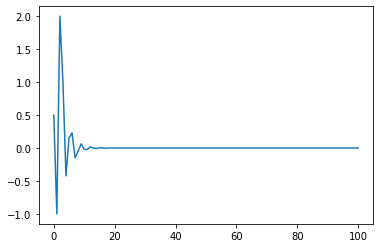

In [45]:
coeffs = np.array([.42,-.271,.25,-.1])

#try making matrix...

coeffs_mat = np.zeros((4,4))

coeffs_mat[0,:] = coeffs
coeffs_mat[1:,:3] = np.eye(3)

print(coeffs_mat)


print(np.max(np.abs(np.linalg.eigvals(coeffs_mat))))



y = np.array([1,2,-1,.5])

y_list = [y[-1]]

for i in range(100):
    y = coeffs_mat.dot(y)
    y_list.append(y[-1])
    

plt.plot(y_list)
    
    
    

0.9379797651759967
[0.0037099784732466516, 0.0054094057310715175, 0.007475158174704547, 0.009898078051682267, 0.01265783542942965, 0.01572491973978124, 0.019062696117423592, 0.022629411315105125, 0.02638007073892864, 0.030268136519313857, 0.034247017974858594, 0.03827134166034531, 9.223330447945822e-16, 1.0449416080589952e-15, 1.1655006127285608e-15, 1.2047502978955266e-15, 1.3092471128191966e-15, 1.3664806115641616e-15, 3.8100346458430455e-15, 3.810075834214083e-15, 3.810063153984394e-15, 3.810027445430209e-15, 3.809988150551481e-15, 3.8099567119499686e-15, 3.8099390799055015e-15, 3.809937542543415e-15, 3.80995204526049e-15, 6.604638215756615e-15, 3.960835157317162e-15, 3.810073859391743e-15, 3.810132434355387e-15, 7.137949722507565e-15, 6.233205563808157e-15, 4.608159638824283e-15, 3.81039595907907e-15, 4.388702308588015e-15, 5.620128483305514e-15, 6.865489140690106e-15, 8.455549827594776e-15, 9.52275194047401e-15, 8.045960590018943e-15, 9.323405941395282e-15, 1.0482551184929503e-14,

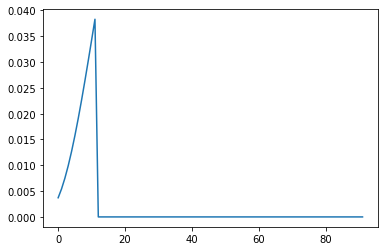

In [159]:
# np.random.seed(3)

# A_0 = np.round(np.random.normal(0,1,(10,10))/6,2)
A_0 = np.eye(10)*.9+.1*np.round(np.random.normal(0,1,(10,10))/6,2)
B_0 = np.ones((10,1))
C_0 = np.ones((1,10))

print(np.max(np.abs(np.linalg.eigvals(A_0))))

C_0.dot(A_0.dot(B_0))[0,0]


hankel_sing_val_mins =[]

for i in range(8,100):
    hank = np.zeros((i,i))
    for j in range(i):
        for k in range(i):
            hank[j,k] = C_0.dot(np.linalg.matrix_power(A_0,j+k).dot(B_0))[0,0]
    
    _, s, _ = np.linalg.svd(hank, full_matrices=True)
    
    if len(s)<20:
        s = np.array(list(filter(lambda a: a > .001, s)))
    
#     print(s)
        try:
            hankel_sing_val_mins.append(np.min(s))
        except:
            pass
        
    else:
        hankel_sing_val_mins.append(s[9])
#         print(s)
#         assert False
    
print(hankel_sing_val_mins)
plt.figure()
plt.plot(hankel_sing_val_mins)
plt.show()
    

In [263]:
def jury ( p ) :
    """
    Função para verificar se um sistema é ou não
    estável, utilizando o critério de Jury.
    ---
    Function to verify the stability of a system
    according to Jury criterion.
    """

    debug = False

    def eval ( p, v ) :
        """
        Função para calcular um valor 'v' aplicado
        em um polinômio 'p'
        ----
        Function to evaluate a value 'v' in a poly-
        nom 'p'
        """
        res = 0
        for i in range( len(p) ): 
            res += p[::-1][i] * ( v ** ( i ))
        return res
    
    def printa ( a ) :
        """
        Função para imprimir uma lista de coefici-
        entes.
        ----
        Function to print a line of coefficients in
        forward and reverse order.
        """
        if len(a) > 0 :
            for i in a :
                print('%.4f\t\t' % round(i, 4), end='')
            print()
            for i in a[::-1] :
                print('%.4f\t\t' % round(i, 4), end='')
            print()

    # Calcula grau do polinômio
    n = len(p) - 1

    # Verifica primeira condição
    if eval ( p, 1 ) <= 0 :
        print('1. Sistema instável.')
        return

    # Verifica segunda condição
    if (((-1) ** n ) * eval ( p, -1 )) <= 0 :
        print('2. Sistema instável.')
        return

    # Inverte a ordem dos coeficientes do polinômio
    # para que podemos prosseguir com mais facilidade
    p = p[::-1]

    # Verifica terceira condição
    if abs(p[0]) >= abs(p[-1]) :
        print('3. Sistema instável.')
        return

    # Define a linha atual como os coeficientes do 
    # polinômio
    l = p

    # Caso estejamos debugando o código, imprime a 
    # linha
    if debug :
        printa(l)

    # Itera até que tenhamos apenas 1 coeficiente
    # restante na linha
    for i in range ( n + 1 ) :
        # Define nova linha
        nl = []
        for j in range ( len(l) - 1 ) :
            
            x0   = l[0]
            xk   = l[j]
            xn   = l[-1]
            xn_k = l[-(j + 1)]

            # Calcula o determinante e adiciona na nova linha
            nl.append( x0 * xk - xn * xn_k )
        
        # Define a linha atual como a nova linha
        l = nl

        # Se o tamanho da linha for maior que 1
        # faz o teste de estabilidade:
        # |b0| > |bn-1|
        # |c0| > |cn-2|
        # |d0| > |dn-3|
        # ...
        if len(l) > 1 :
            if abs(l[0]) <= abs(l[-1]) :
                print(f'{4 + i}. System Unstable.')
                return

        # Caso estejamos debugando o código, imprime a 
        # linha
        if debug :
            printa(l)

    # Se chegar até aqui é porque o sistema é estável
    print('System Stable')

In [273]:
jury([-.001,.1,-.005,-.1])

1. Sistema instável.


In [320]:
from tqdm import tqdm

# np.random.seed(5)

A_0 = .56*np.random.rand(4,4)
B_0 = np.random.normal(0,1,(4,1))
B_0/=np.linalg.norm(B_0)
C_0 = np.random.normal(0,1,(1,4))
C_0/=np.linalg.norm(C_0)

print(np.max(np.abs(np.linalg.eigvals(A_0))))
f= -1.5

sys = StateSpace(A_0, B_0.reshape(len(A_0),1), C_0.reshape(1,len(A_0)), np.array([[0]]))
        
        
transferFunction = tf(sys)

num = transferFunction.num
den = transferFunction.den

padded_num = np.zeros(len(den))

padded_num[-len(num):] = num

closed_loop_char_poly = f*padded_num+den
print('Closed Loop max eigenvalue is: ')
print(np.max(np.abs(np.roots(closed_loop_char_poly))))

#okay so this is closed loop stable,

#build truncated matrix out of the markov paramaters, and see if these are mostly stable (or all stable)


markov_params = []
for i in range(400):
    markov_params.append(f*C_0.dot(np.linalg.matrix_power(A_0,i).dot(B_0))[0,0])

markov_params = np.array(markov_params)


eigs = []

for i in tqdm(range(15,400,5)):
    closed_loop_mat = np.zeros((i,i))
    closed_loop_mat[0,:] = markov_params[:i]
    
    closed_loop_mat[1:,:-1] = np.eye(i-1,i-1)
    
    eigs.append(np.max(np.abs(np.linalg.eigvals(closed_loop_mat))))
    
#     eigs.append(np.max(np.abs(np.roots(np.flip(np.array(list(markov_params[:i])+[1]))))))
print(eigs)



 31%|███       | 24/77 [00:00<00:00, 227.28it/s]

1.0423985875584718
Closed Loop max eigenvalue is: 
0.7751779616598338


100%|██████████| 77/77 [00:03<00:00, 21.10it/s] 

[1.2836062790372798, 1.2912370263787674, 1.2935822784986422, 1.294343713504813, 1.2945969026067417, 1.2946819534011778, 1.2947106443691676, 1.2947203394675775, 1.294723617786826, 1.2947247266125466, 1.2947251016878174, 1.2947252285668243, 1.2947252714875557, 1.2947252860068945, 1.294725290918542, 1.29472529258007, 1.2947252931421367, 1.2947252933322755, 1.2947252933965918, 1.2947252934183537, 1.2947252934257123, 1.2947252934282059, 1.2947252934290452, 1.2947252934293298, 1.2947252934294324, 1.2947252934294649, 1.2947252934294764, 1.2947252934294742, 1.2947252934294773, 1.294725293429474, 1.294725293429477, 1.2947252934294802, 1.2947252934294802, 1.2947252934294753, 1.2947252934294748, 1.294725293429481, 1.294725293429478, 1.2947252934294735, 1.2947252934294766, 1.2947252934294766, 1.294725293429482, 1.29472529342948, 1.2947252934294802, 1.2947252934294755, 1.2947252934294808, 1.2947252934294764, 1.2947252934294777, 1.2947252934294766, 1.29472529342947, 1.2947252934294702, 1.29472529342

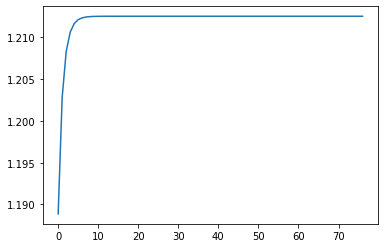

In [319]:
plt.plot(eigs)


In [62]:
a = np.array([0,1,2,3,4,5,6,7,8,9])

In [66]:
a[1:3]


array([1, 2])

In [67]:
a[4:]

array([4, 5, 6, 7, 8, 9])

In [124]:
a**2

array([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81])

In [244]:
a[-4:]


array([6, 7, 8, 9])